In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import pinyin
from platform import python_version
import logging

logger = logging.getLogger(name = 'test')
logger.setLevel(logging.DEBUG)
print(python_version())

3.7.0


In [2]:
# from matplotlib.font_manager import _rebuild
# import matplotlib
# matplotlib.matplotlib_fname()
# _rebuild()

In [3]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/usr/local/opt/python/bin/python3.7
3.7.0 (default, Sep 18 2018, 18:47:29) 
[Clang 9.0.0 (clang-900.0.39.2)]
sys.version_info(major=3, minor=7, micro=0, releaselevel='final', serial=0)


# 第一部分-读取历史数据

In [4]:
path_data = './Data/DXY-COVID-19-Data/csv'

dfArea = pd.read_csv(path_data + '/DXYArea.csv')
dfArea['updateTime'] = pd.to_datetime(dfArea['updateTime'])
dfArea.sort_values('updateTime', inplace = True)
dfArea['date'] = dfArea['updateTime'].apply(lambda x:x.date())

In [5]:
dfOverall = pd.read_csv(path_data + '/DXYOverall.csv')
dfNews = pd.read_csv(path_data + '/DXYNews.csv')
dfRumors = pd.read_csv(path_data + '/DXYRumors.csv')

## Feature Names

In [6]:
features = ['province_confirmedCount', 'province_suspectedCount', 'province_curedCount', 'province_deadCount']
features_city = ['city_confirmedCount', 'city_suspectedCount', 'city_curedCount', 'city_deadCount']

### Assign country/province/city English names to missing values: Waterfall Logic


- 原数据很多国家的Country英文名为空，对这些国家，countryEnglishName赋值国家中文名的拼音。
- 如果Province英文名为空。那么ProvinceEnglishName赋值Country的拼音。
- 如果city的英文名为空，把Province Name填上去

#### Observation：每行数据都有一个中文的provinceName，如果该行数据是国家，那么provinceName与countryName相同

#### 首先确认如果一个国家英文名出现NaN，那么该国家所有entry的英文名都是NaN

In [7]:
allCountries = dfArea.countryName.unique()
countryEnglishNamesNAValuesCount = {}
for ctry in allCountries:
    dfCountry   = dfArea[dfArea.countryName == ctry]
    nanNumsCtry = dfCountry.countryEnglishName.isnull().sum()
    countryEnglishNamesNAValuesCount[ctry] = pd.DataFrame([[len(dfCountry), 
               nanNumsCtry,
               nanNumsCtry == len(dfCountry) & nanNumsCtry > 0]], columns = ['Num Of Entries',
                                                                  'Num Of NaN English Names',
                                                                  'All English Names Missing'])
countryEnglishNamesNAValuesCount = pd.concat(countryEnglishNamesNAValuesCount)

In [8]:
countryEnglishNamesNAValuesCount[countryEnglishNamesNAValuesCount['All English Names Missing']]

Num Of Entries  Num Of NaN English Names  \
东帝汶        0              42                        42   
也门共和国      0              11                        11   
佛得角        0              98                        98   
几内亚比绍      0              70                        70   
刚果（布）      0             138                       138   
北马里亚纳群岛联邦  0              49                        49   
南苏丹        0              33                        33   
厄立特里亚      0             114                       114   
吉尔吉斯斯坦     0             233                       233   
圣其茨和尼维斯    0              65                        65   
圣巴泰勒米岛     0              82                        82   
圣皮埃尔和密克隆群岛 0              11                        11   
多米尼克       0              63                        63   
安圭拉        0              29                        29   
布隆迪共和国     0              32                        32   
库拉索岛       0             125                       125   
新喀里多尼亚     0             104                       104   
格林那达       0              74                        74   
格陵兰        0             111                       111   
特克斯和凯科斯群岛  0              61                        61   
瓜德罗普岛      0             216                       216   
百慕大        0             121                       121   
福克兰群岛      0              24                        24   
科索沃        0              12                        12   
美属维尔京群岛    0             131                       131   
英属维尔京群岛    0              29                        29   
荷兰加勒比地区    0              18                        18   
荷属圣马丁      0              51                        51   
蒙特塞拉特      0              78                        78   
赞比亚共和国     0             176                       176   
阿鲁巴        0             159                       159   
马约特        0             222                       222   
黑山         0             228                       228   

              All English Names Missing  
东帝汶        0                       True  
也门共和国      0                       True  
佛得角        0                       True  
几内亚比绍      0                       True  
刚果（布）      0                       True  
北马里亚纳群岛联邦  0                       True  
南苏丹        0                       True  
厄立特里亚      0                       True  
吉尔吉斯斯坦     0                       True  
圣其茨和尼维斯    0                       True  
圣巴泰勒米岛     0                       True  
圣皮埃尔和密克隆群岛 0                       True  
多米尼克       0                       True  
安圭拉        0                       True  
布隆迪共和国     0                       True  
库拉索岛       0                       True  
新喀里多尼亚     0                       True  
格林那达       0                       True  
格陵兰        0                       True  
特克斯和凯科斯群岛  0                       True  
瓜德罗普岛      0                       True  
百慕大        0                       True  
福克兰群岛      0                       True  
科索沃        0                       True  
美属维尔京群岛    0                       True  
英属维尔京群岛    0                       True  
荷兰加勒比地区    0                       True  
荷属圣马丁      0                       True  
蒙特塞拉特      0                       True  
赞比亚共和国     0                       True  
阿鲁巴        0                       True  
马约特        0                       True  
黑山         0                       True

In [9]:
dfArea.loc[dfArea.countryEnglishName.isnull(),
           'countryEnglishName'] = dfArea.loc[dfArea.countryEnglishName.isnull(), 
                                              'countryName'].apply(pinyin.get)

In [10]:
print(dfArea.loc[dfArea.provinceEnglishName.isnull()].shape)
print(dfArea.loc[(dfArea.provinceEnglishName.isnull()) & (dfArea.cityEnglishName.isnull())].shape)

(3010, 20)
(3010, 20)


In [11]:
dfArea.loc[dfArea.provinceName.isnull()].shape


(0, 20)

In [12]:
dfArea.loc[dfArea.provinceEnglishName.isnull(),
           'provinceEnglishName'] = dfArea.loc[dfArea.provinceEnglishName.isnull(), 
                                              'provinceName'].apply(pinyin.get)

In [13]:
dfArea.loc[dfArea.cityName.isnull(), 'cityName'] = dfArea.loc[dfArea.cityName.isnull(), 'provinceName']

In [14]:
dfArea.loc[dfArea.cityEnglishName.isnull(),
           'cityEnglishName'] = dfArea.loc[dfArea.cityEnglishName.isnull(), 
                                              'provinceEnglishName']

### Assign a group to each row of data: Country/Province/City level. This label is mainly used for identifying China's regional data

In [15]:
dfArea['Group'] = dfArea.apply(lambda x:'Country'if x.countryName == x.provinceName else
                                        'Province' if x.provinceName == x.cityName else 
                                        'City',
                               axis = 1)

#### 确认只有中国有完整的省份、城市数据，其他国家都只有全国数据。

In [16]:
countryEnglishNameMap = dfArea[['countryName', 'countryEnglishName']].drop_duplicates(subset = ['countryName']).set_index('countryName')

In [17]:
dfArea[dfArea.Group == 'Country'].countryName.unique()

array(['泰国', '澳大利亚', '新加坡', '日本', '美国', '马来西亚', '法国', '越南', '尼泊尔', '加拿大',
       '韩国', '柬埔寨', '德国', '斯里兰卡', '阿联酋', '芬兰', '印度', '意大利', '英国', '俄罗斯',
       '西班牙', '瑞典', '菲律宾', '比利时', '埃及', '钻石公主号邮轮', '伊朗', '黎巴嫩', '以色列',
       '伊拉克', '科威特', '巴林', '阿富汗', '阿曼', '克罗地亚', '瑞士', '阿尔及利亚', '奥地利',
       '希腊', '巴基斯坦', '巴西', '罗马尼亚', '格鲁吉亚', '丹麦', '爱沙尼亚', '挪威', '北马其顿',
       '荷兰', '北爱尔兰', '尼日利亚', '立陶宛', '新西兰', '白俄罗斯', '英国（含北爱尔兰）', '阿塞拜疆',
       '冰岛', '摩纳哥', '墨西哥', '大不列颠及北爱尔兰联合王国', '卡塔尔', '爱尔兰', '卢森堡', '厄瓜多尔',
       '圣马力诺', '亚美尼亚', '捷克', '多米尼加', '印度尼西亚', '安道尔', '沙特阿拉伯', '乌克兰',
       '摩洛哥', '塞内加尔', '约旦', '葡萄牙', '智利', '阿根廷', '列支敦士登', '突尼斯', '拉脱维亚',
       '波兰', '匈牙利', '斯洛文尼亚', '波黑', '巴勒斯坦', '不丹', '梵蒂冈', '喀麦隆', '塞尔维亚',
       '南非', '秘鲁', '至尊公主邮轮', '哥斯达黎加', '哥伦比亚', '多哥', '马耳他', '巴拉圭', '马尔代夫',
       '斯洛伐克', '保加利亚', '摩尔多瓦', '布基纳法索', '阿尔巴尼亚', '塞浦路斯', '蒙古', '巴拿马',
       '孟加拉国', '文莱', '土耳其', '牙买加', '刚果（金）', '玻利维亚', '科特迪瓦', '古巴', '圭亚那',
       '洪都拉斯', '特立尼达和多巴哥', '加纳', '加蓬', '肯尼亚', '法属圭亚那', '圣巴泰勒米', '圣马

In [18]:
dfArea[dfArea.Group == 'Province'].countryName.unique()

array(['中国'], dtype=object)

In [19]:
dfArea[dfArea.Group == 'City'].countryName.unique()

array(['中国'], dtype=object)

In [20]:
dfAreaGroup = dfArea.groupby(['countryEnglishName', 'provinceName', 'date']).last().sort_index()

In [21]:
# recentCity = dfAreaGroup.loc['China'].loc[pd.IndexSlice[:,
#                                            [x.date() for x in pd.date_range(dt.date(2020, 3, 1),dt.date(2020, 3, 29))]], 
#                                           'city_confirmedCount'].drop(['中国', '湖北省']).unstack(0)

# recentProvince = dfAreaGroup.loc['China'].loc[pd.IndexSlice[:,
#                                            [x.date() for x in pd.date_range(dt.date(2020, 3, 1),dt.date(2020, 3, 29))]], 
#                                               'province_confirmedCount'].drop(['中国', '湖北省']).unstack(0)

# 第二部分-分国家水平数据拟合

In [22]:
dfChinaByProvince = dfAreaGroup.loc['China'].drop('中国')
provinceChinaList = dfChinaByProvince.index.get_level_values(0).unique()

In [23]:
countriesList = dfAreaGroup.index.levels[0]
countriesListCN = dfAreaGroup.index.levels[1].difference(provinceChinaList)

In [24]:
provinceChinaList

Index(['上海市', '云南省', '内蒙古自治区', '北京市', '台湾', '吉林省', '四川省', '天津市', '宁夏回族自治区',
       '安徽省', '山东省', '山西省', '广东省', '广西壮族自治区', '新疆维吾尔自治区', '江苏省', '江西省', '河北省',
       '河南省', '浙江省', '海南省', '湖北省', '湖南省', '澳门', '甘肃省', '福建省', '西藏自治区', '贵州省',
       '辽宁省', '重庆市', '陕西省', '青海省', '香港', '黑龙江省'],
      dtype='object', name='provinceName')

## 2.1 数据可视化

In [25]:
countriesListCN.tolist()

['不丹',
 '东帝汶',
 '中国',
 '中非共和国',
 '丹麦',
 '乌克兰',
 '乌兹别克斯坦',
 '乌干达',
 '乌拉圭',
 '乍得',
 '也门共和国',
 '亚美尼亚',
 '以色列',
 '伊拉克',
 '伊朗',
 '伯利兹',
 '佛得角',
 '俄罗斯',
 '保加利亚',
 '克罗地亚',
 '关岛',
 '冈比亚',
 '冰岛',
 '几内亚',
 '几内亚比绍',
 '列支敦士登',
 '刚果（布）',
 '刚果（金）',
 '利比亚',
 '利比里亚',
 '加拿大',
 '加纳',
 '加蓬',
 '匈牙利',
 '北爱尔兰',
 '北马其顿',
 '北马里亚纳群岛联邦',
 '南苏丹',
 '南非',
 '博茨瓦纳',
 '卡塔尔',
 '卢旺达',
 '卢森堡',
 '印度',
 '印度尼西亚',
 '危地马拉',
 '厄瓜多尔',
 '厄立特里亚',
 '叙利亚',
 '古巴',
 '吉尔吉斯斯坦',
 '吉布提',
 '哈萨克斯坦',
 '哥伦比亚',
 '哥斯达黎加',
 '喀麦隆',
 '土耳其',
 '圣其茨和尼维斯',
 '圣卢西亚',
 '圣多美和普林西比',
 '圣巴泰勒米',
 '圣巴泰勒米岛',
 '圣文森特和格林纳丁斯',
 '圣皮埃尔和密克隆群岛',
 '圣马丁岛',
 '圣马力诺',
 '圭亚那',
 '坦桑尼亚',
 '埃及',
 '埃塞俄比亚',
 '塞内加尔',
 '塞尔维亚',
 '塞拉利昂',
 '塞浦路斯',
 '塞舌尔',
 '墨西哥',
 '多哥',
 '多米尼克',
 '多米尼加',
 '大不列颠及北爱尔兰联合王国',
 '奥地利',
 '委内瑞拉',
 '孟加拉国',
 '安哥拉',
 '安圭拉',
 '安提瓜和巴布达',
 '安道尔',
 '尼加拉瓜',
 '尼日利亚',
 '尼日尔',
 '尼泊尔',
 '巴勒斯坦',
 '巴哈马',
 '巴基斯坦',
 '巴巴多斯',
 '巴布亚新几内亚',
 '巴拉圭',
 '巴拿马',
 '巴林',
 '巴西',
 '布基纳法索',
 '布隆迪共和国',
 '希腊',
 '库拉索岛',
 '开曼群岛',
 '德国',
 '意大利',
 '拉脱维亚',
 '挪威',
 '捷克',
 '摩尔多瓦',
 '摩洛哥',
 '摩纳哥',


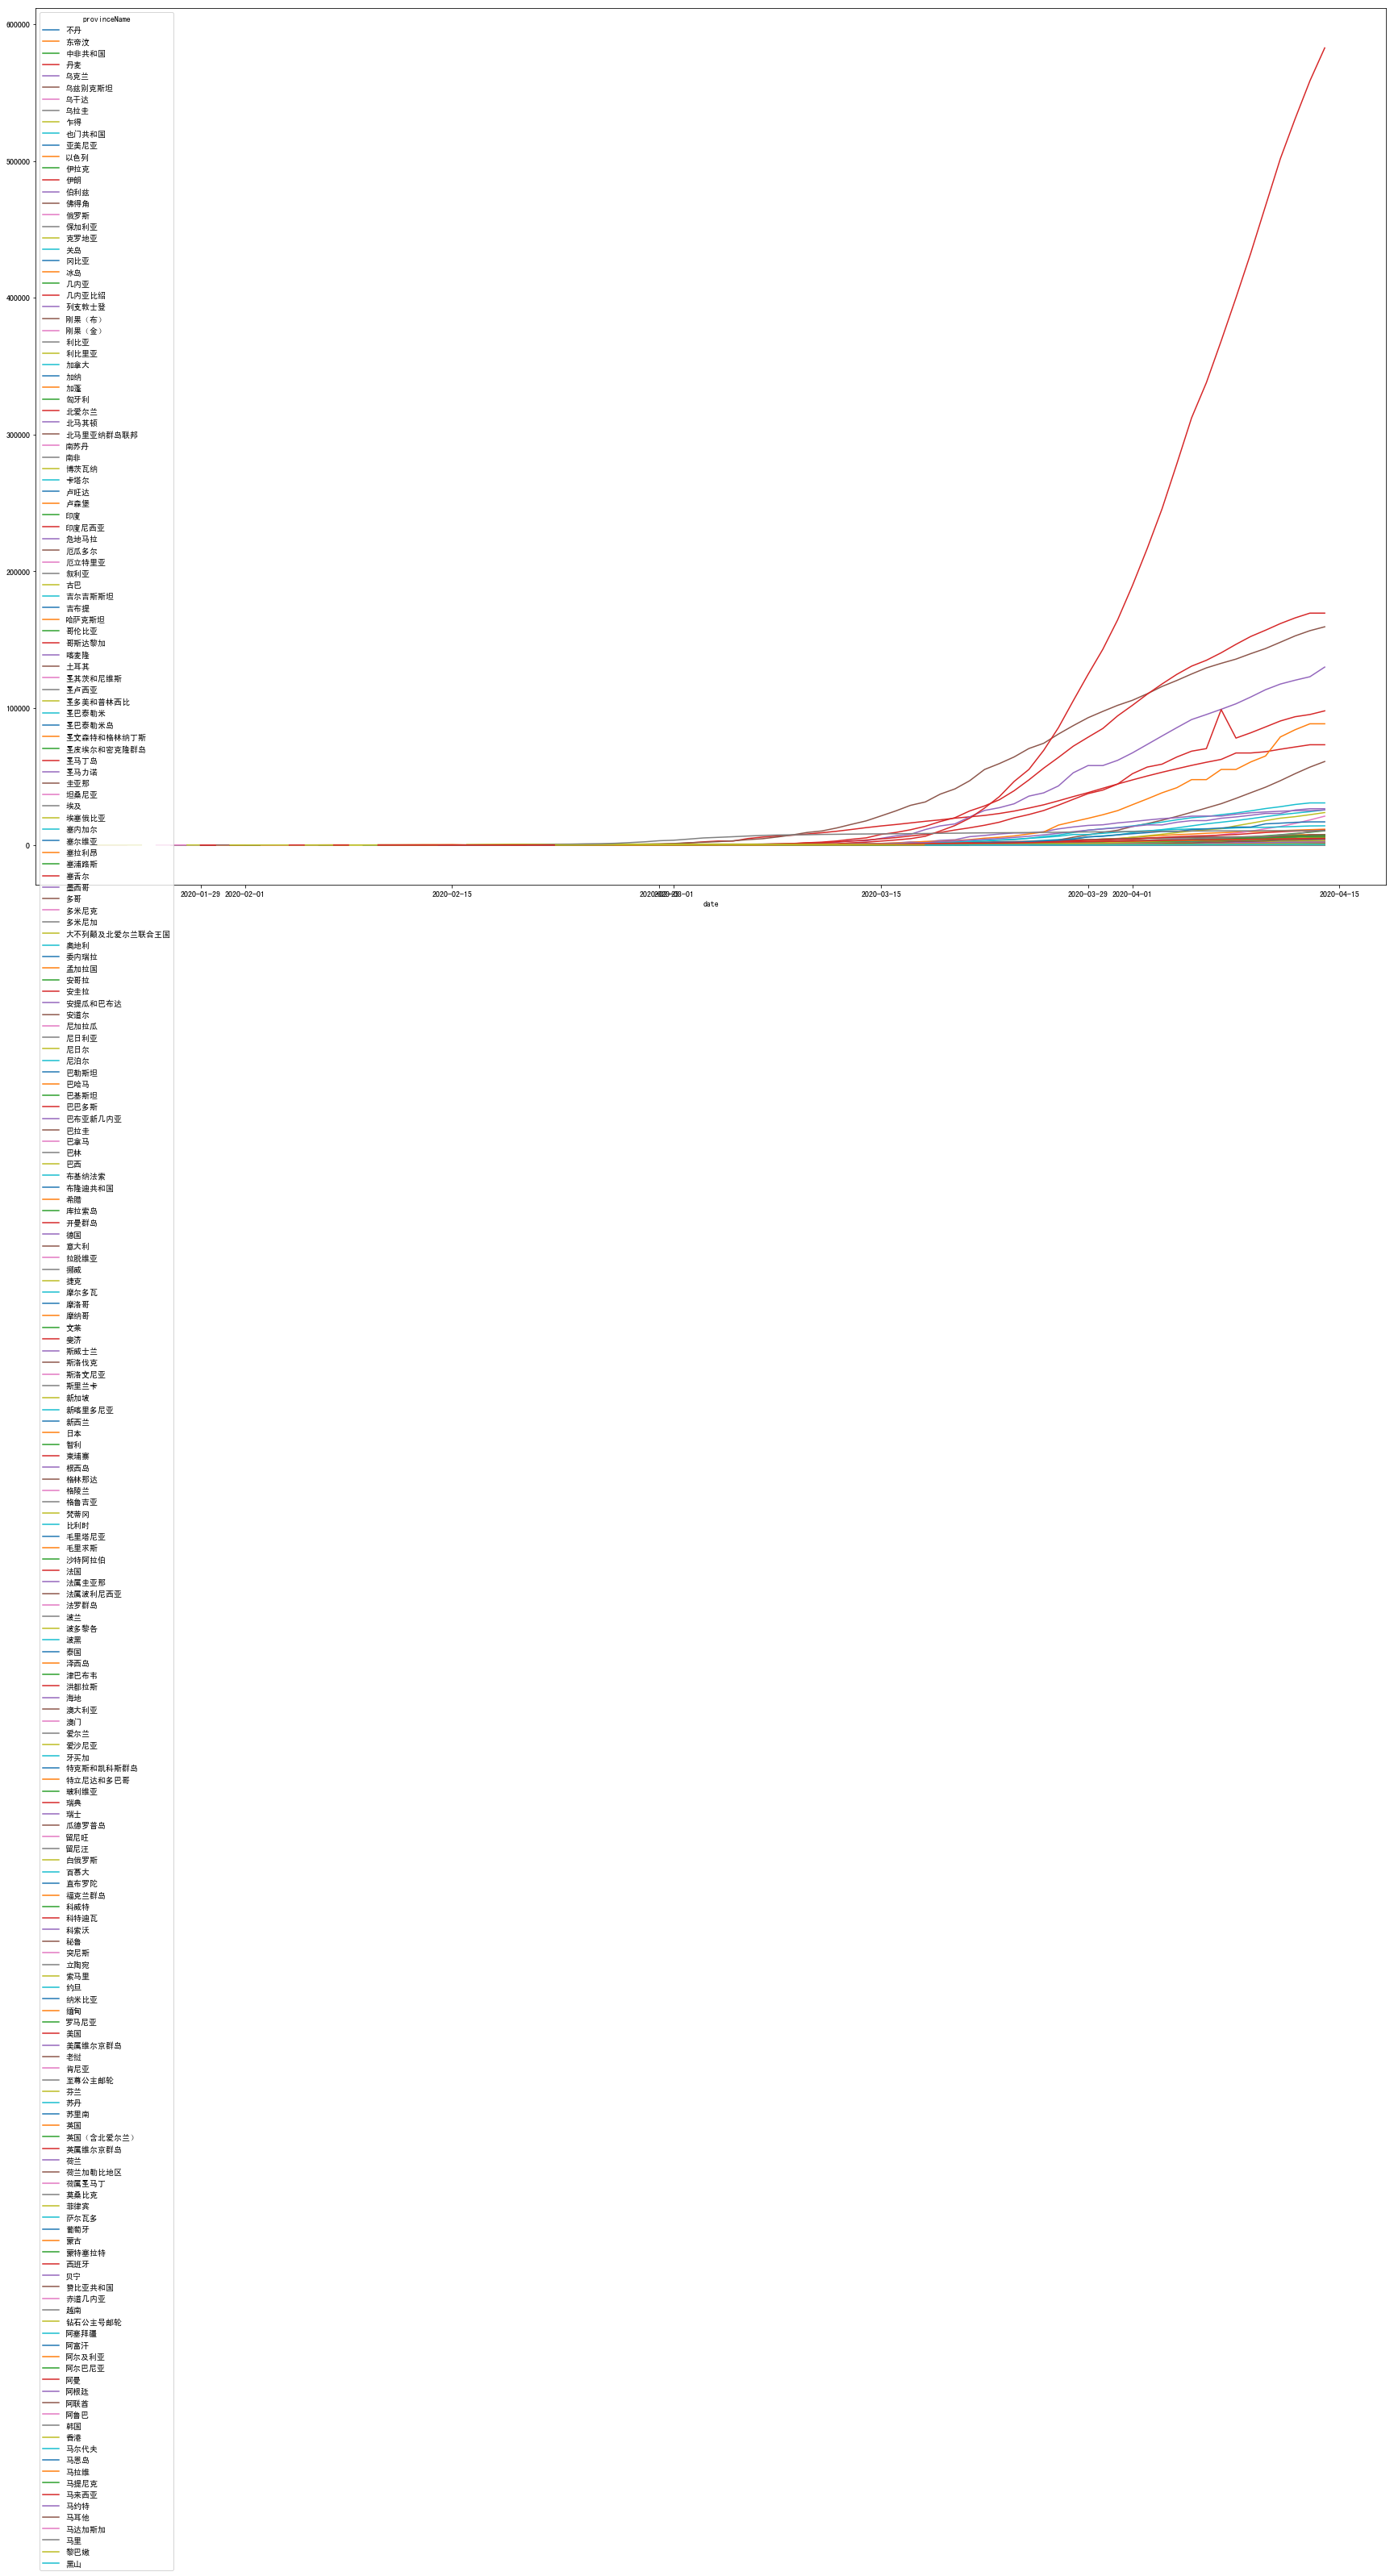

In [26]:
dfAreaGroup.loc[countriesList.difference(['China'])].sum(level = [1, 2])['province_confirmedCount'].unstack(-2).plot(figsize = (30, 20))


/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


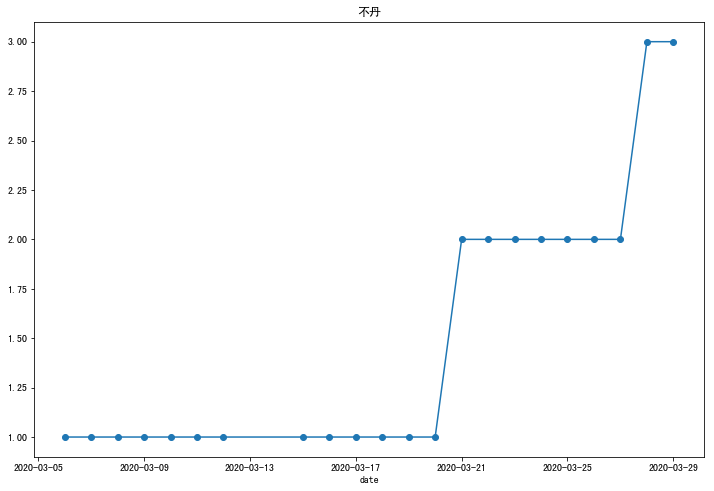

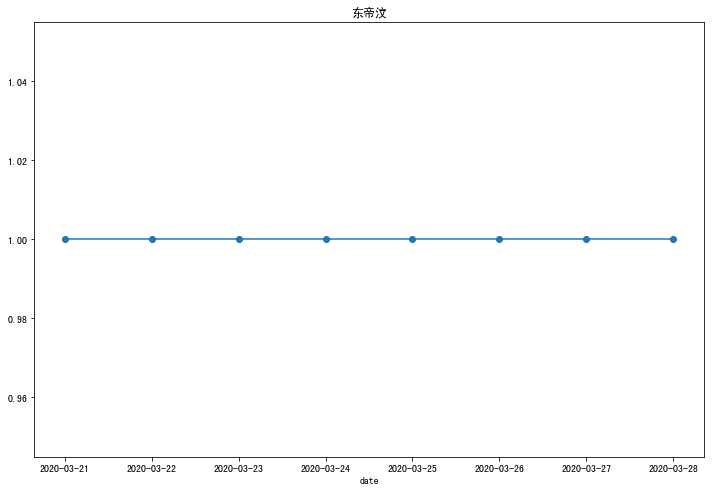

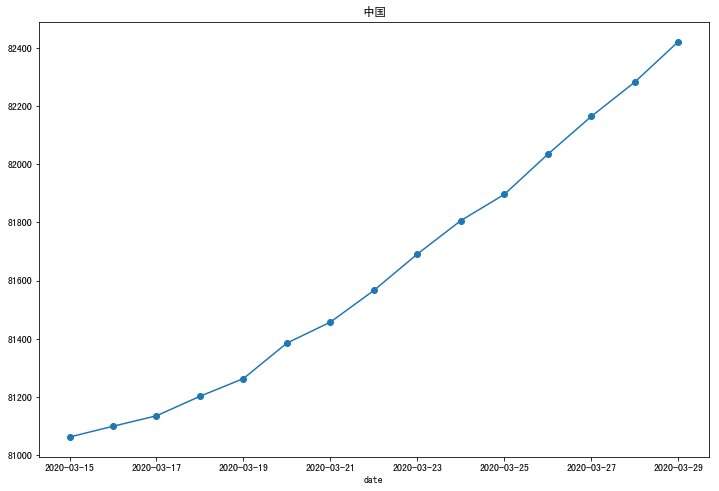

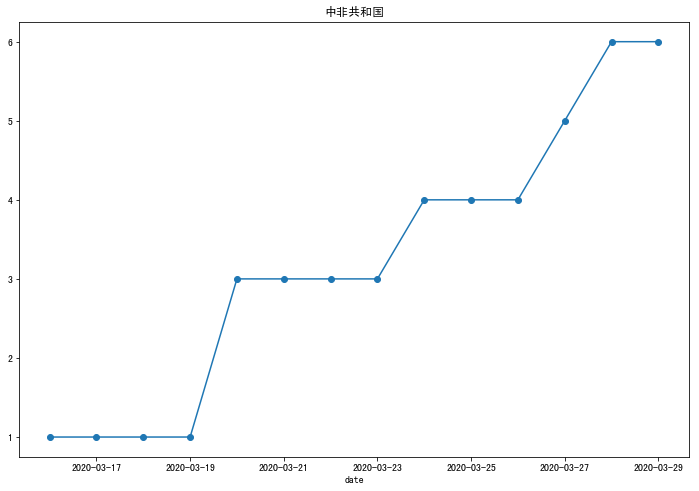

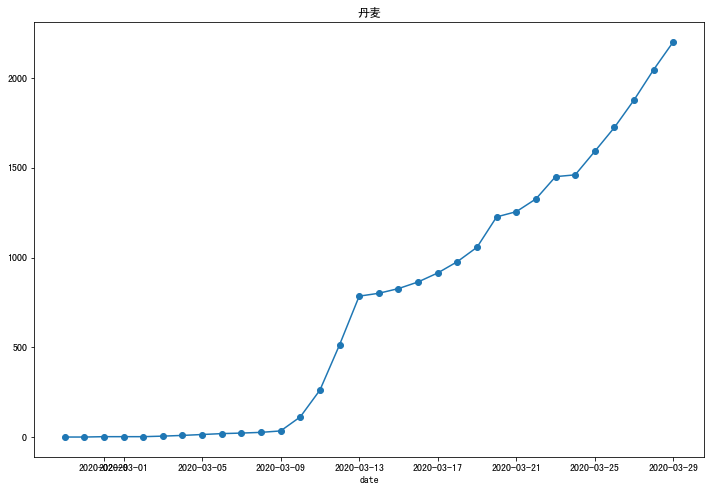

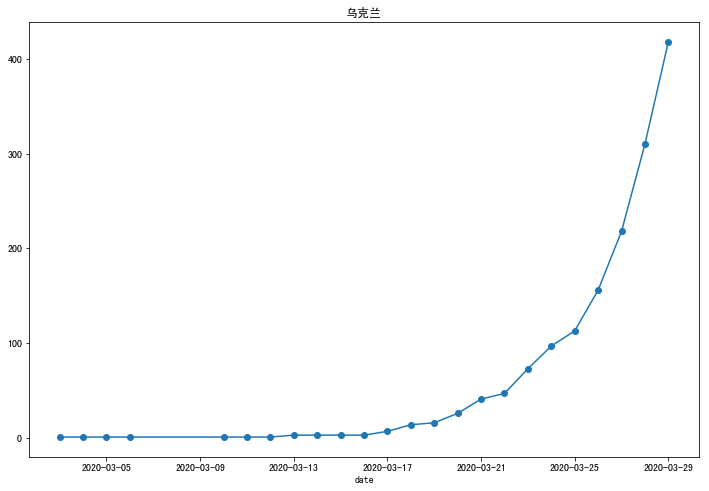

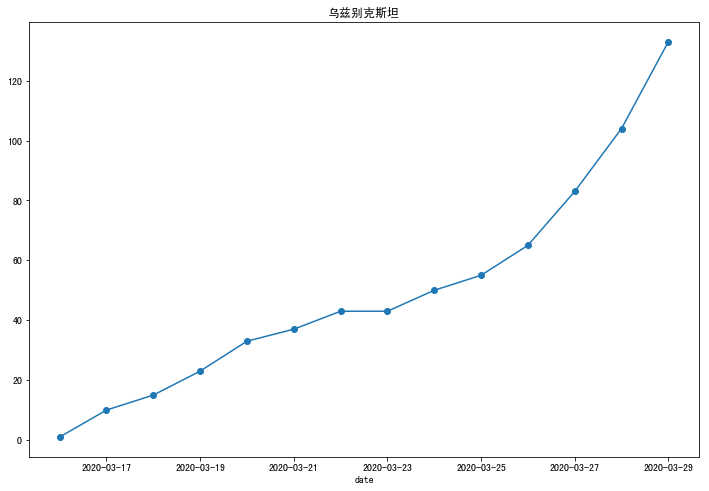

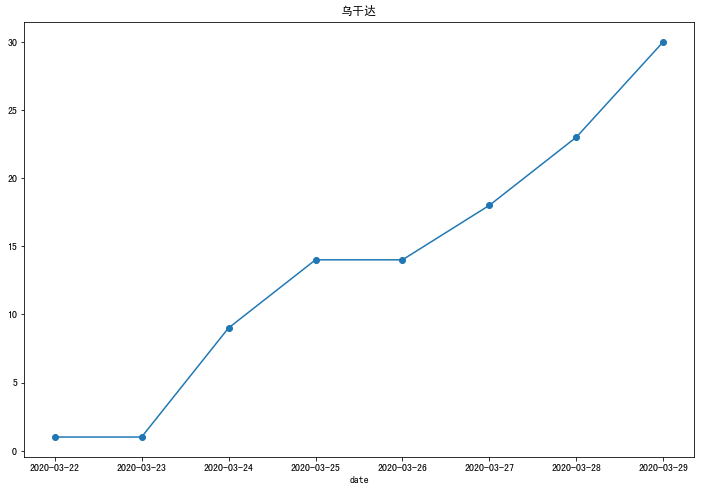

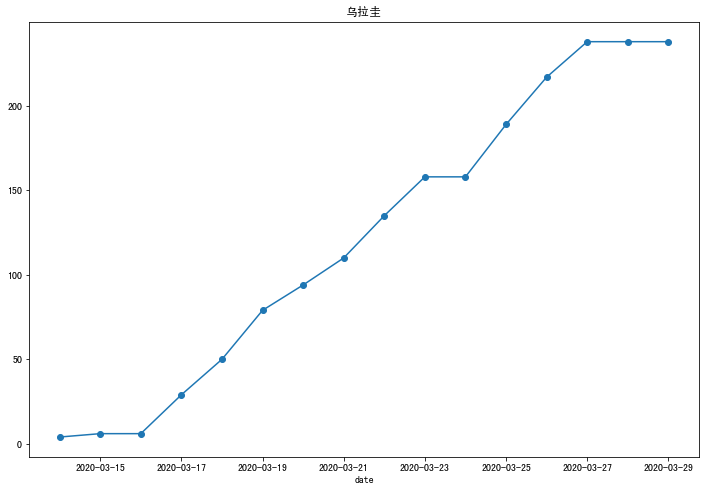

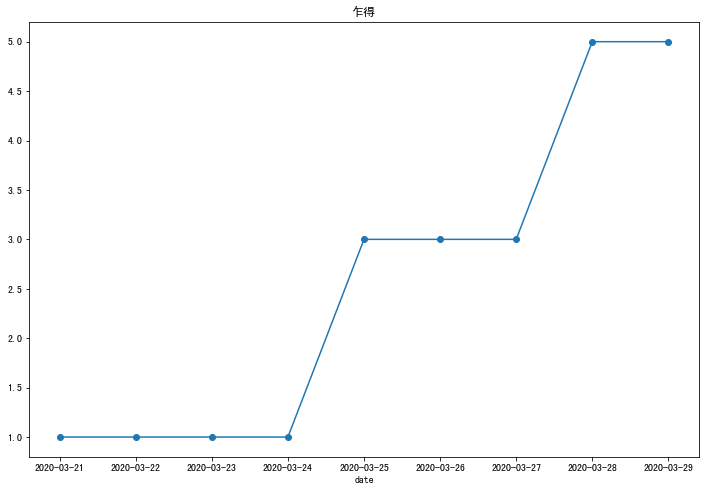

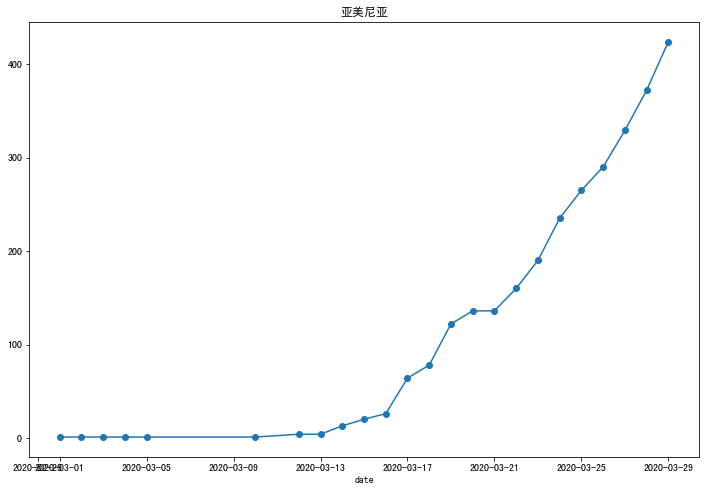

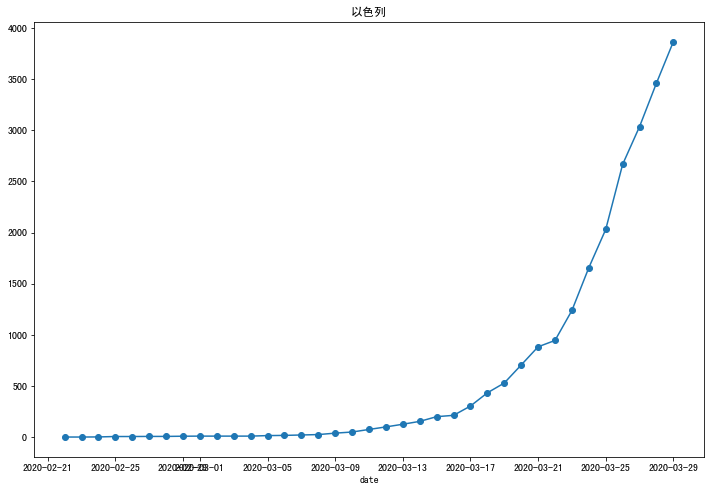

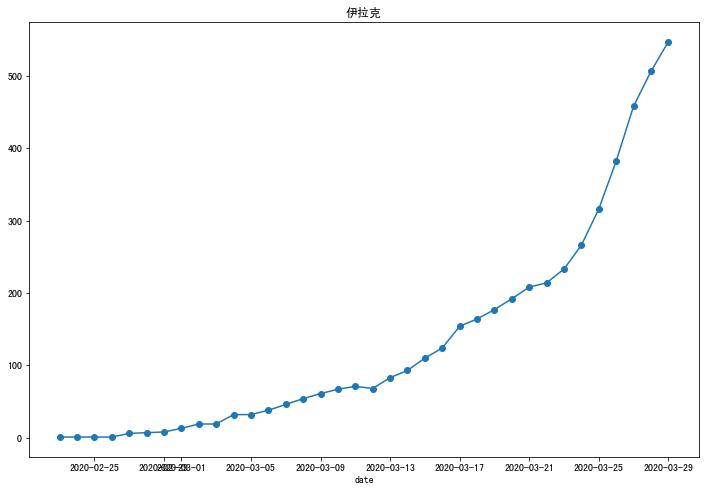

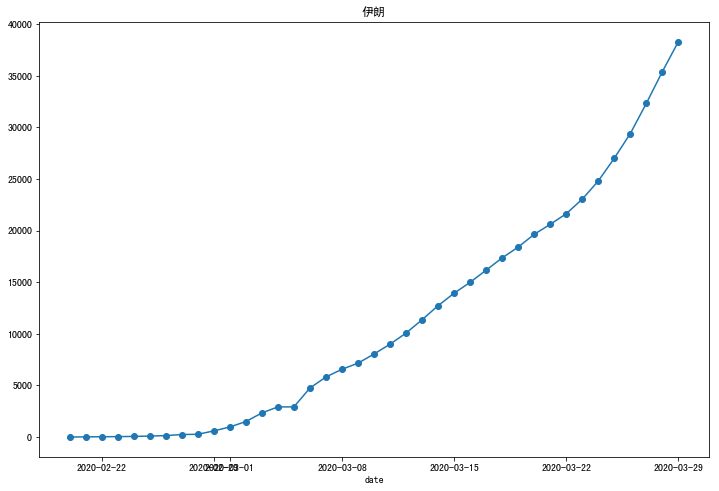

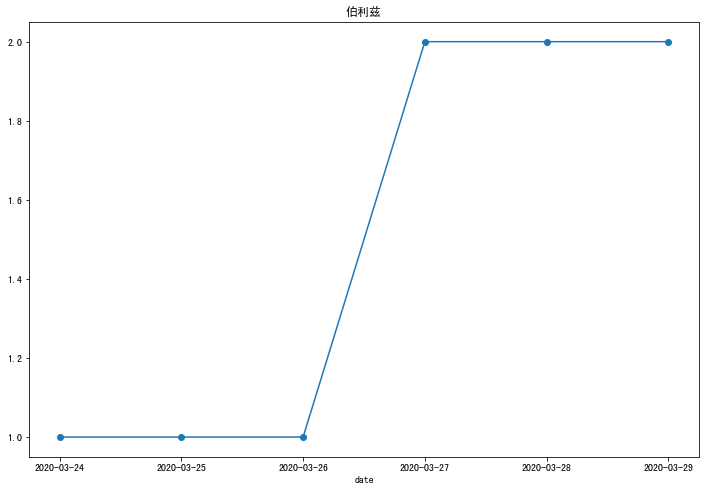

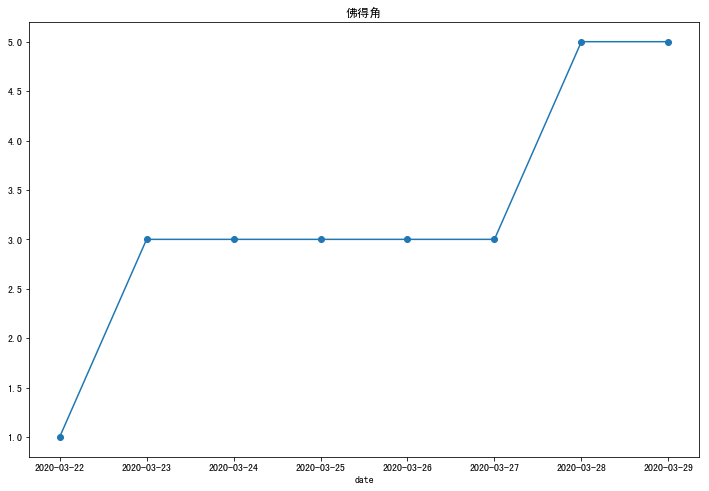

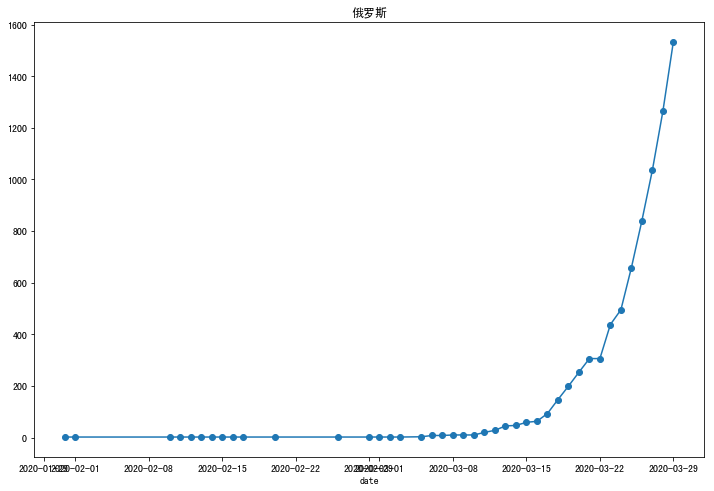

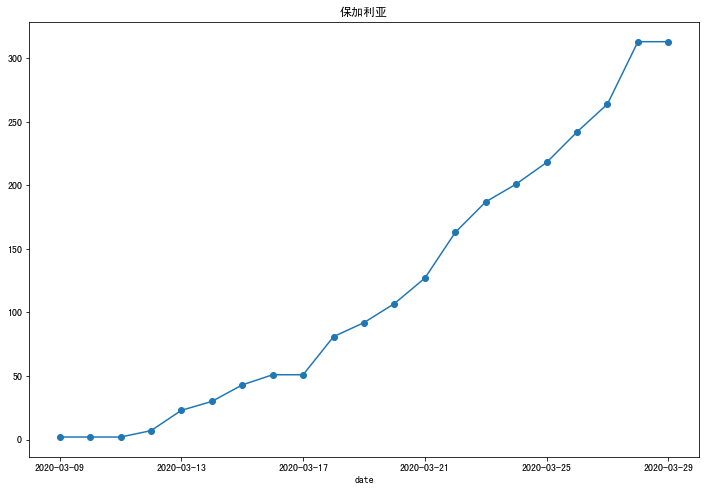

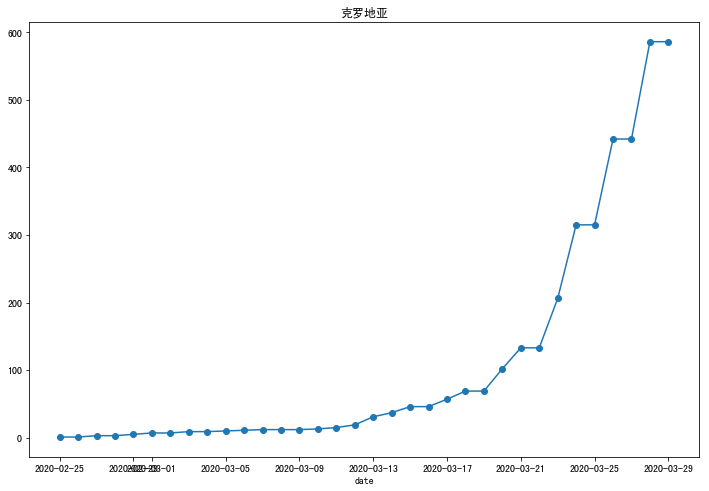

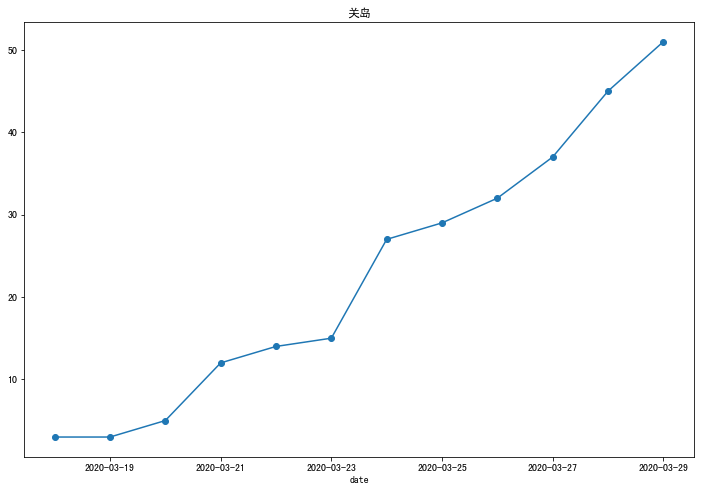

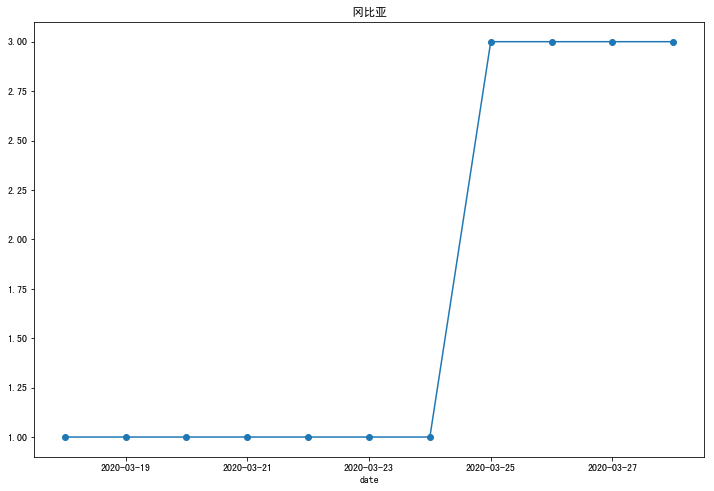

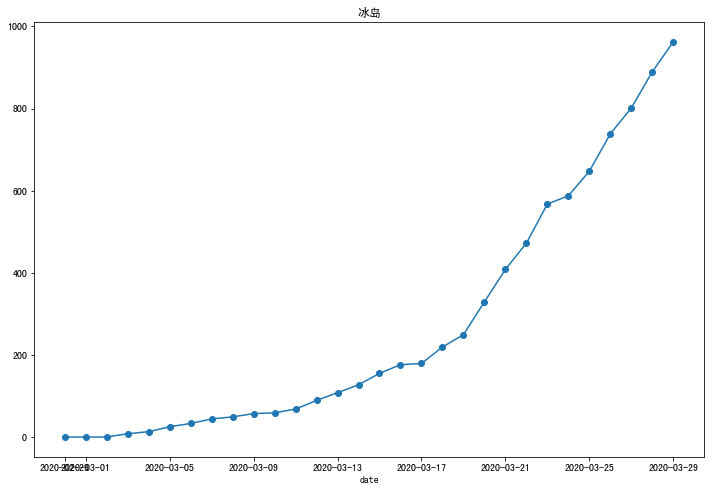

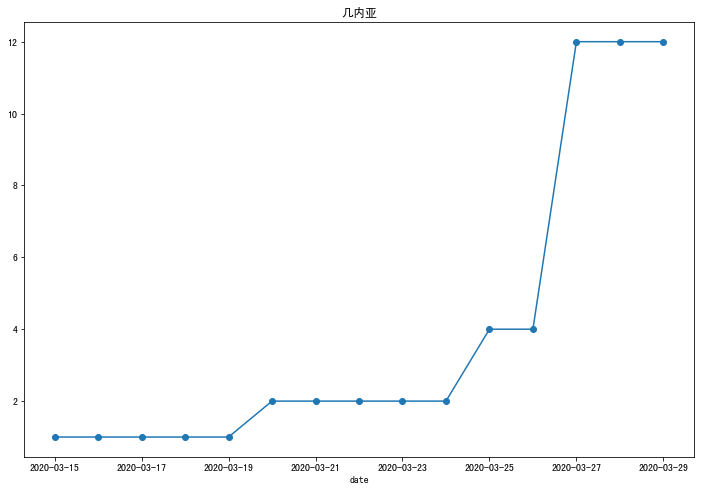

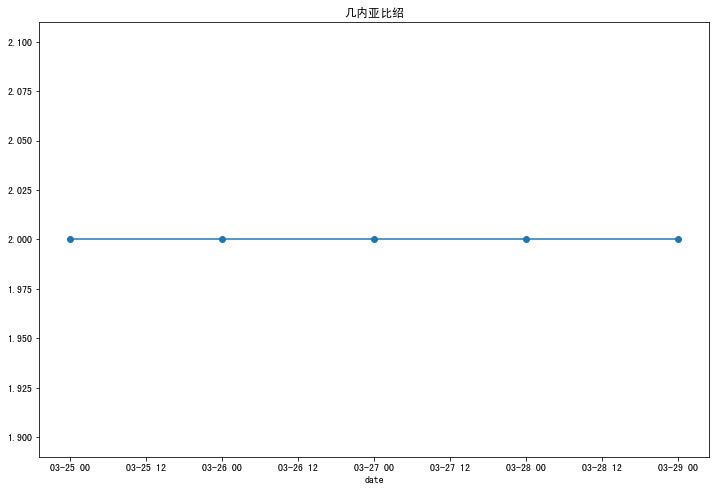

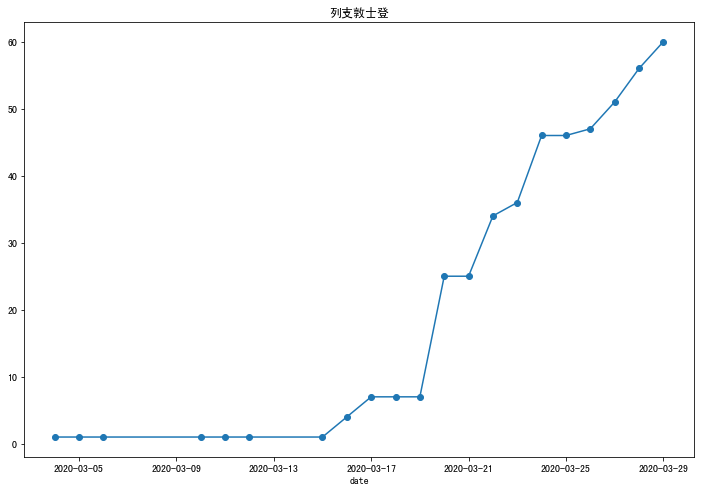

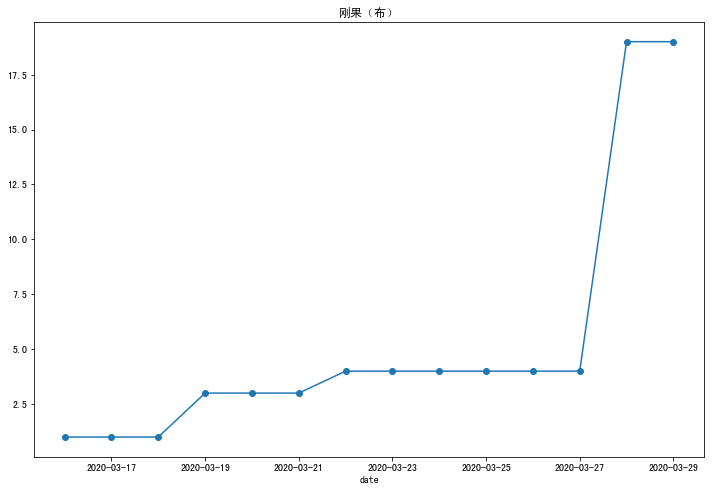

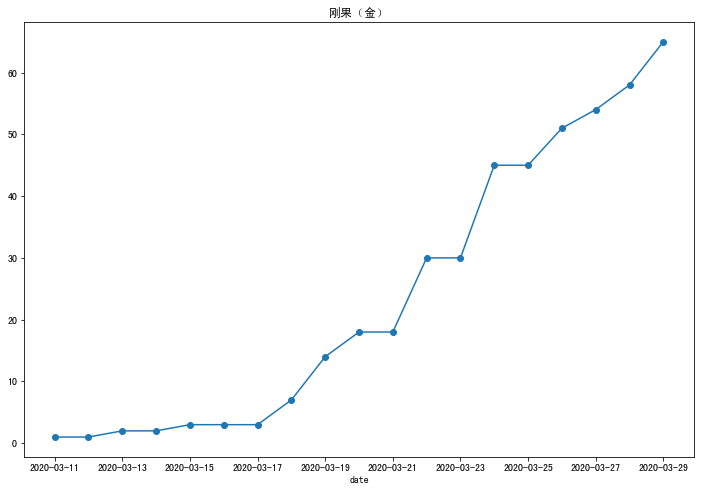

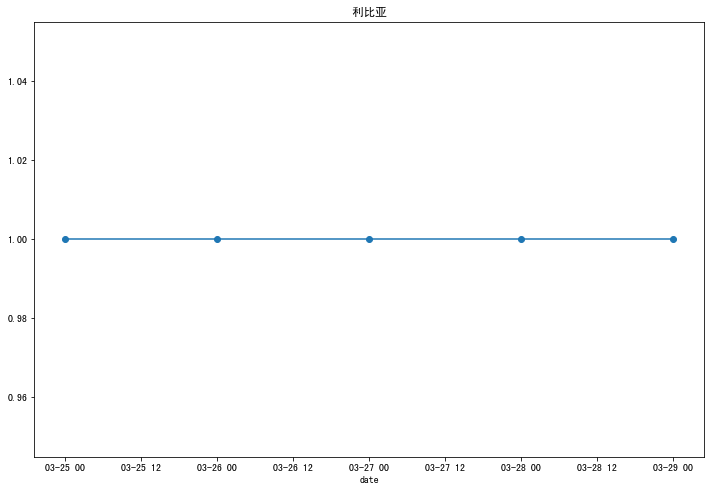

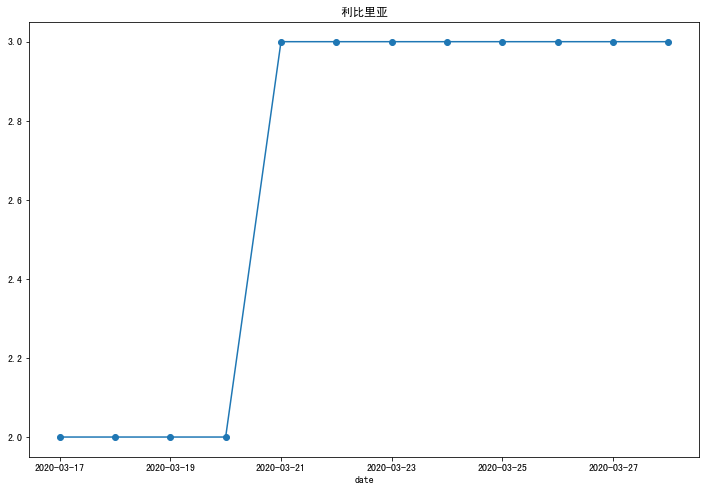

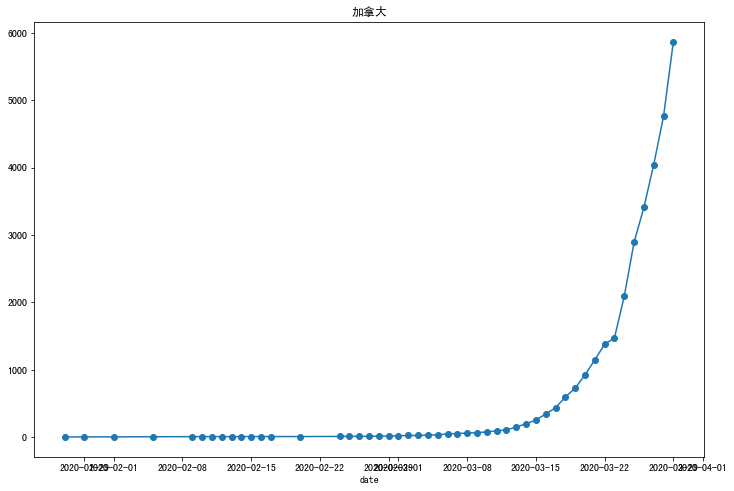

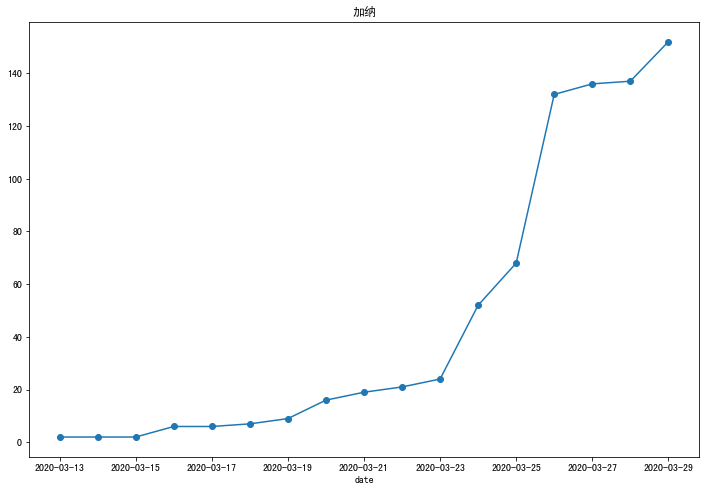

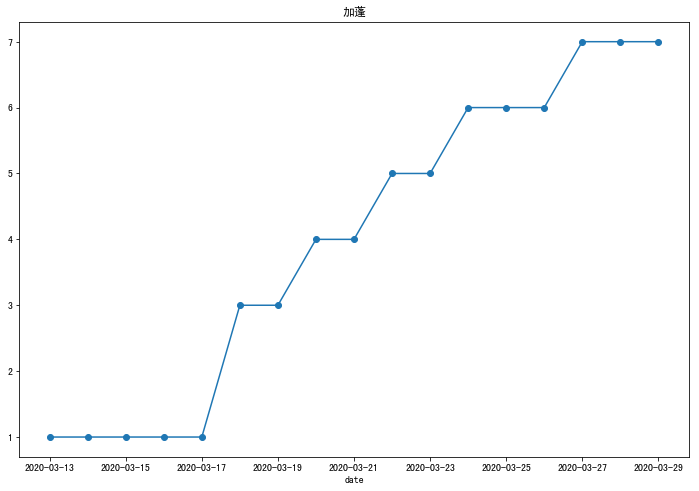

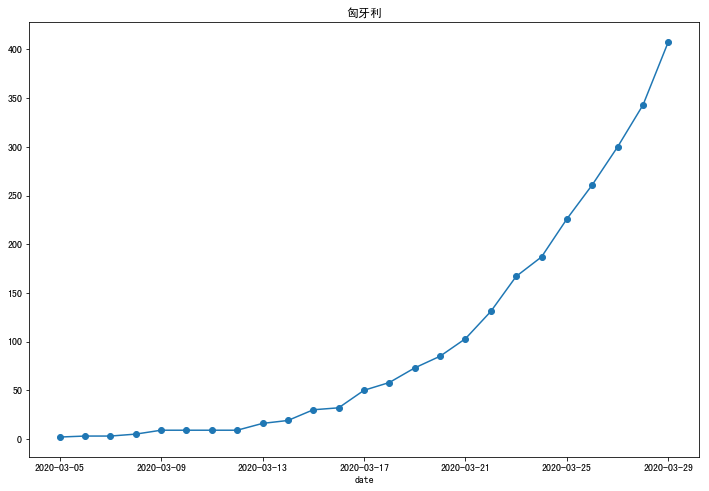

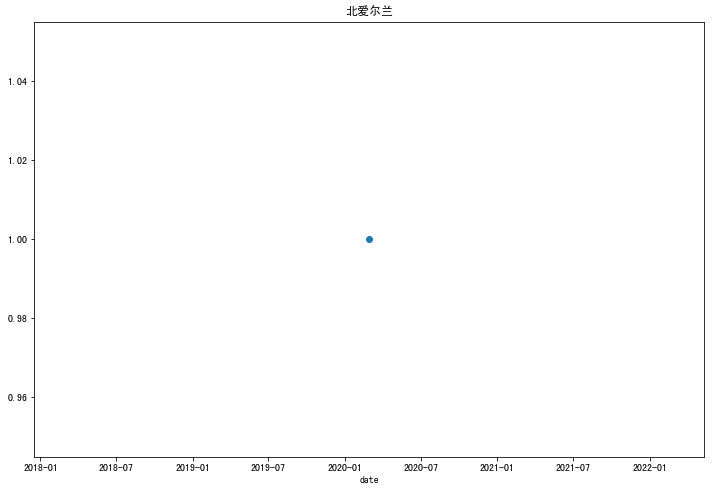

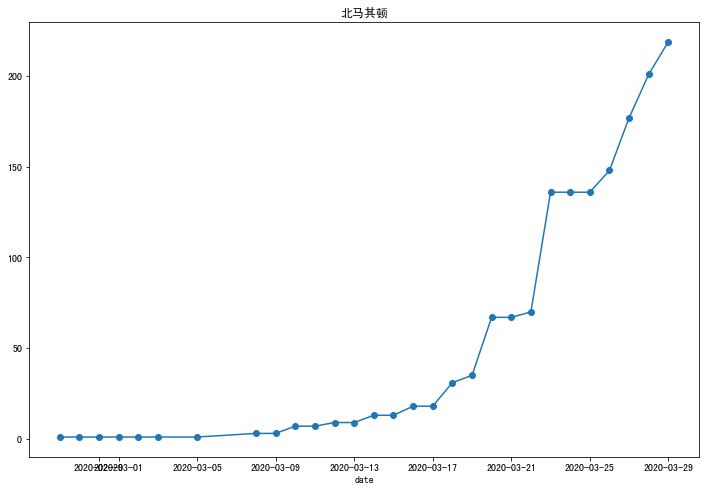

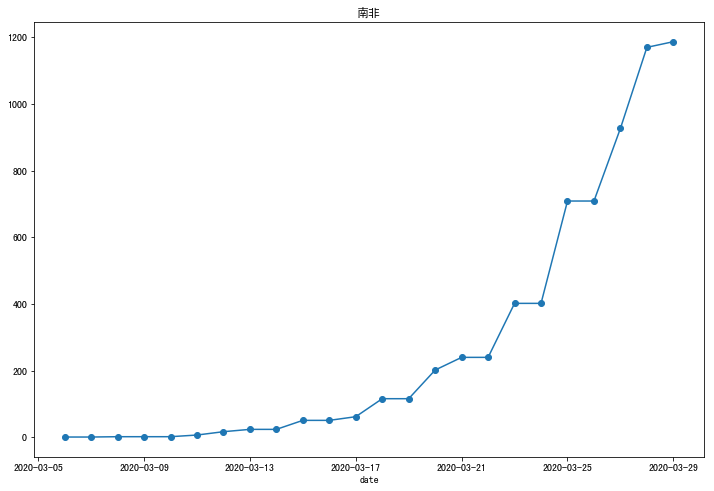

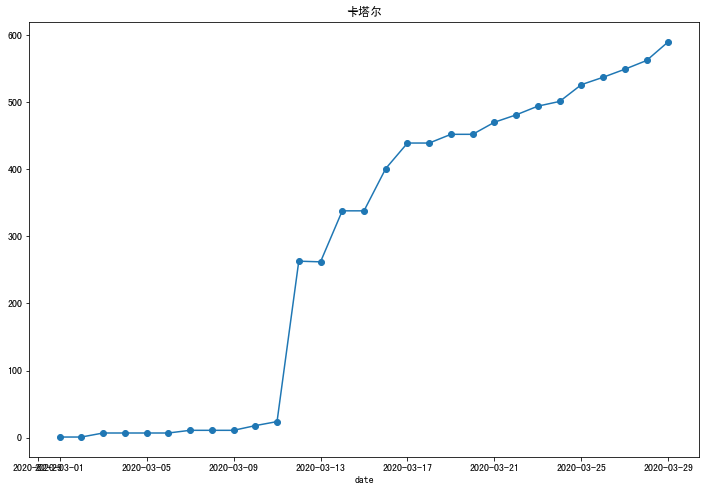

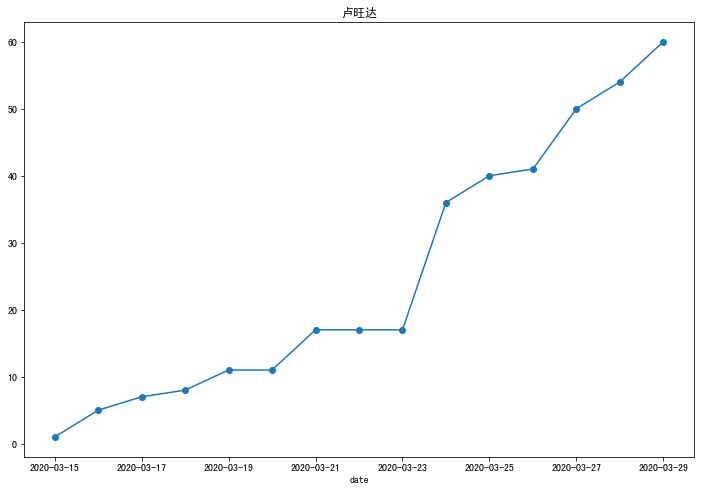

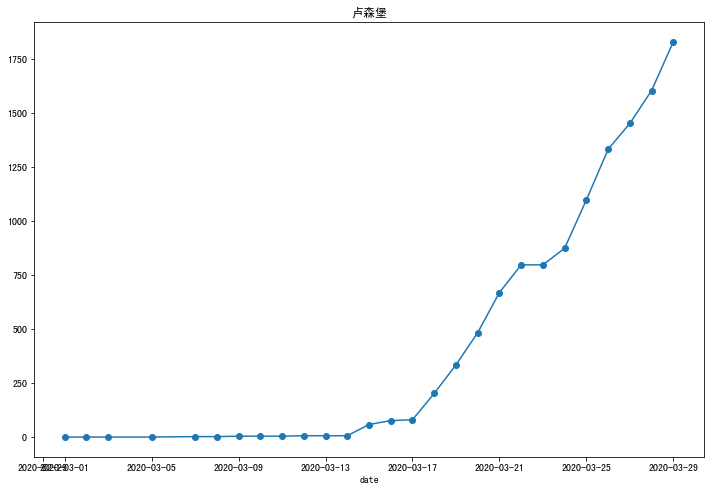

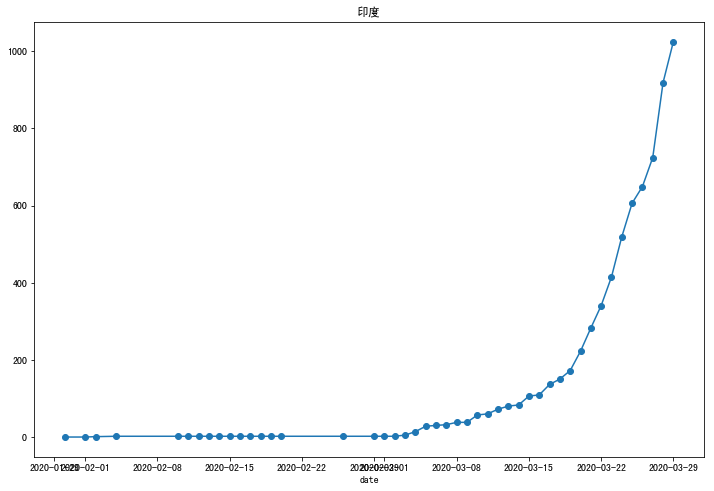

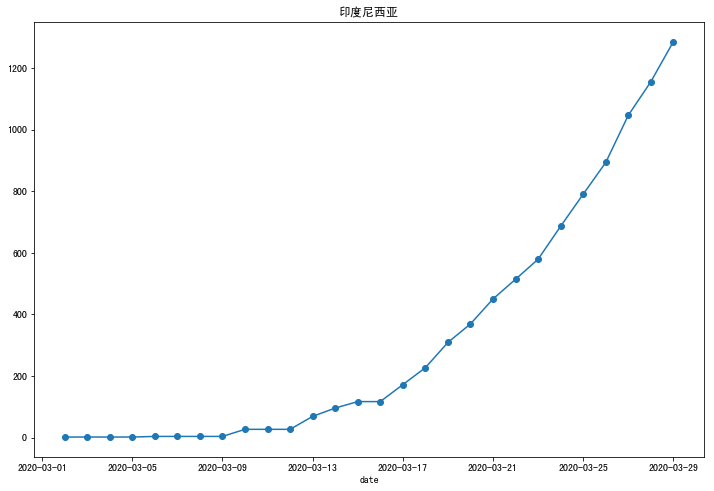

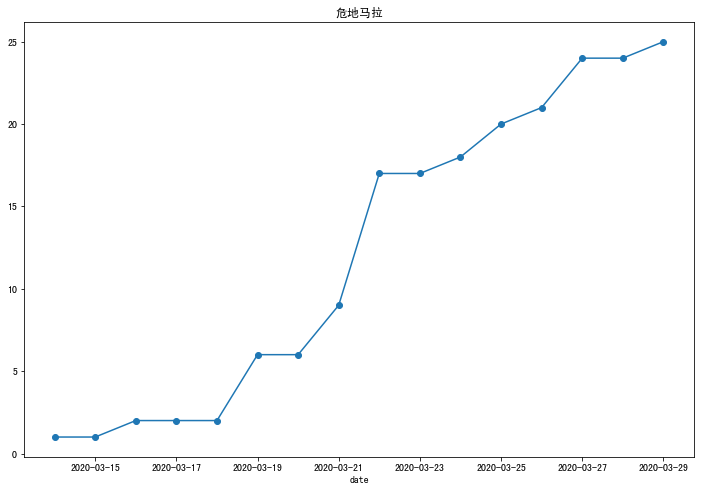

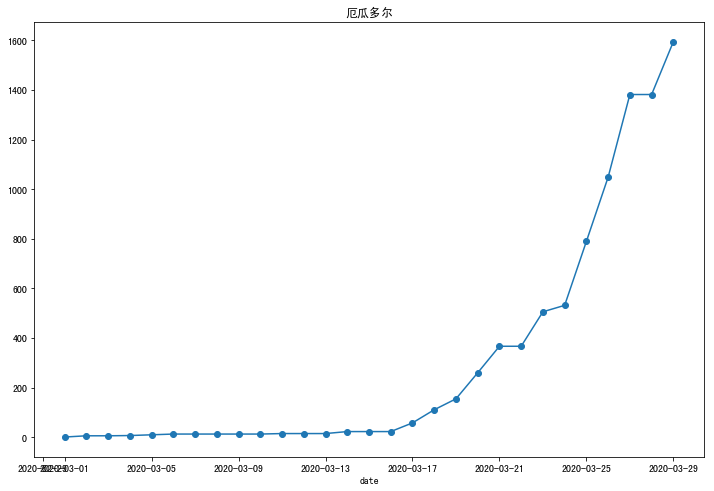

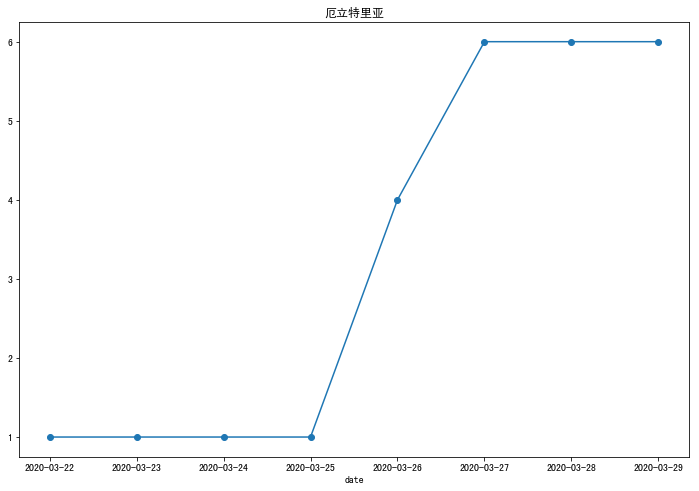

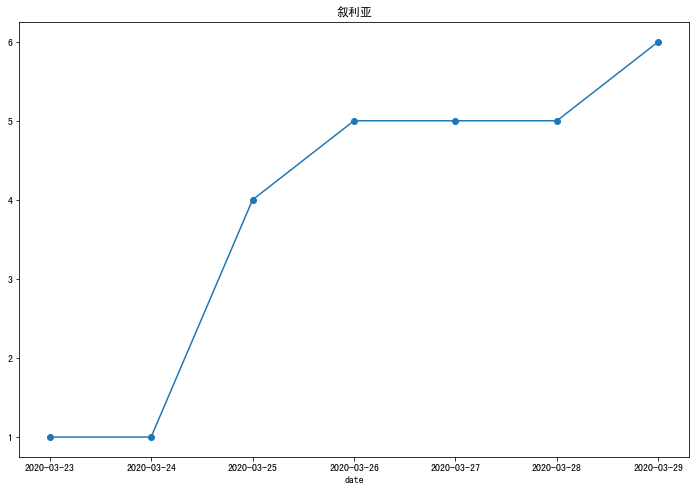

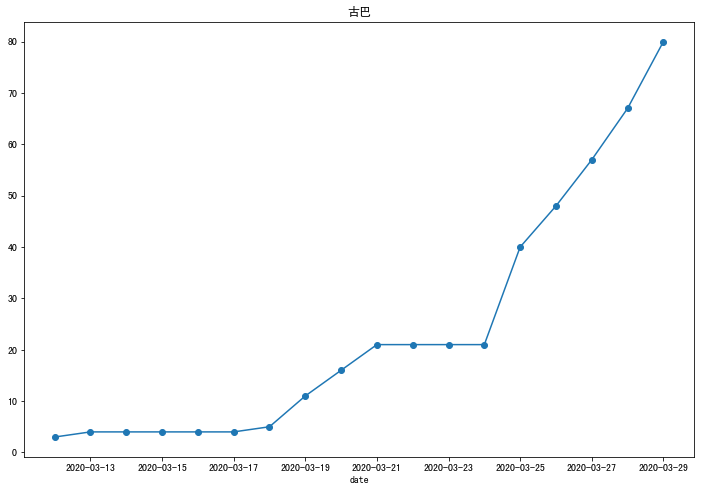

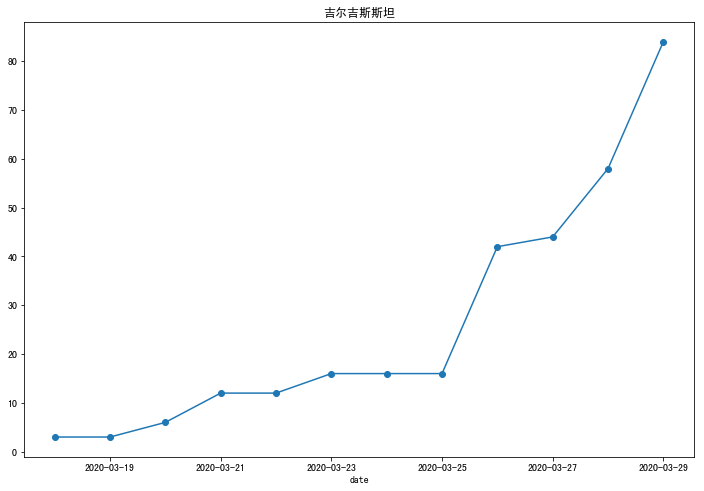

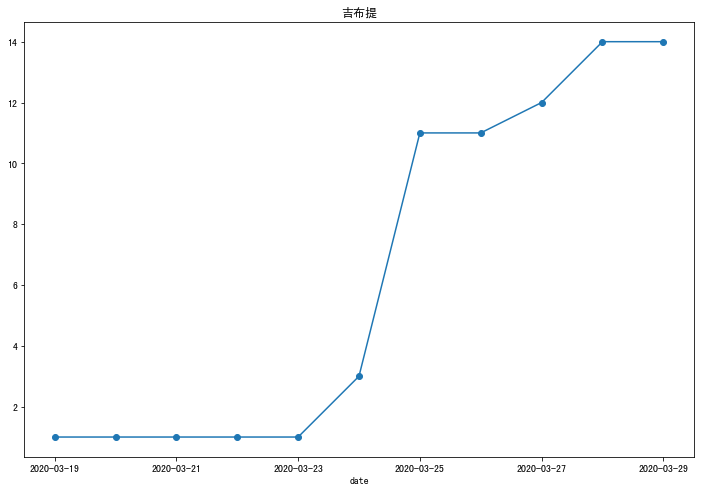

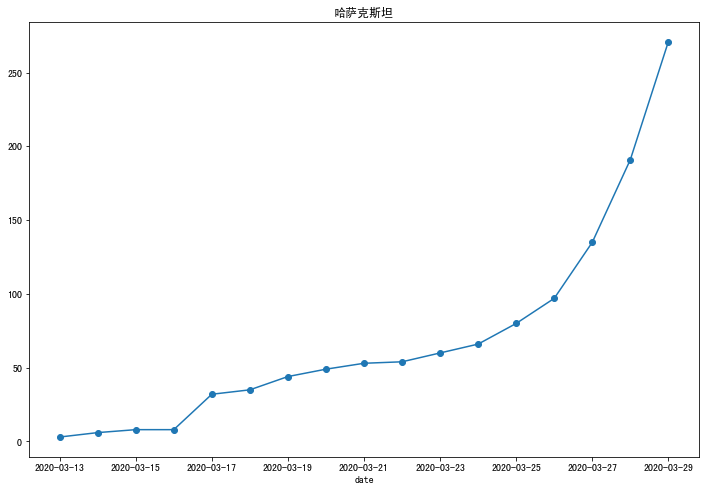

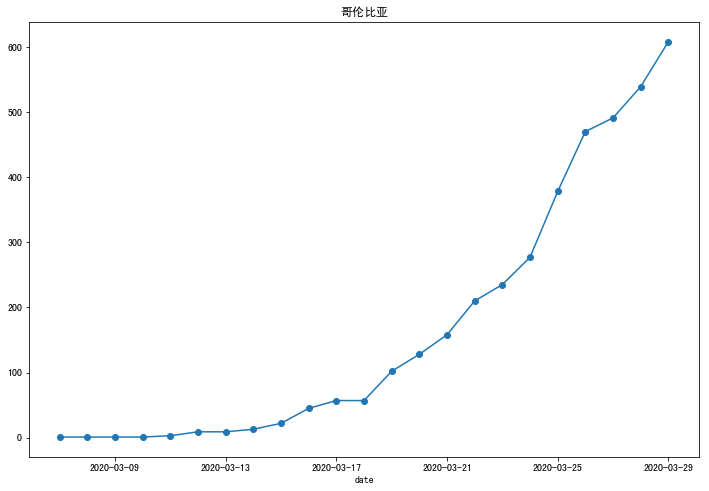

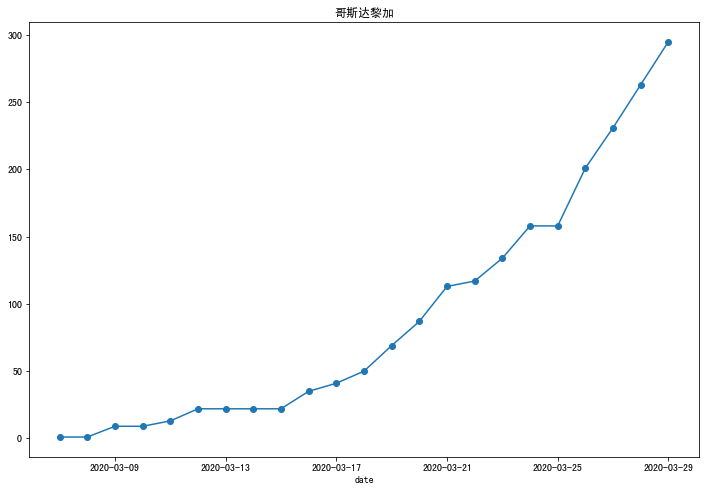

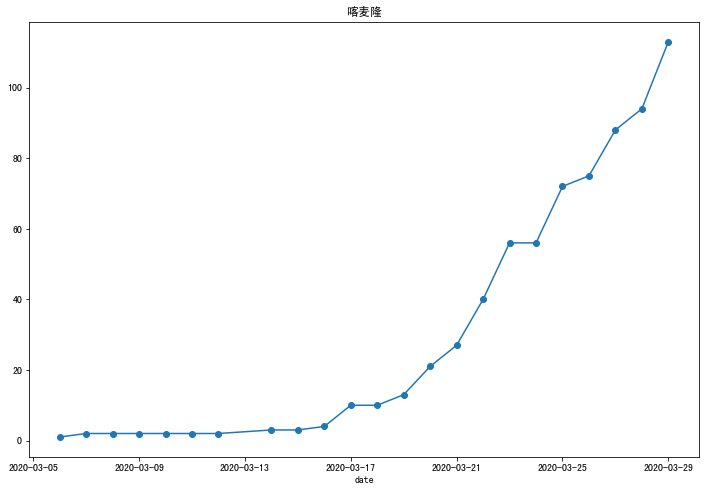

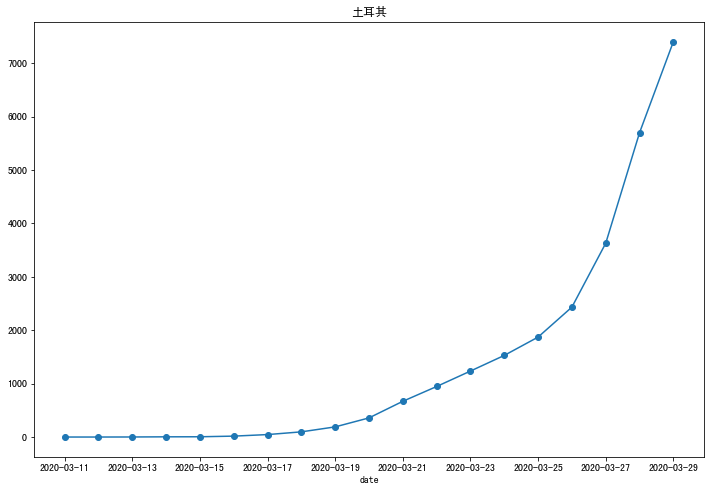

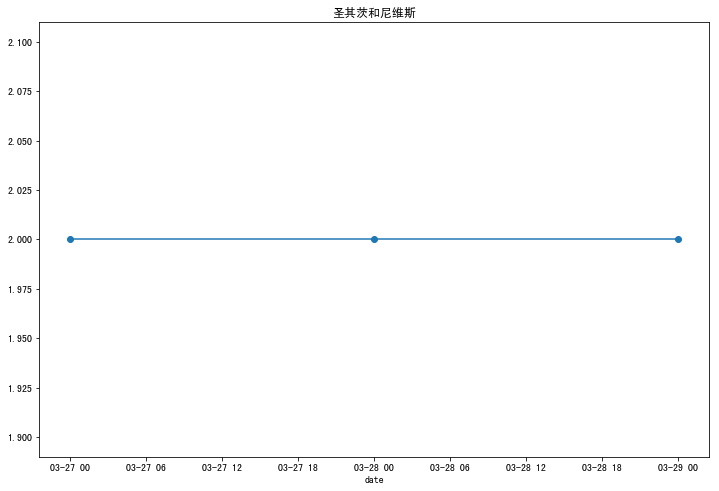

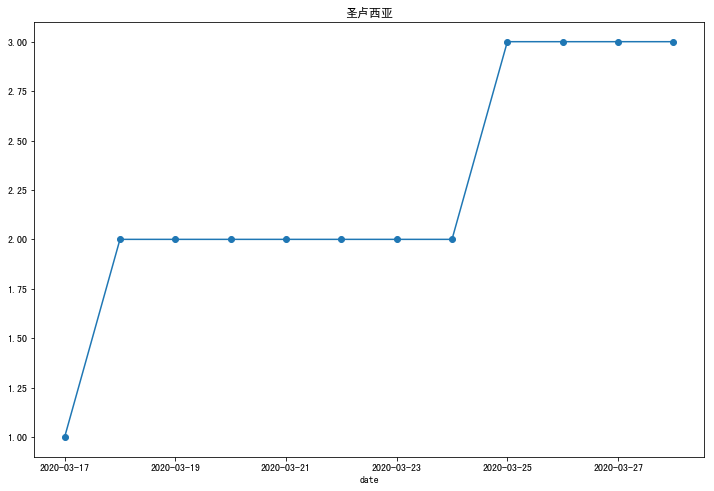

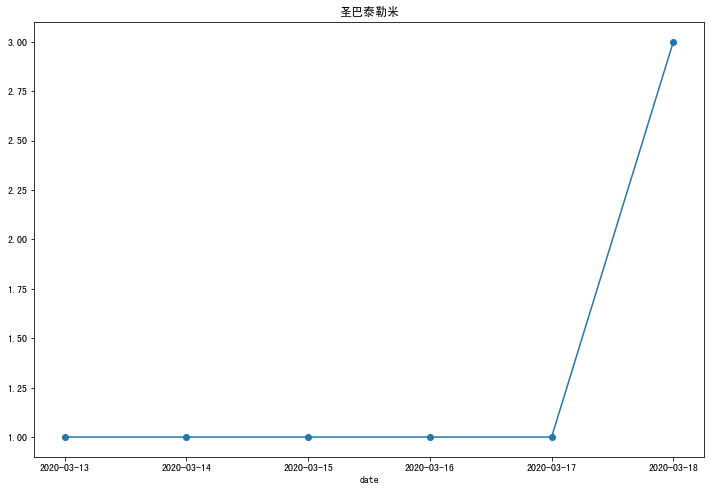

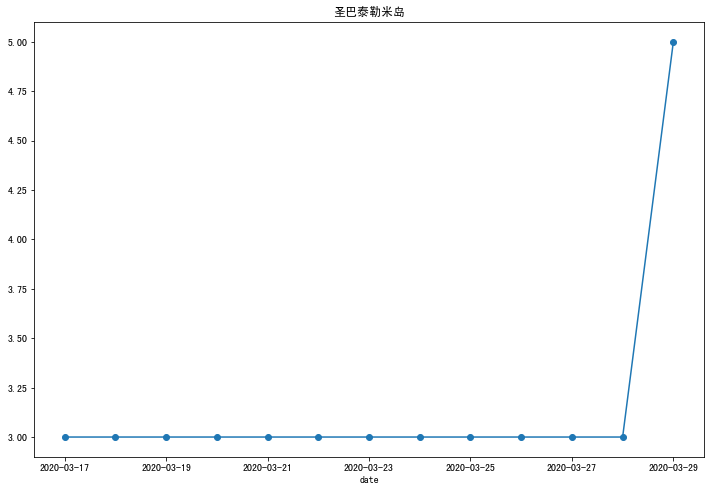

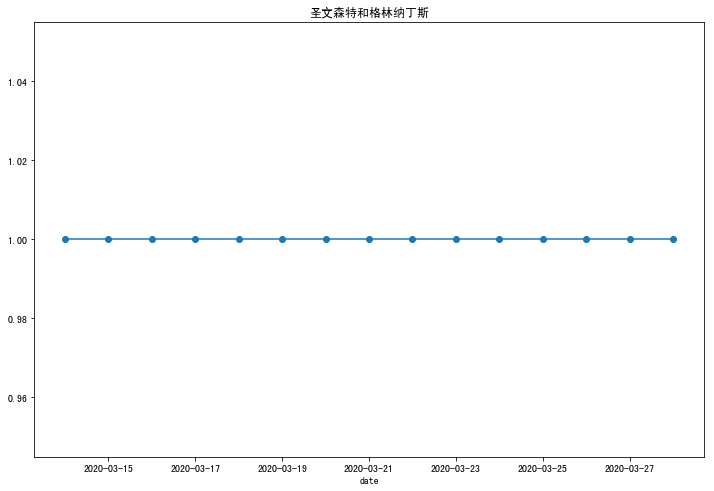

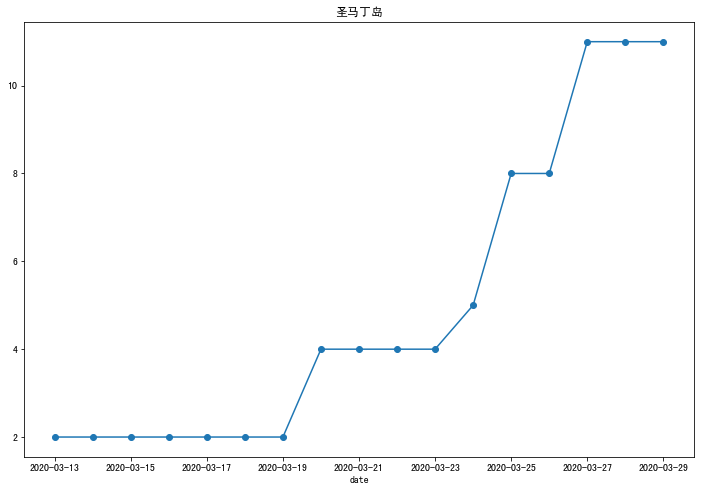

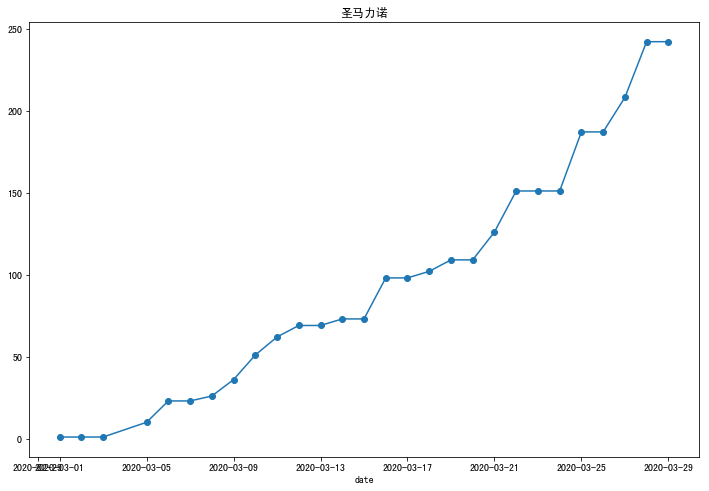

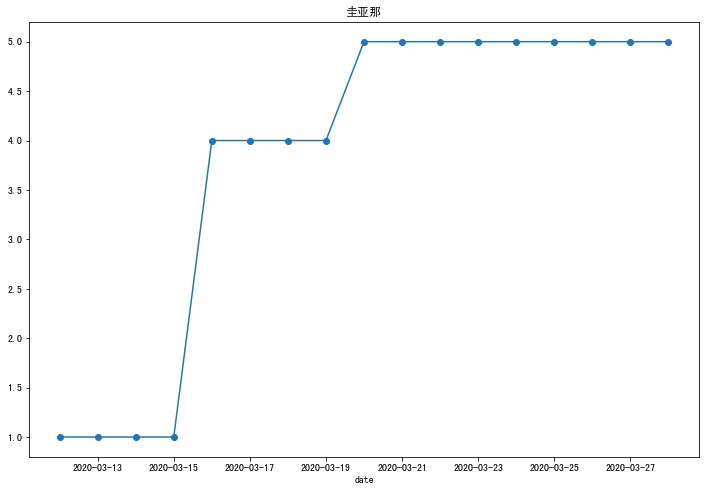

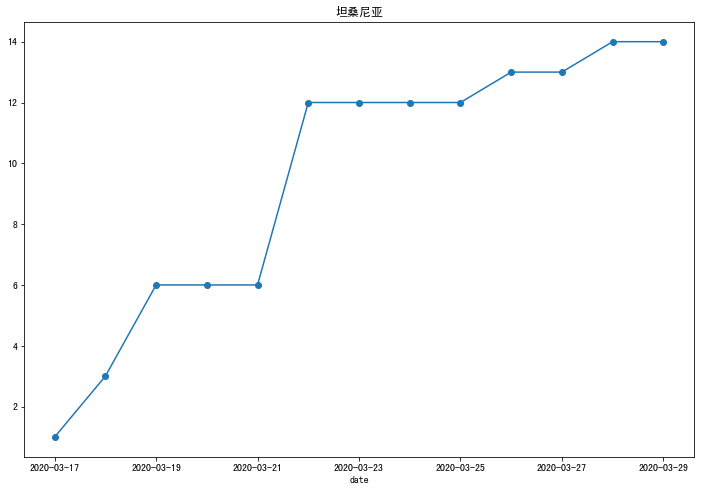

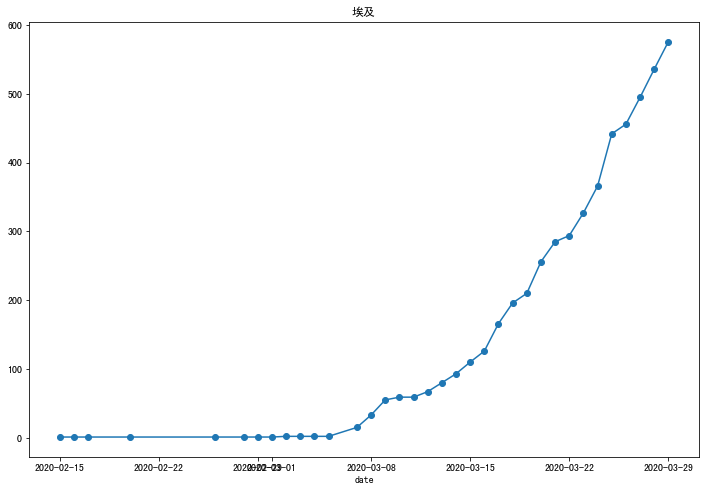

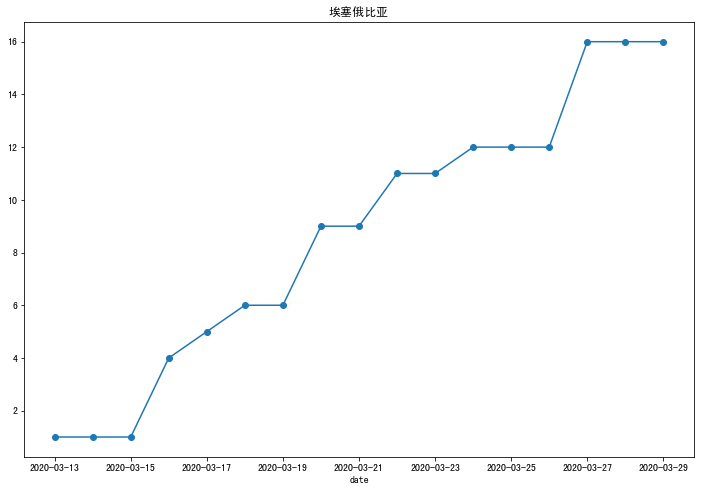

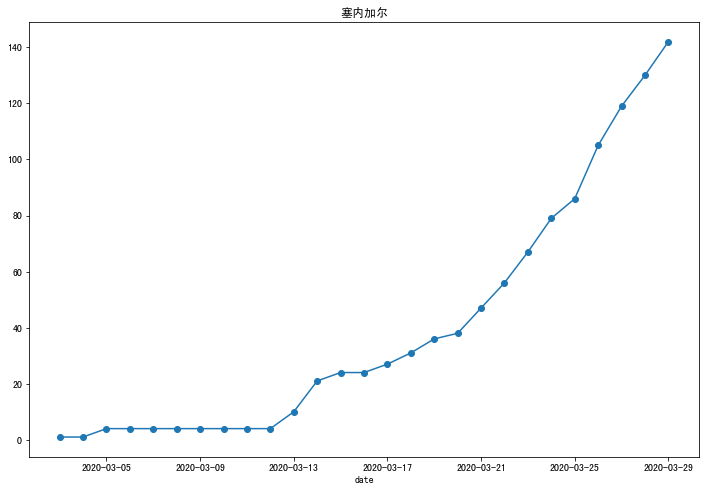

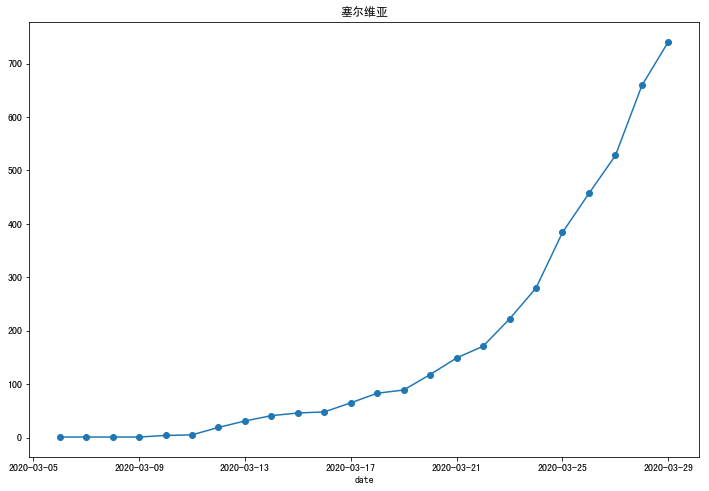

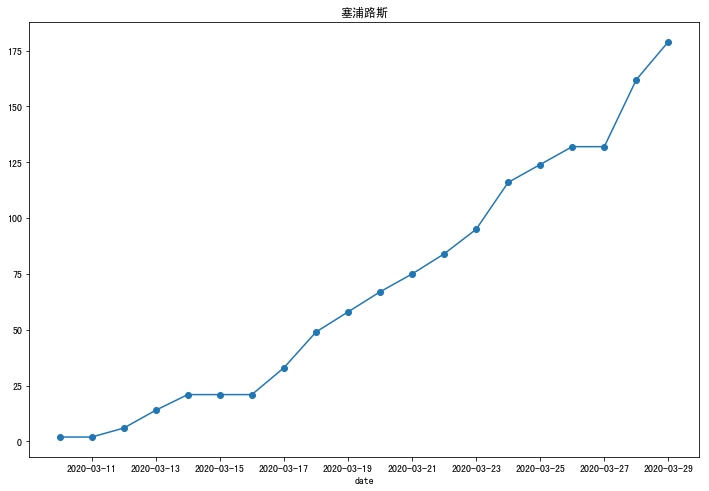

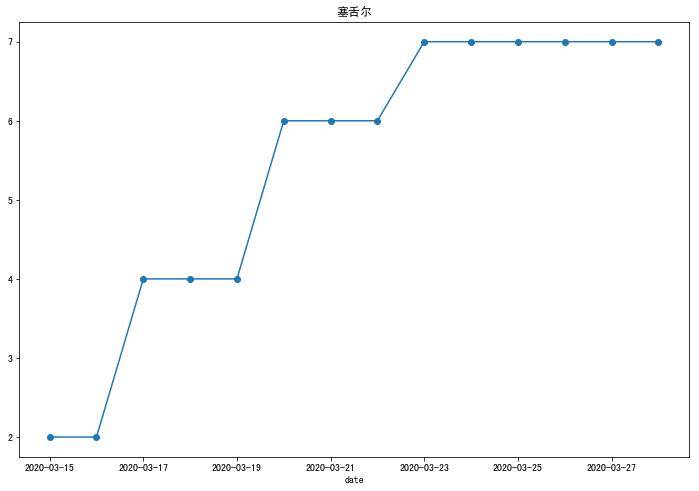

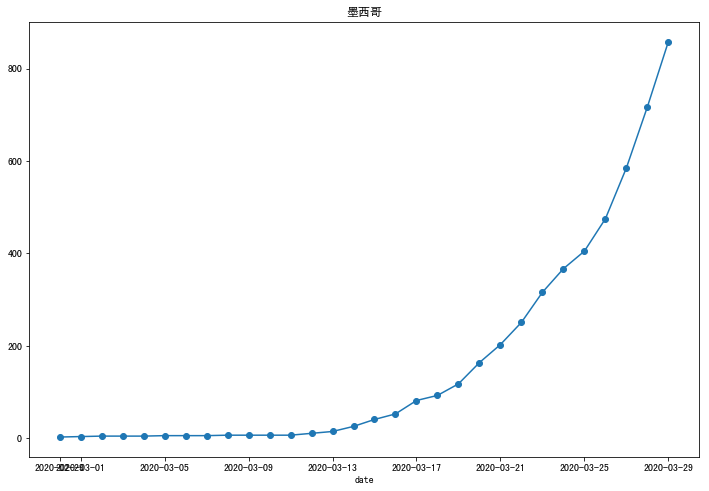

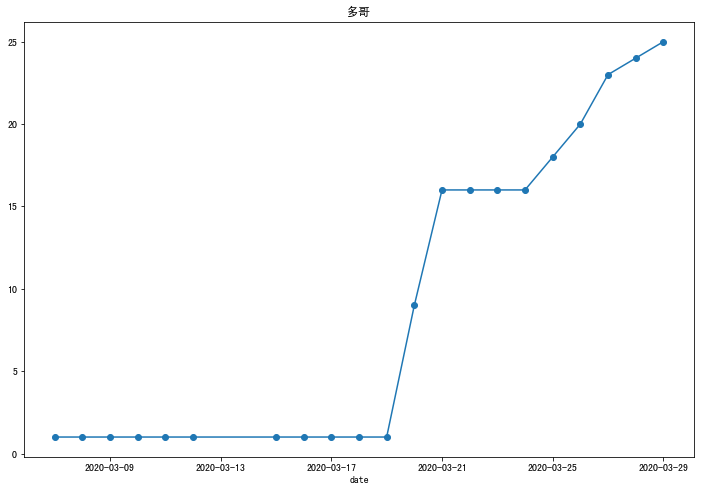

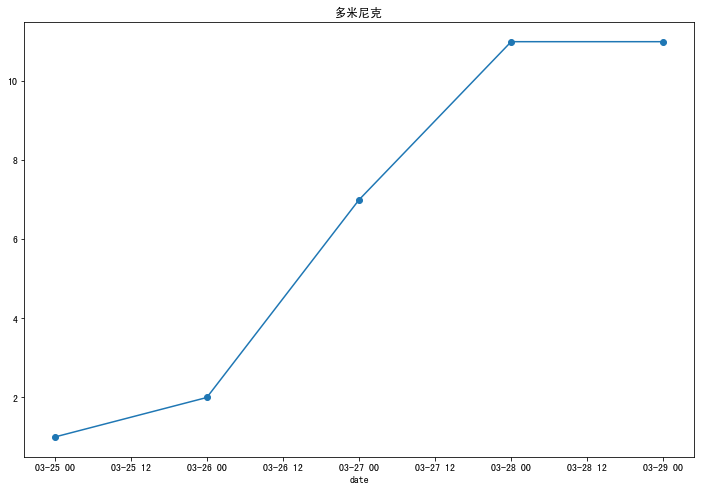

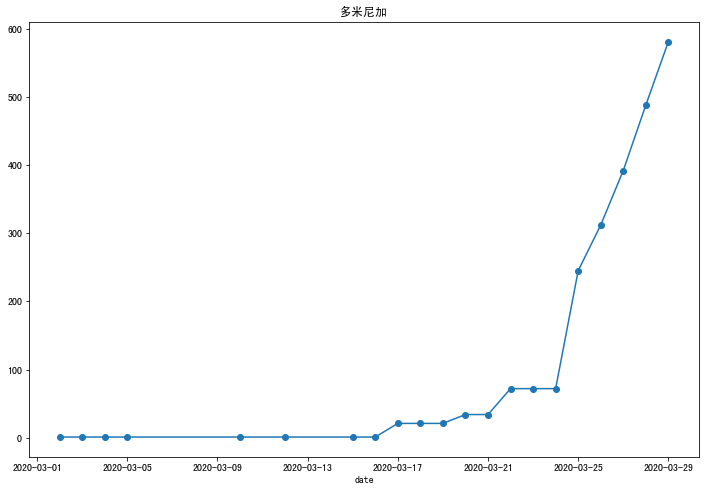

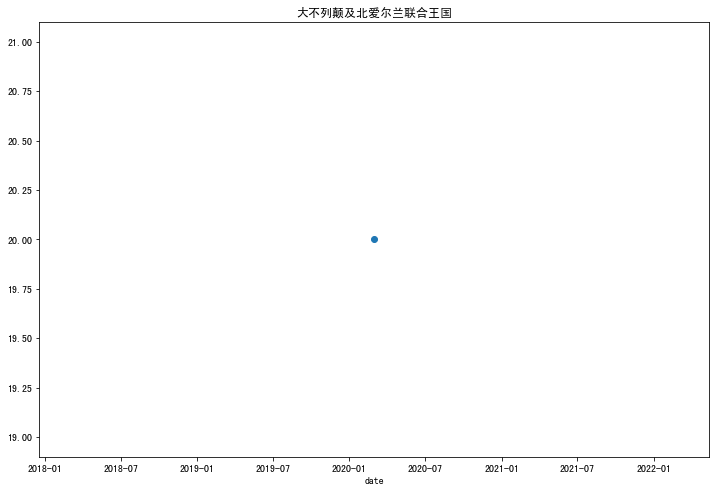

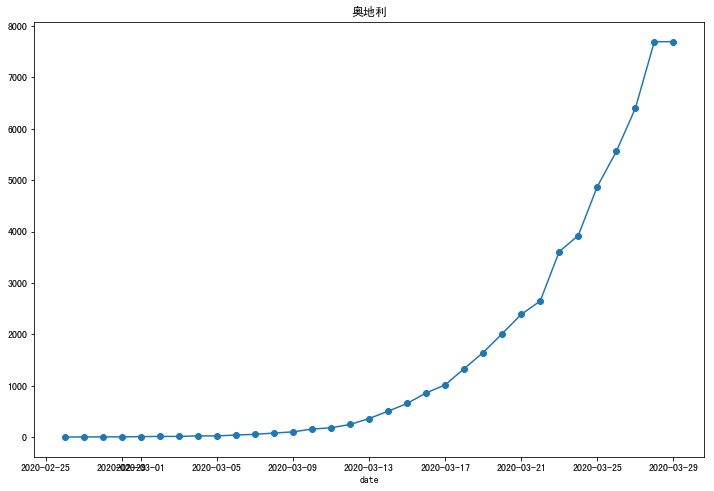

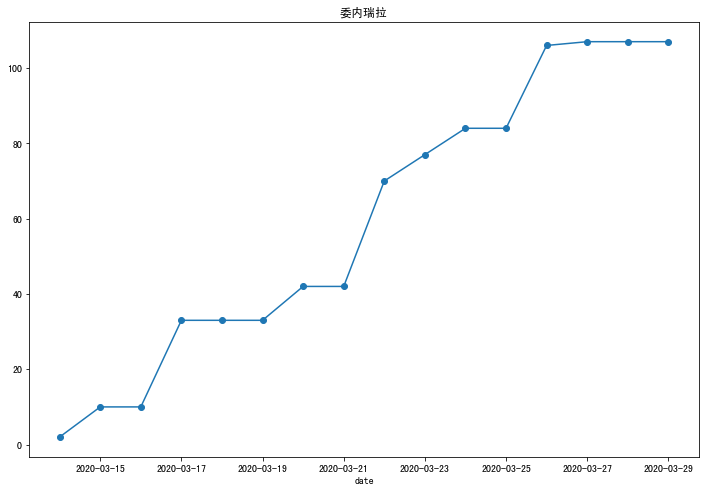

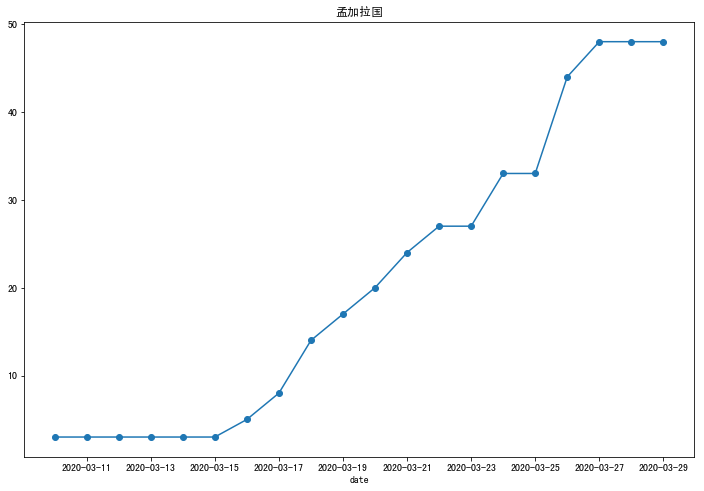

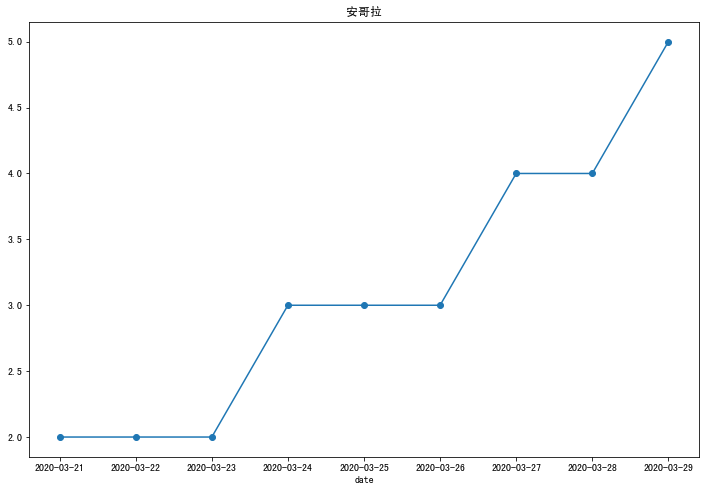

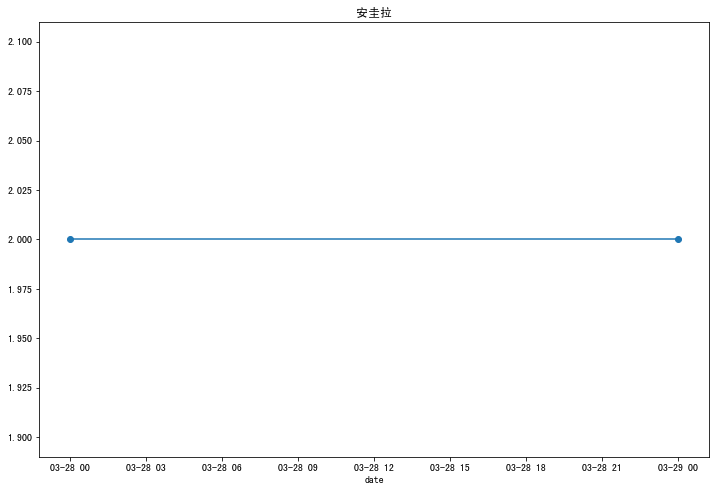

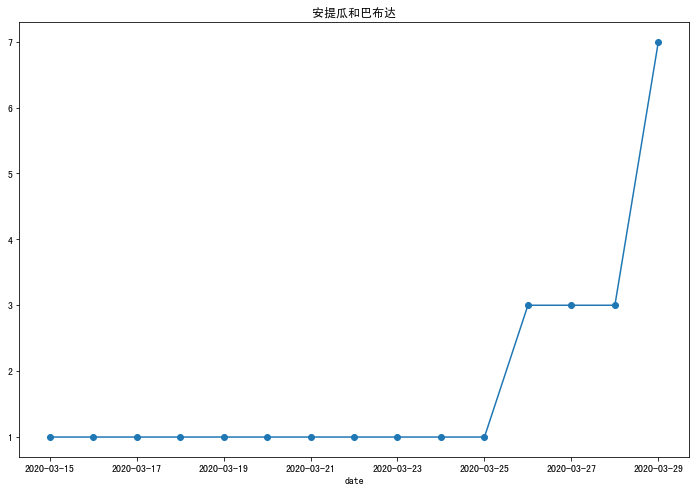

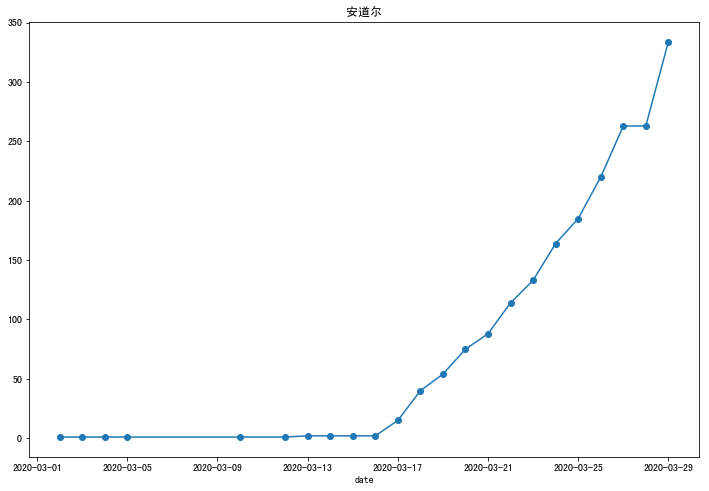

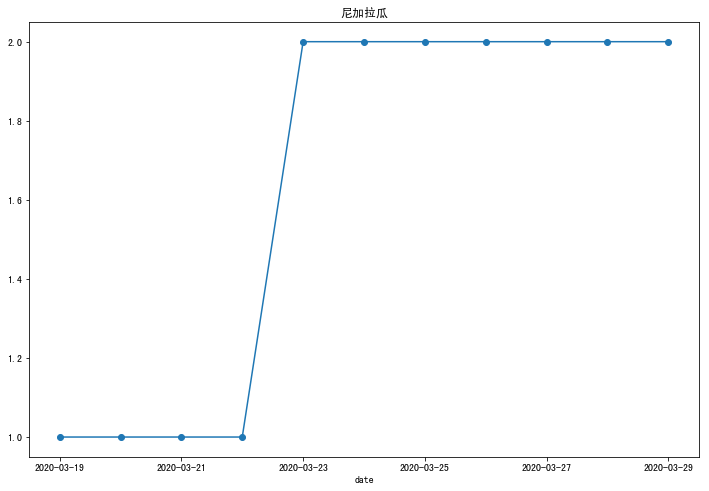

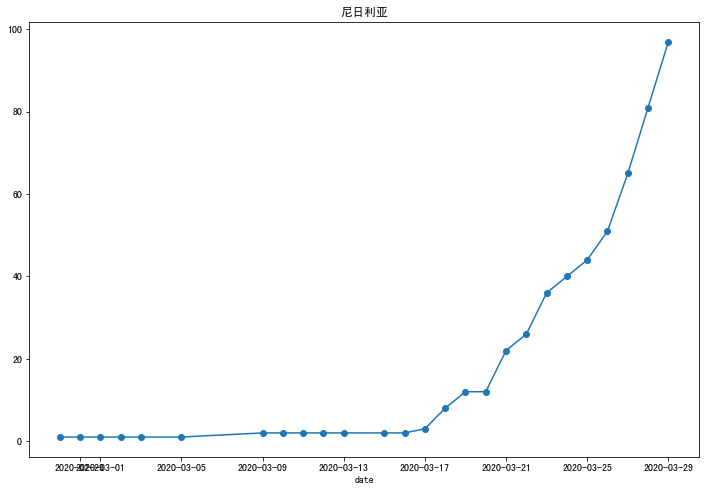

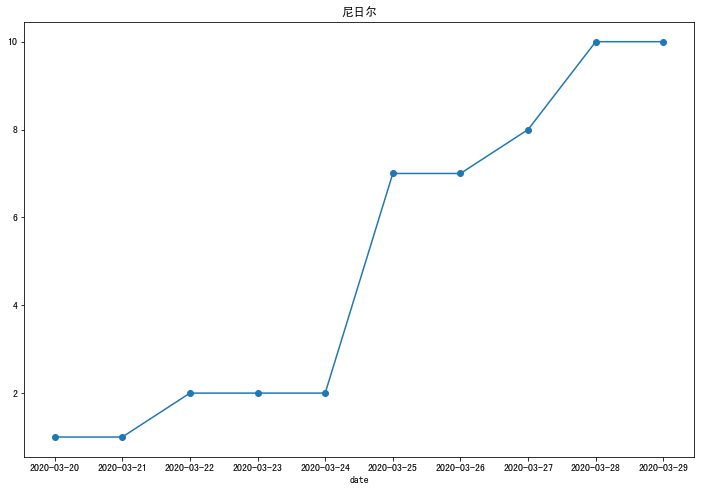

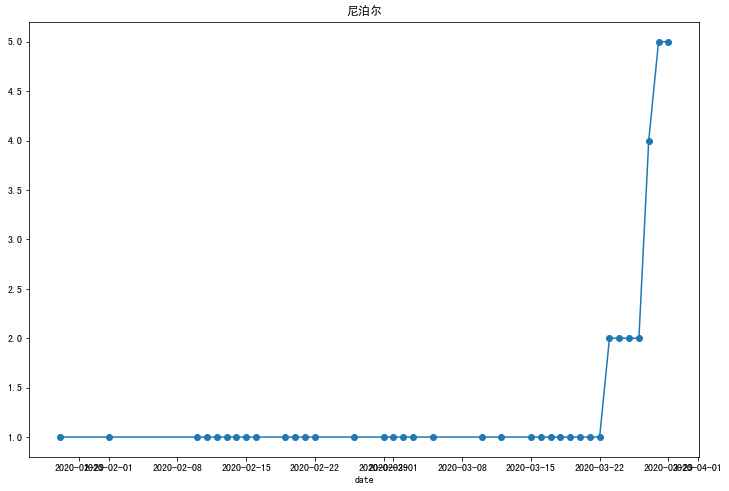

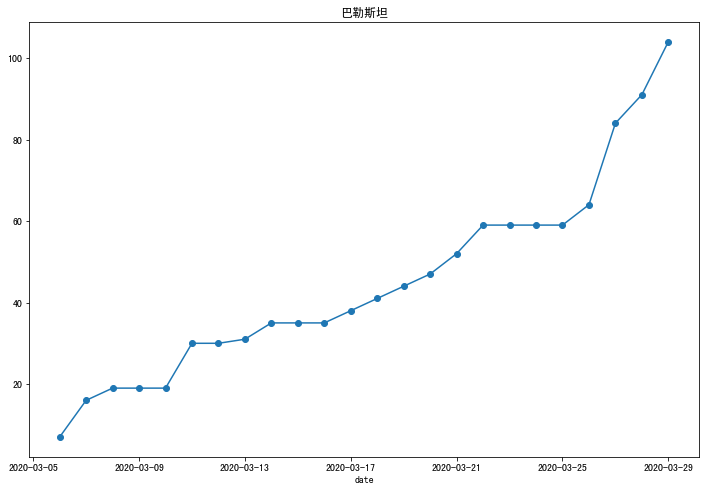

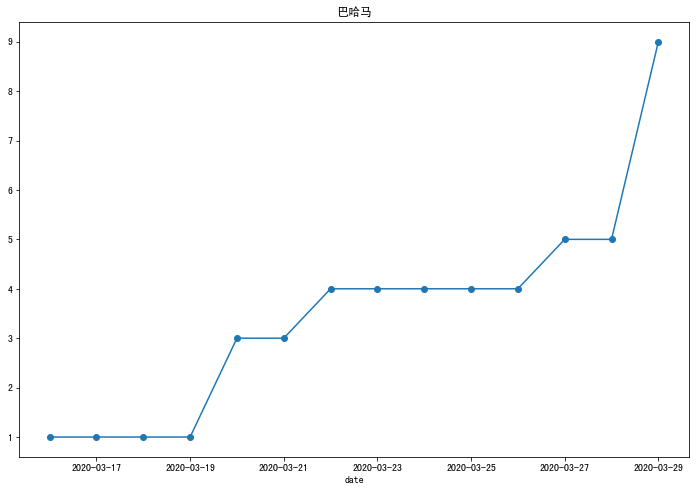

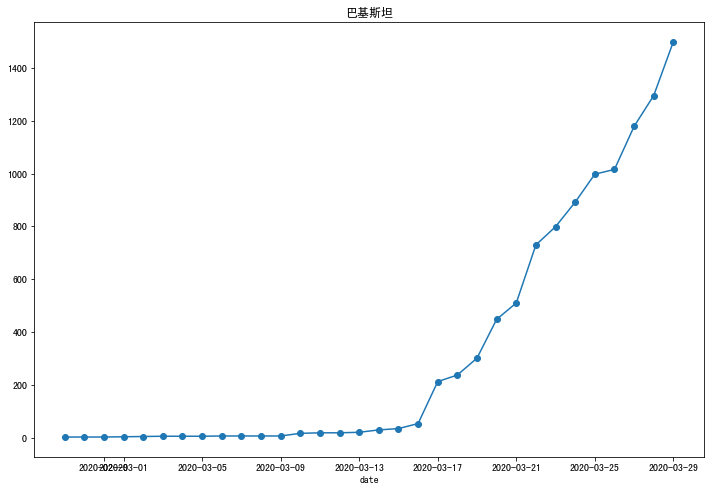

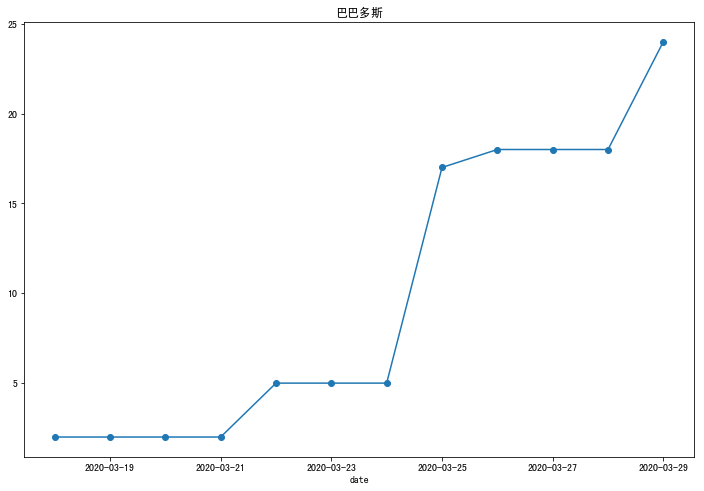

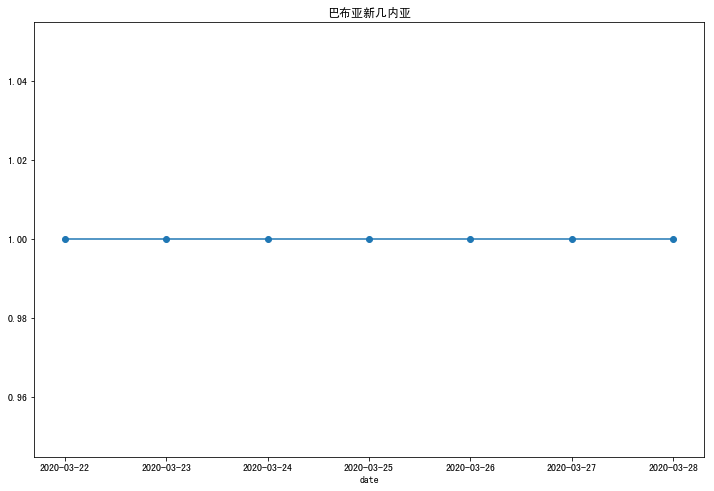

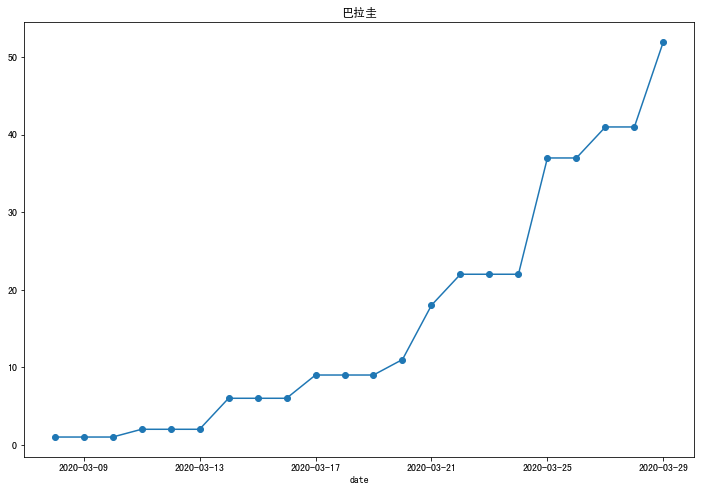

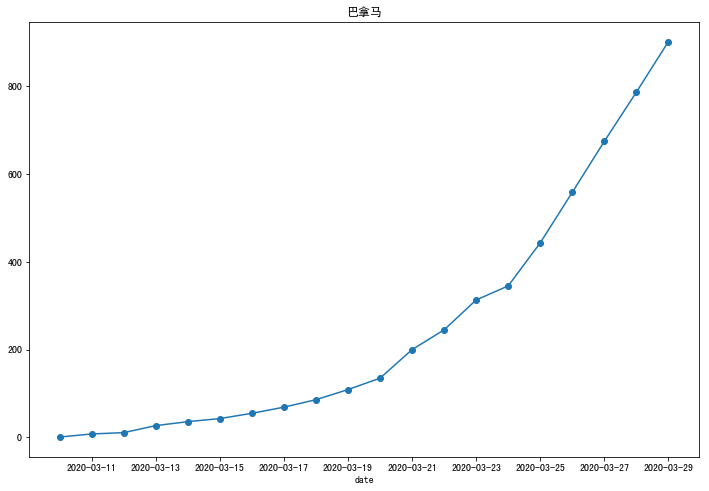

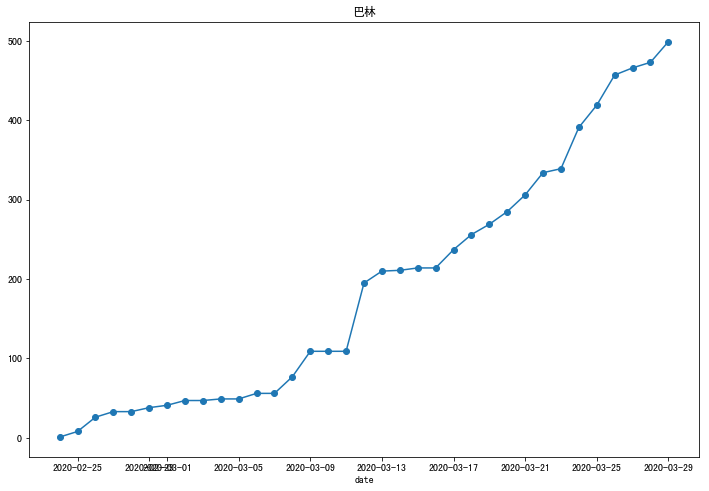

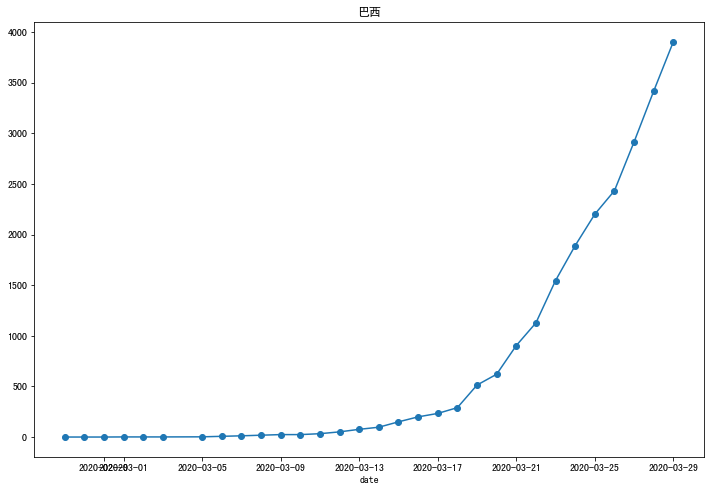

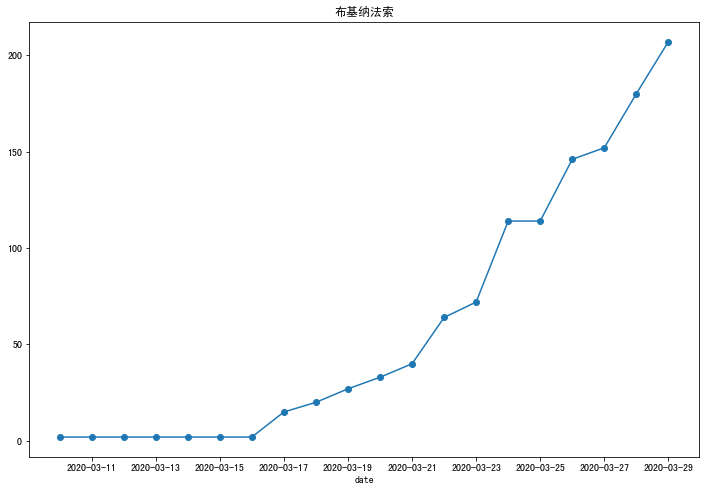

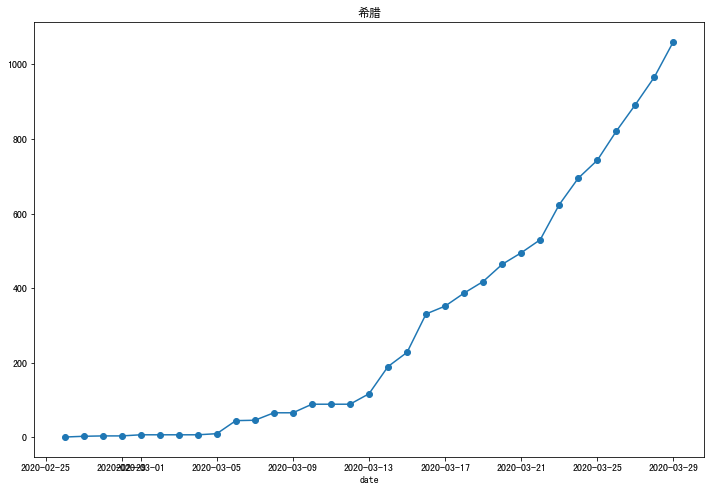

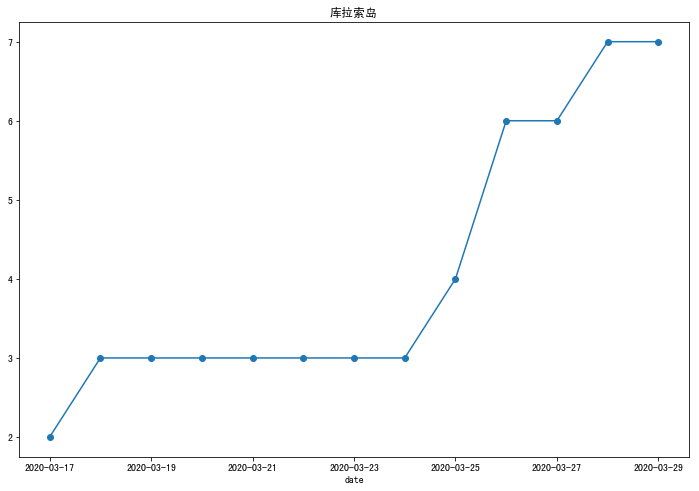

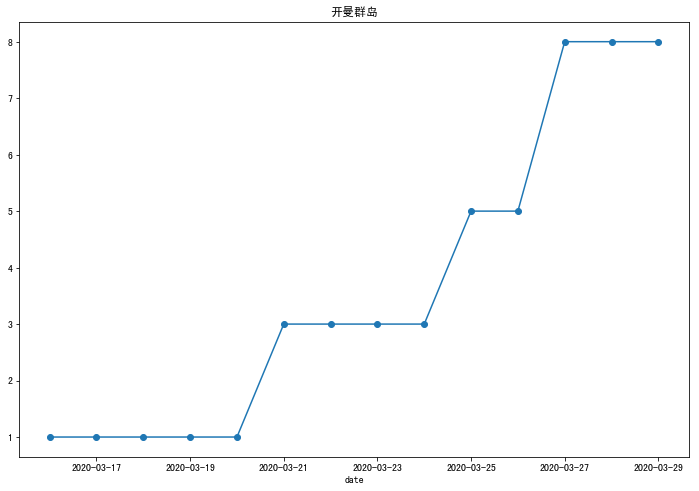

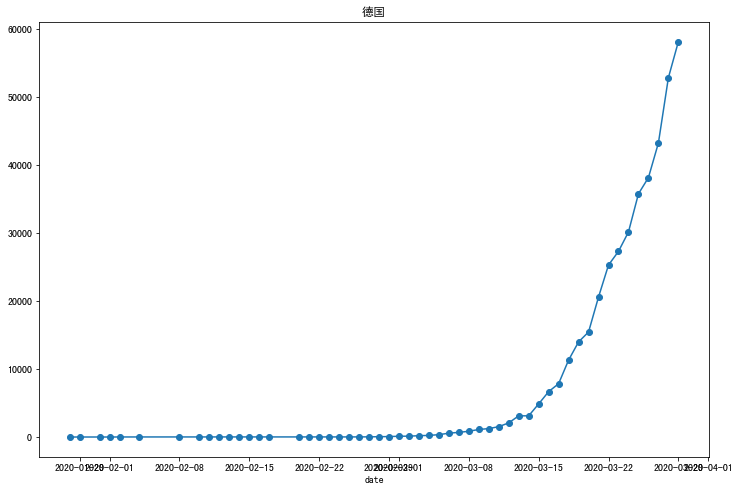

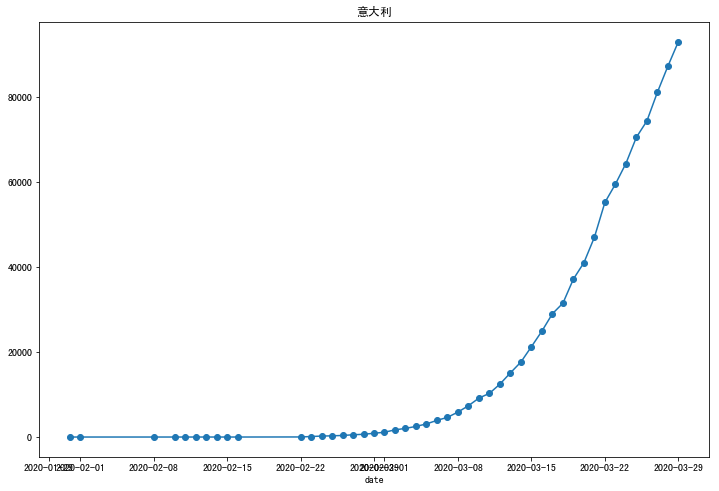

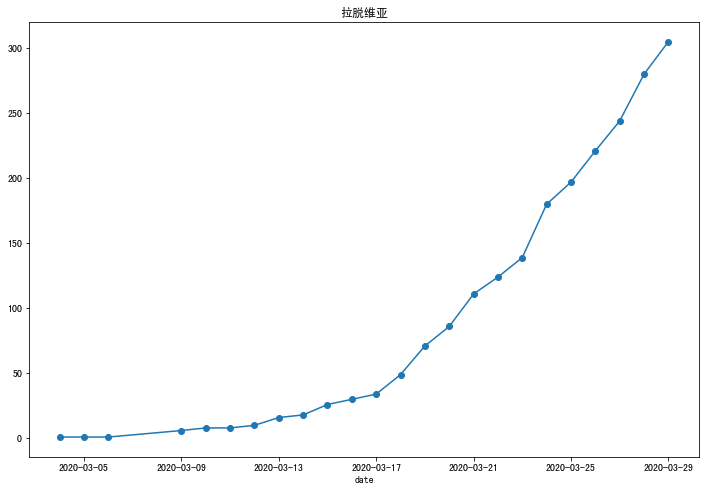

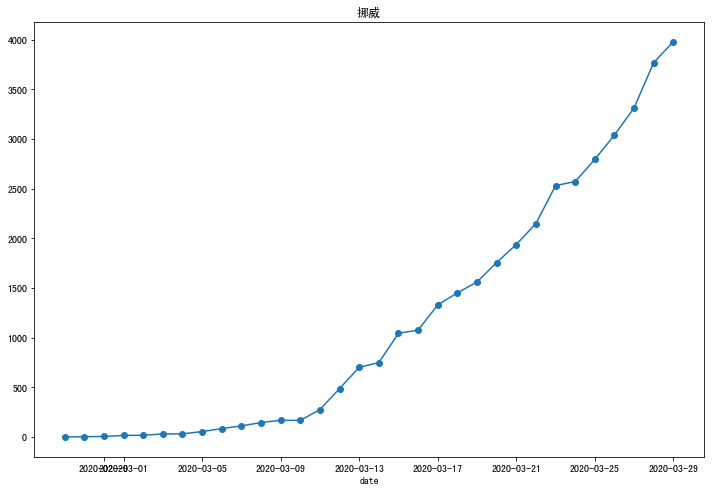

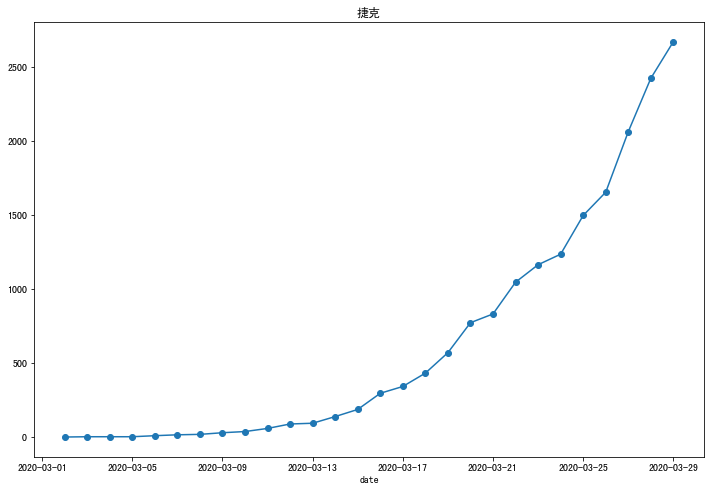

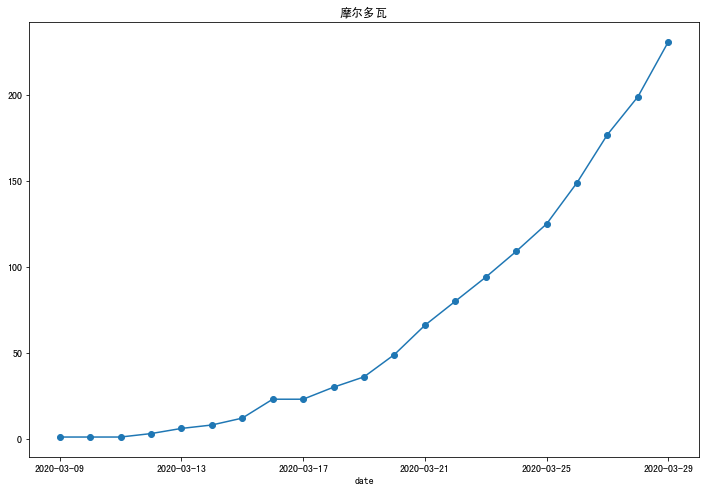

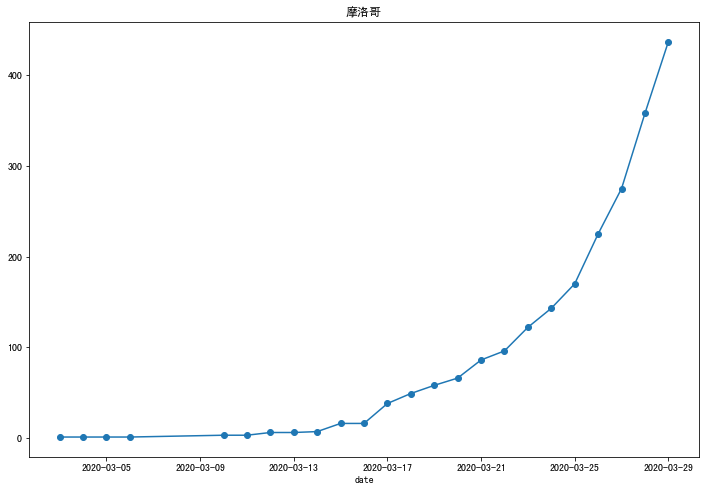

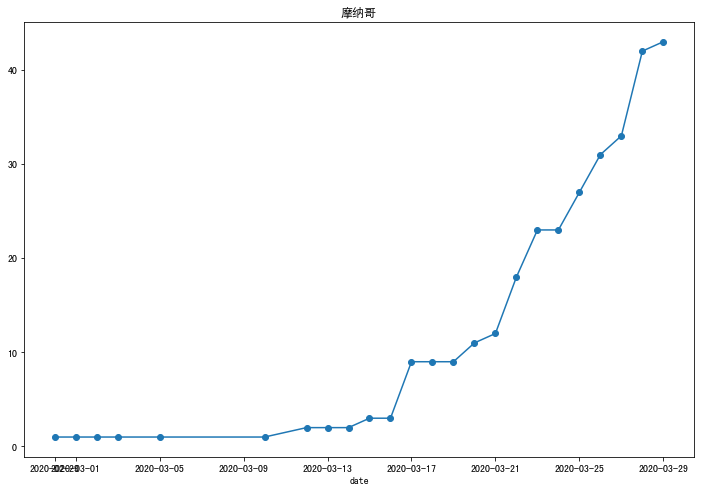

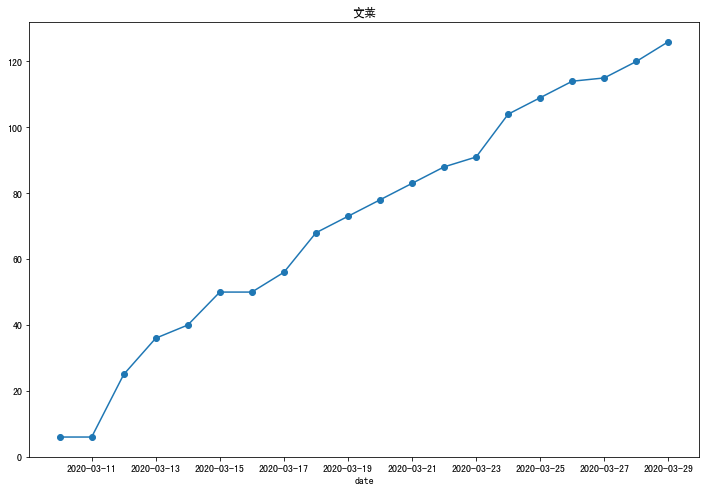

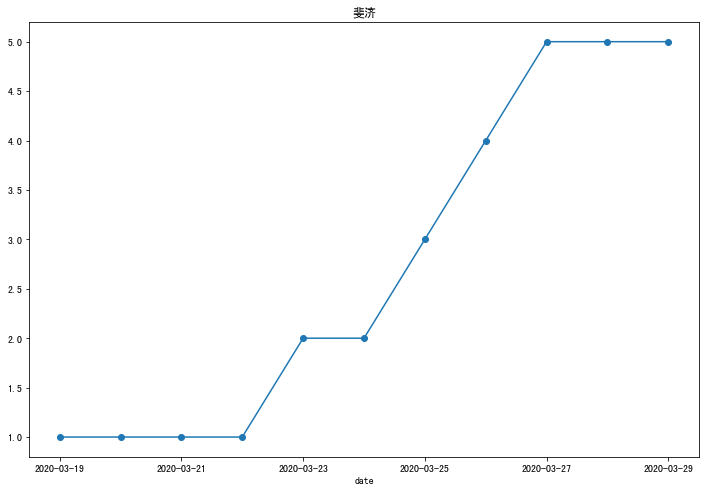

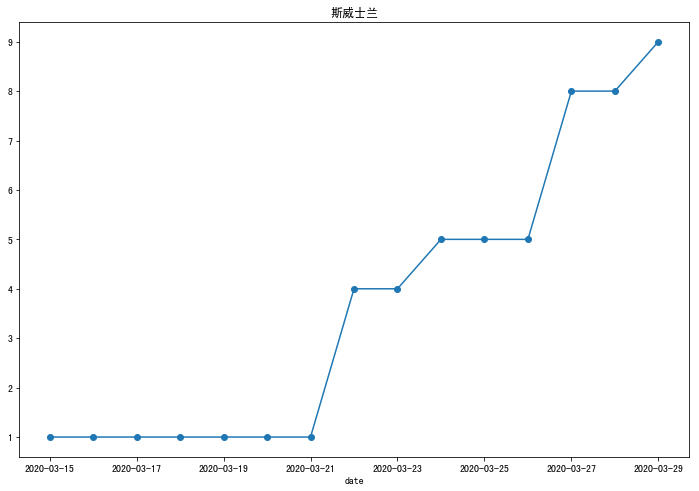

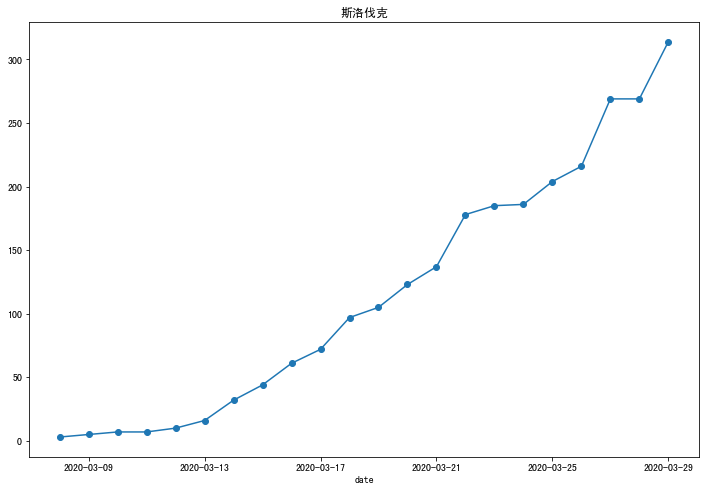

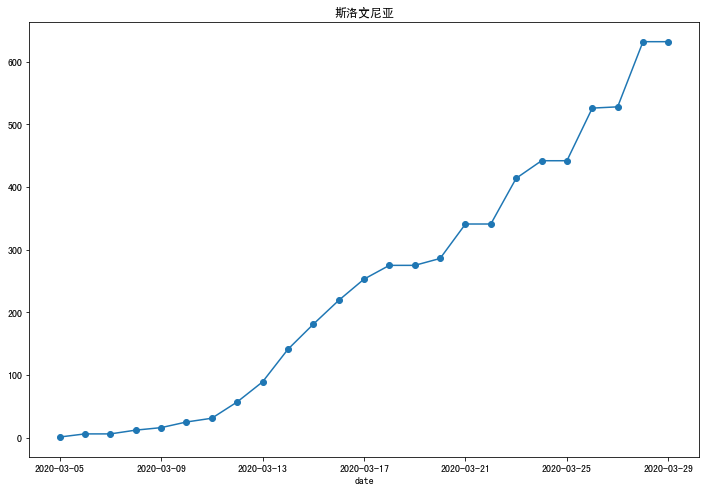

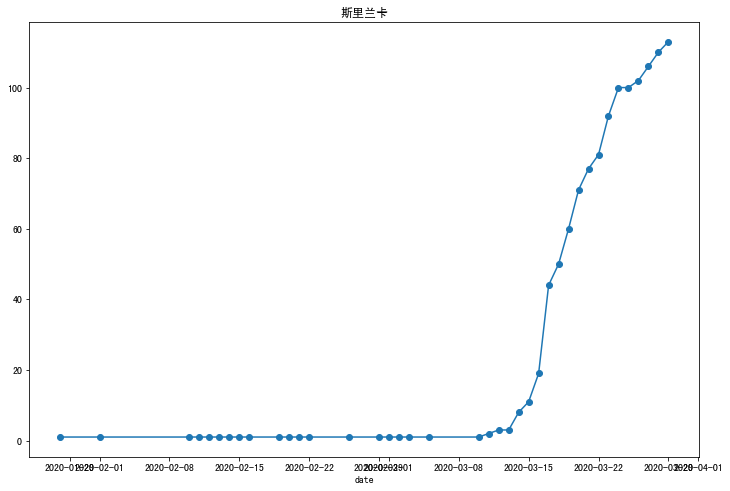

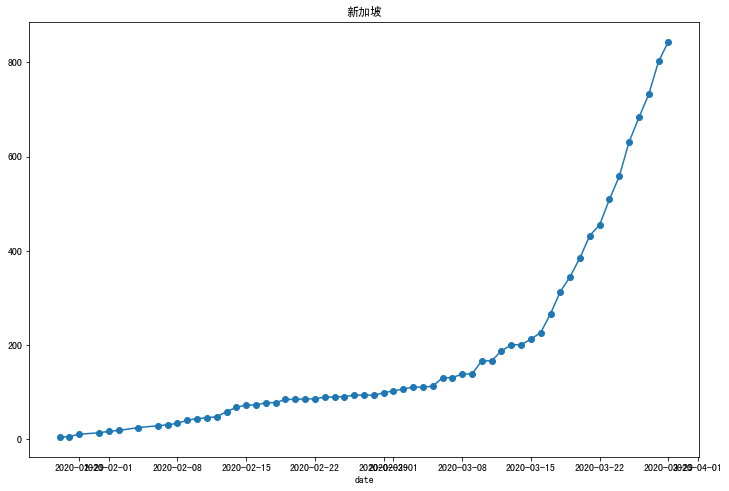

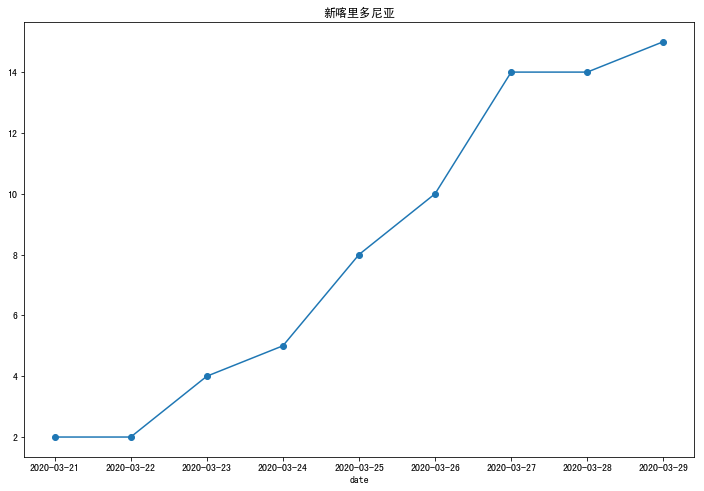

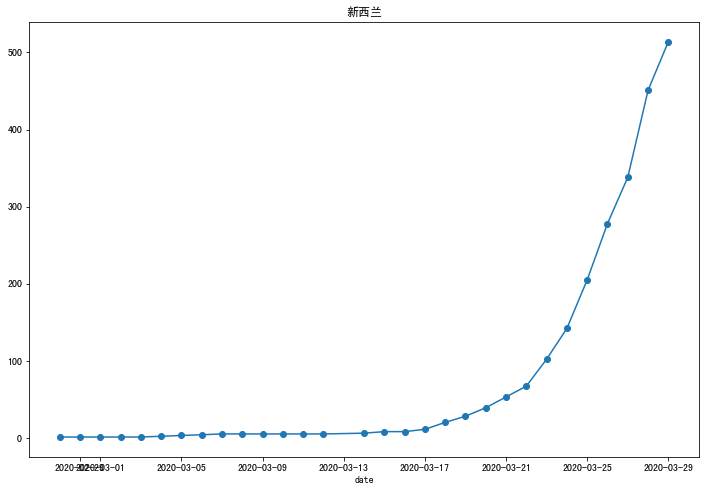

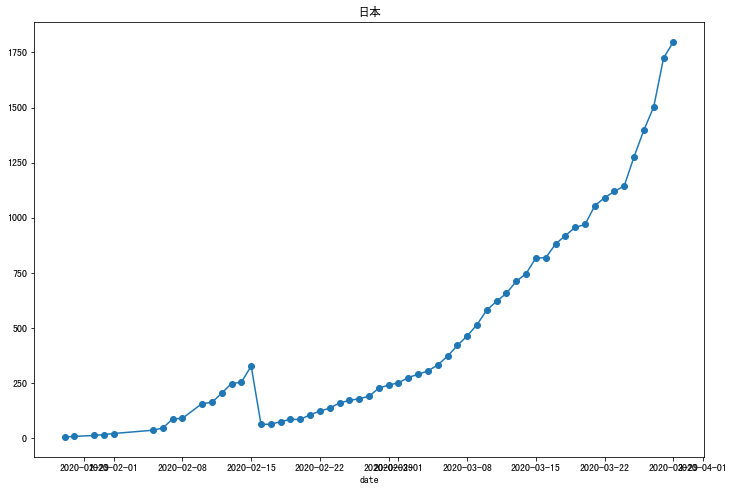

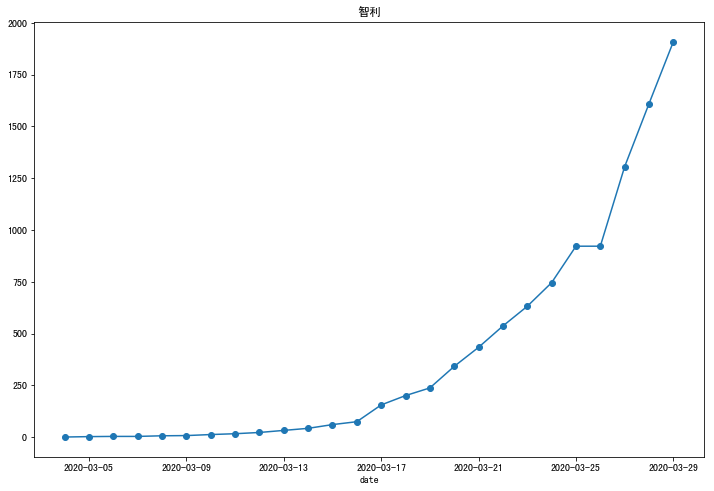

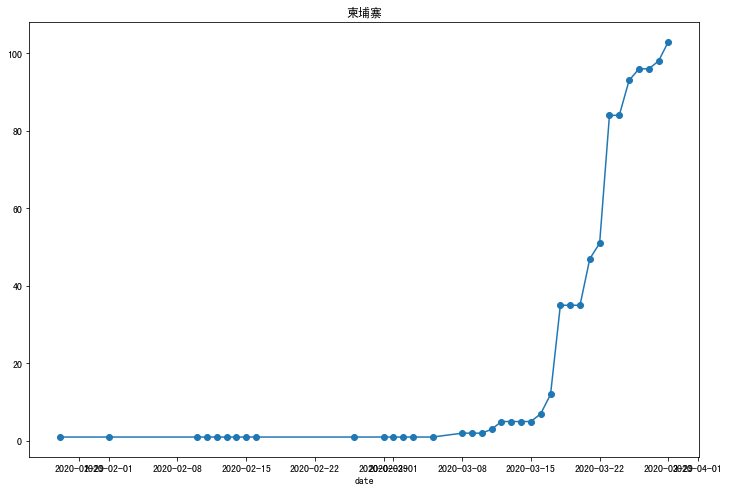

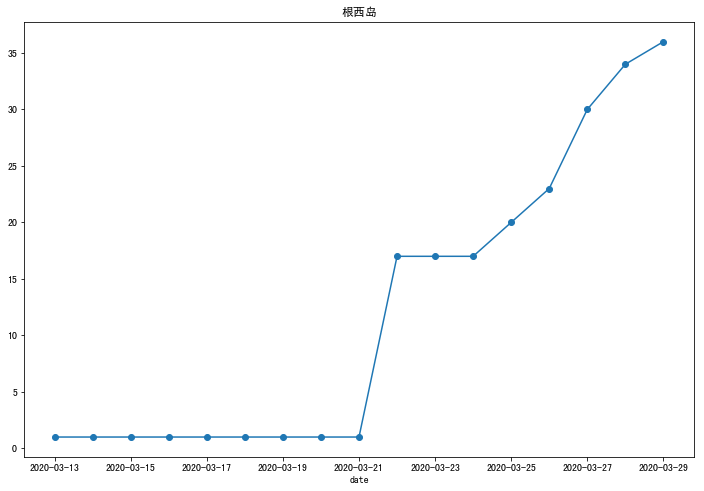

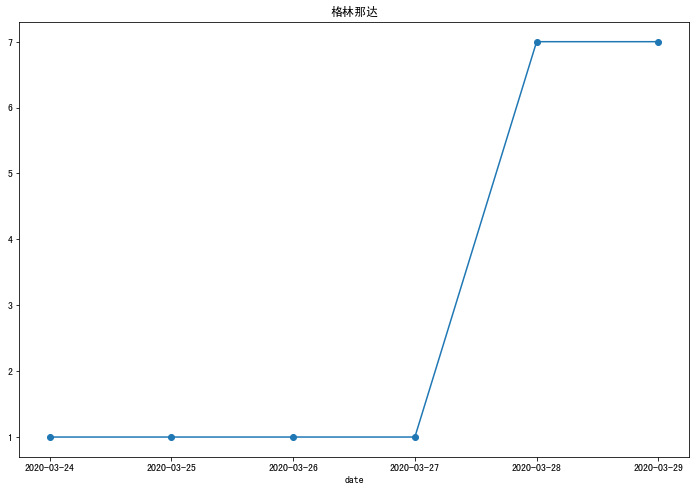

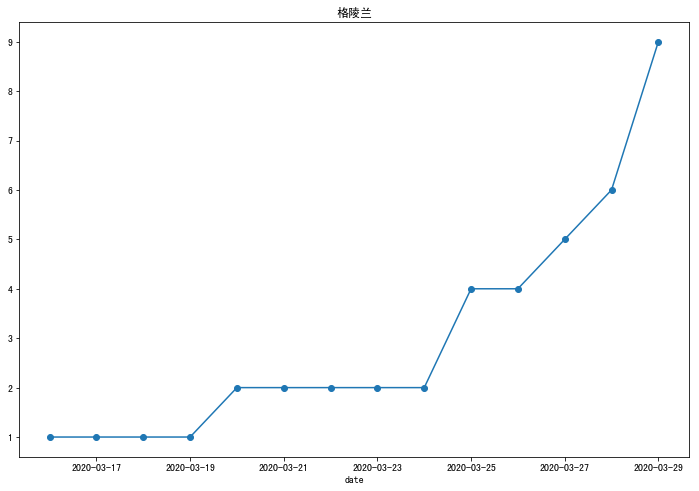

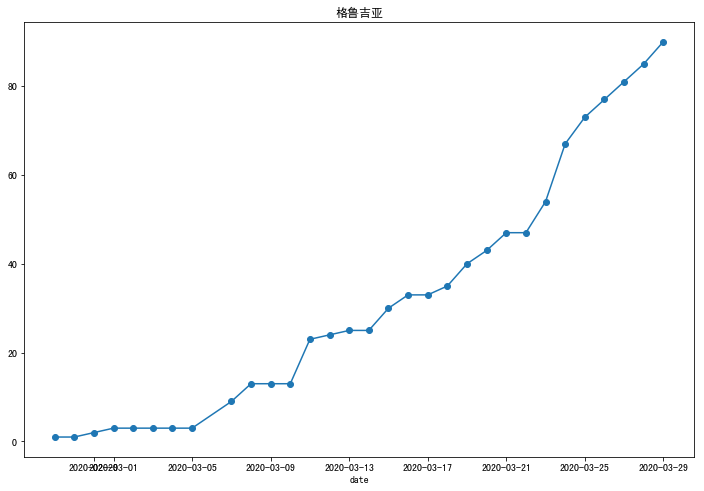

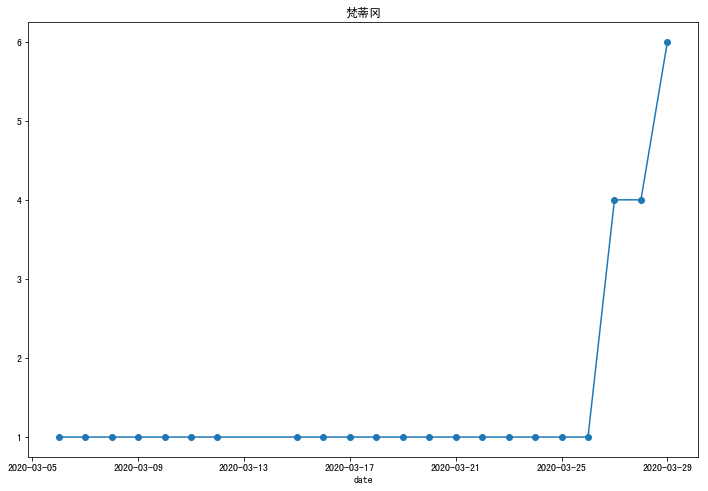

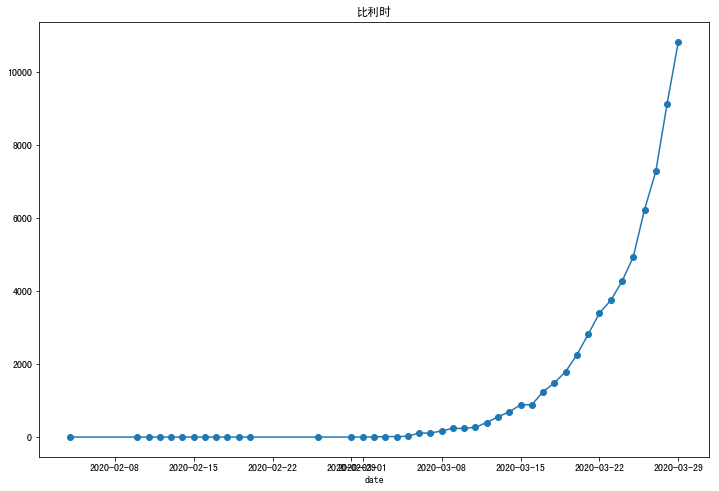

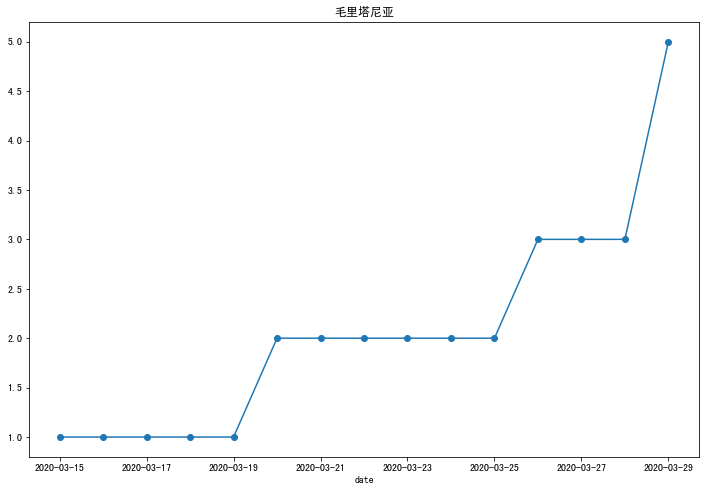

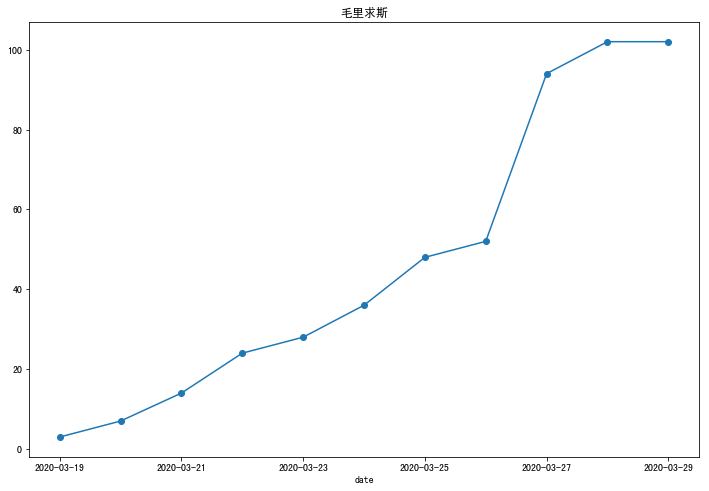

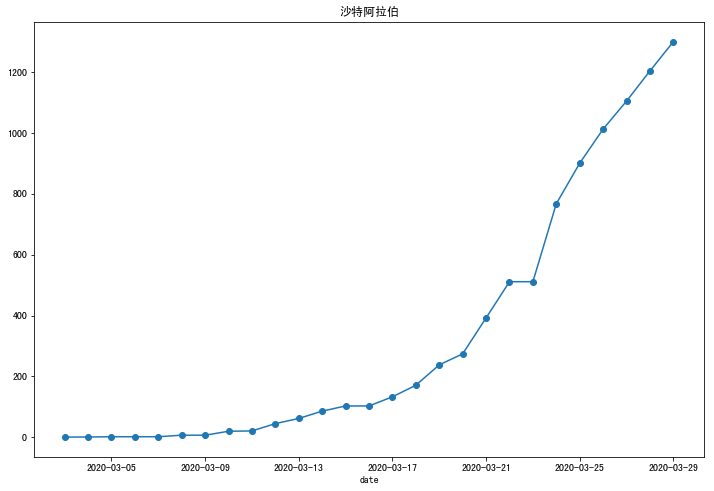

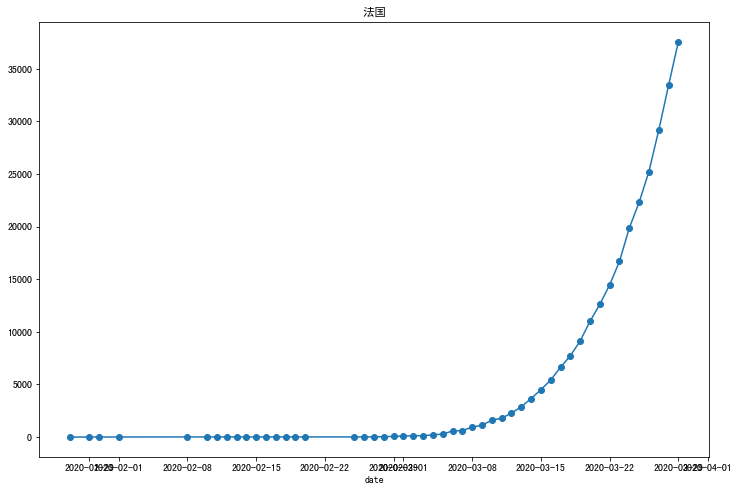

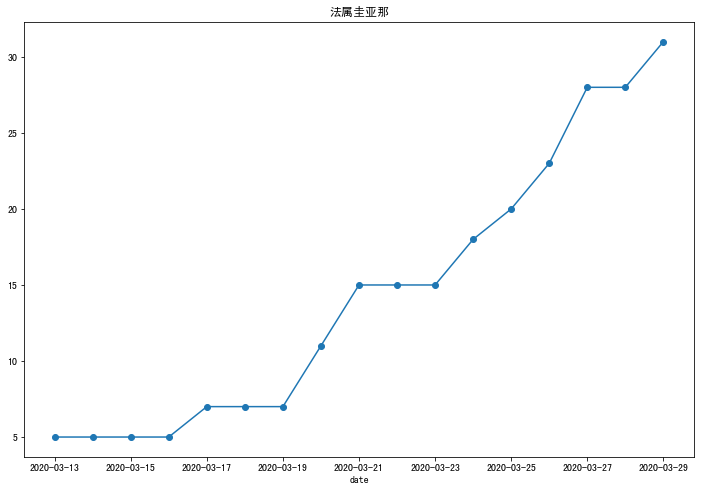

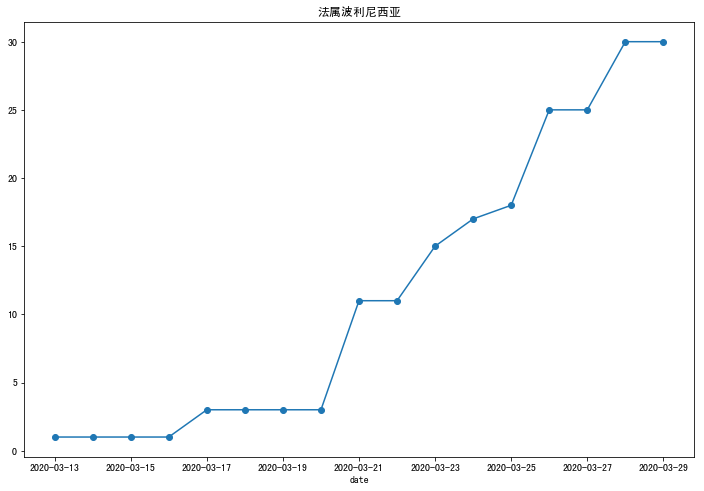

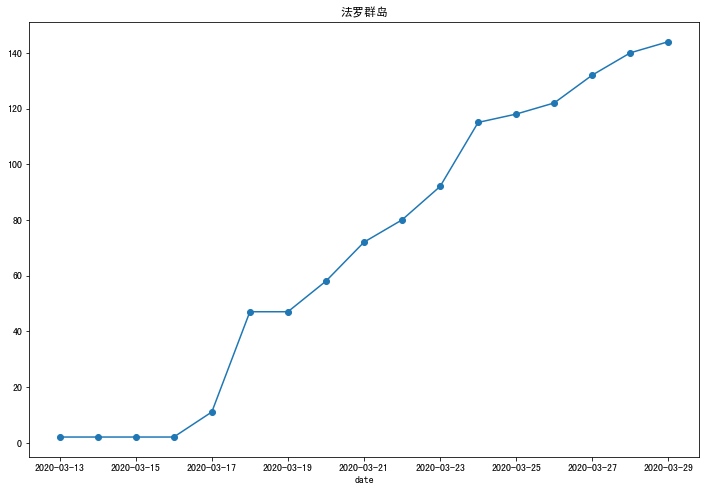

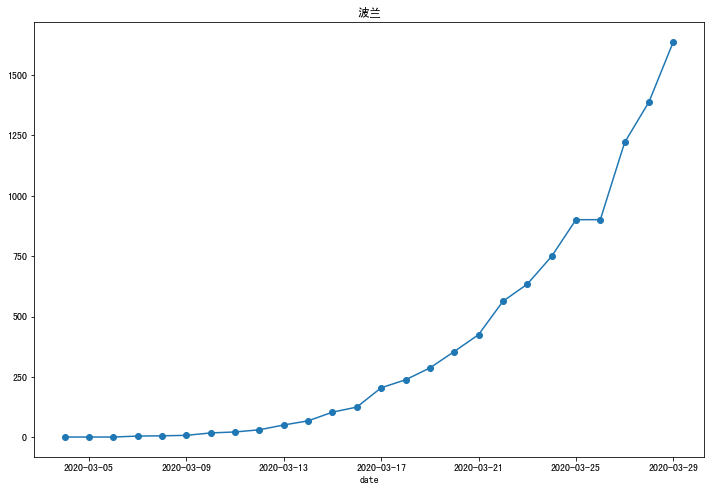

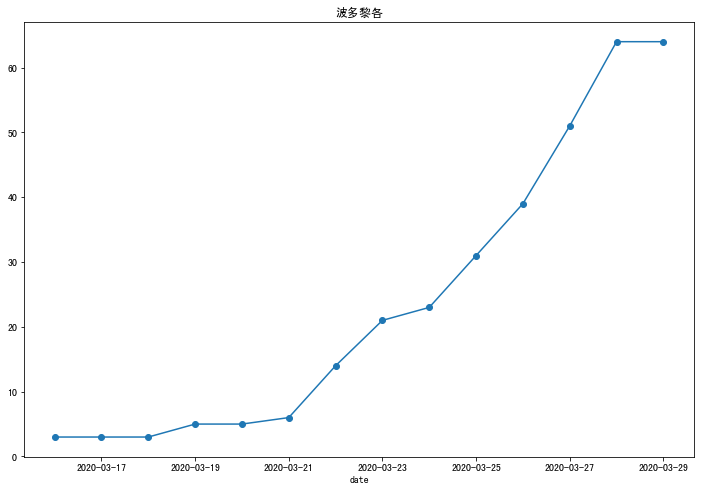

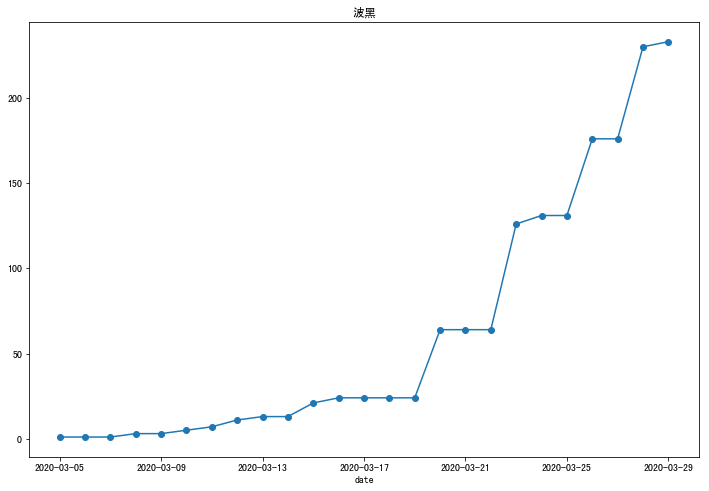

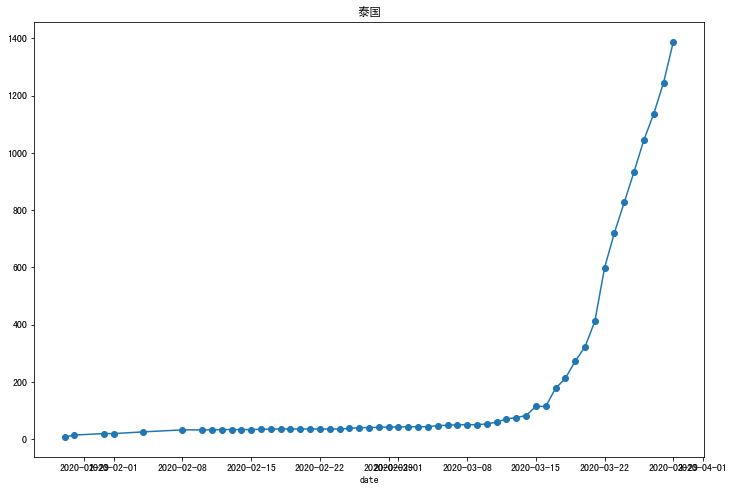

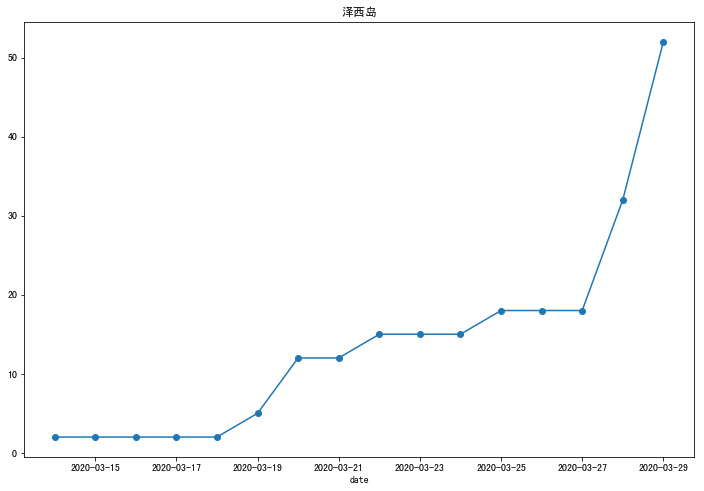

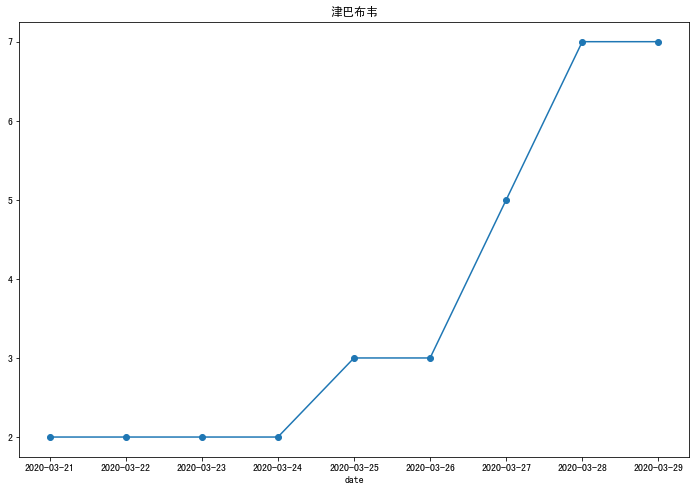

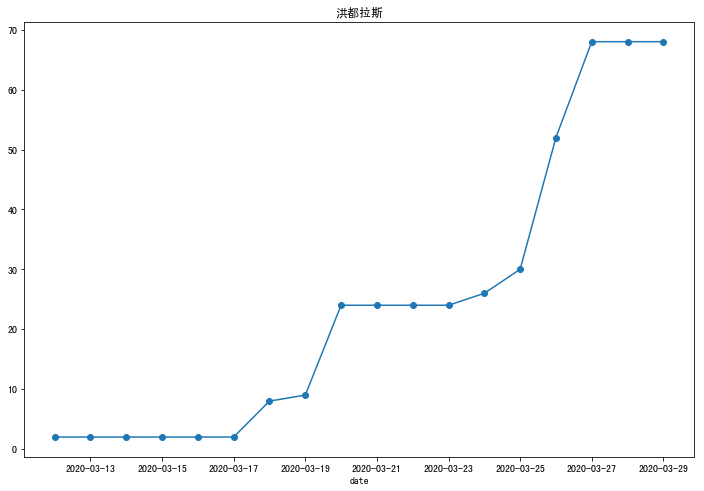

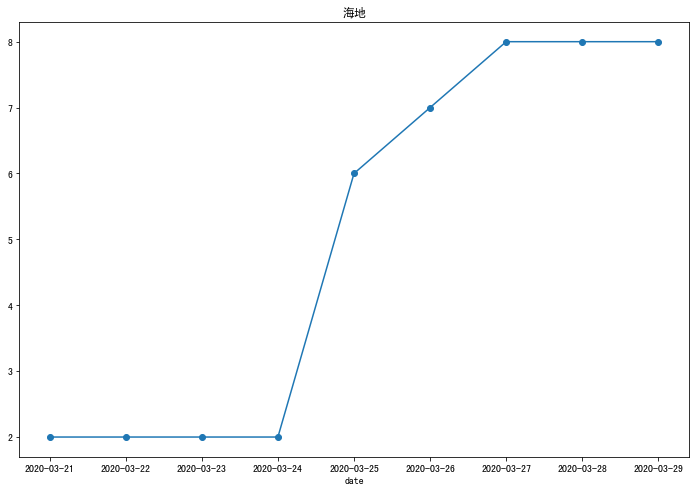

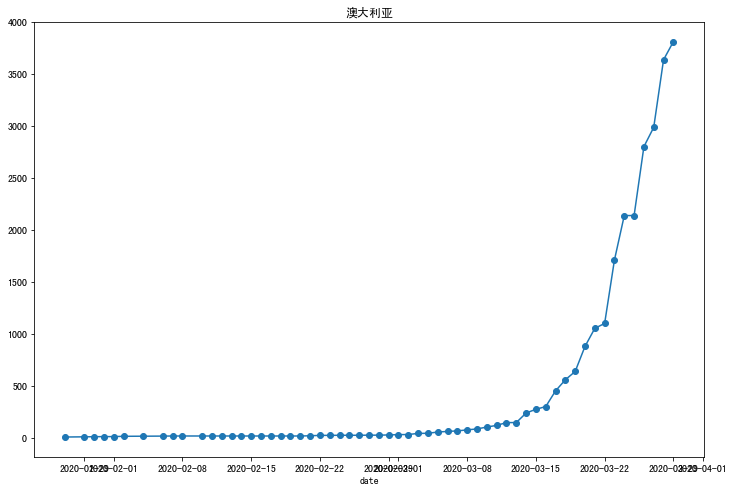

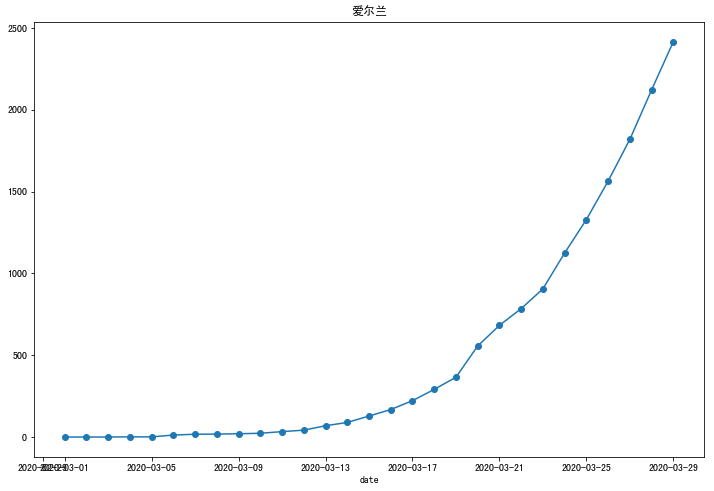

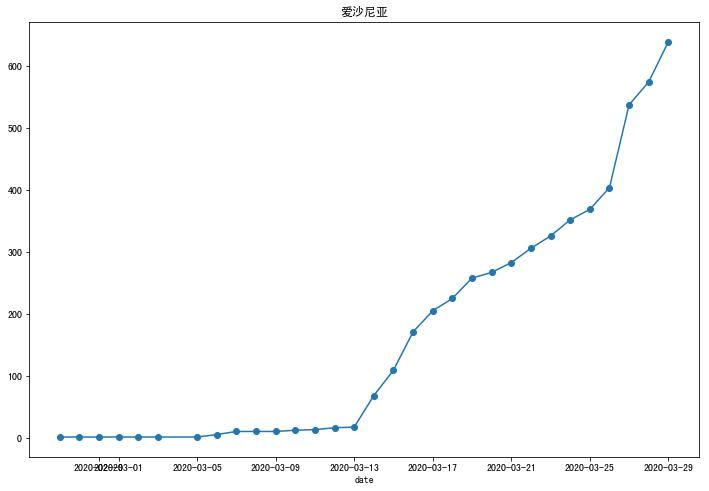

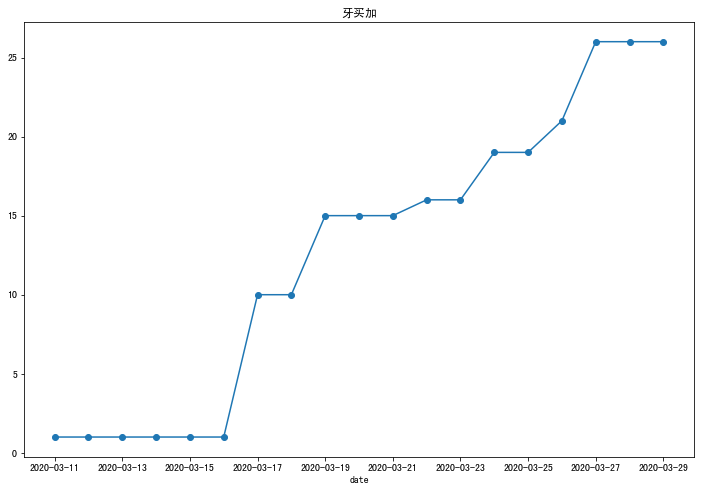

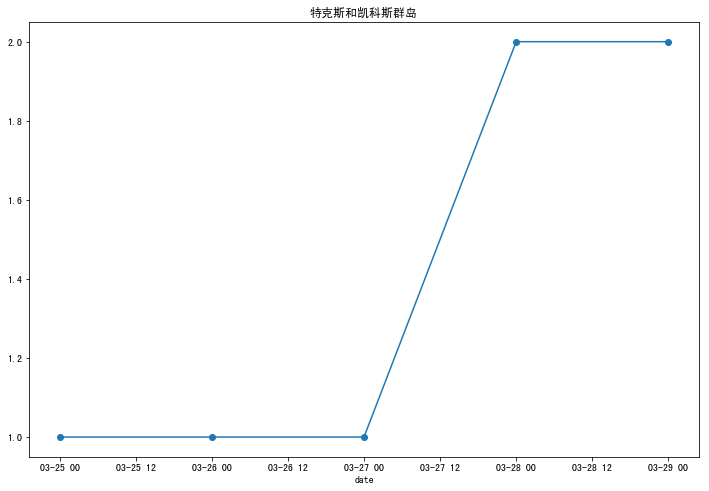

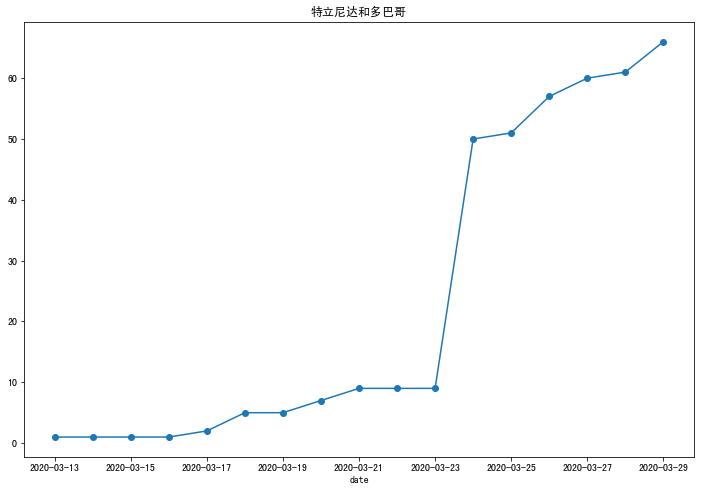

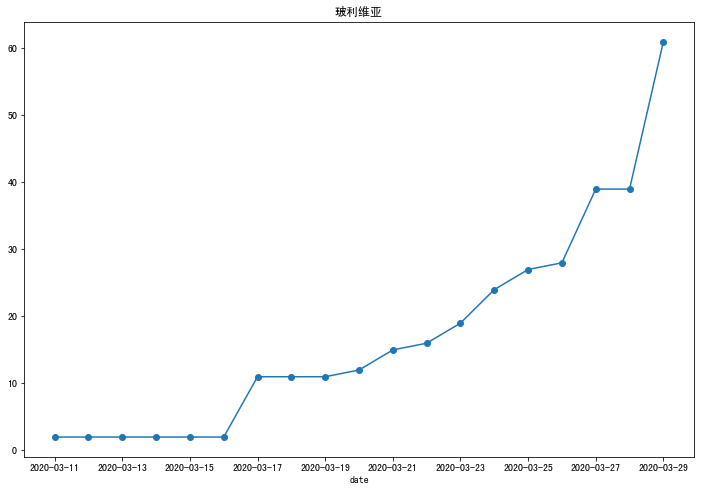

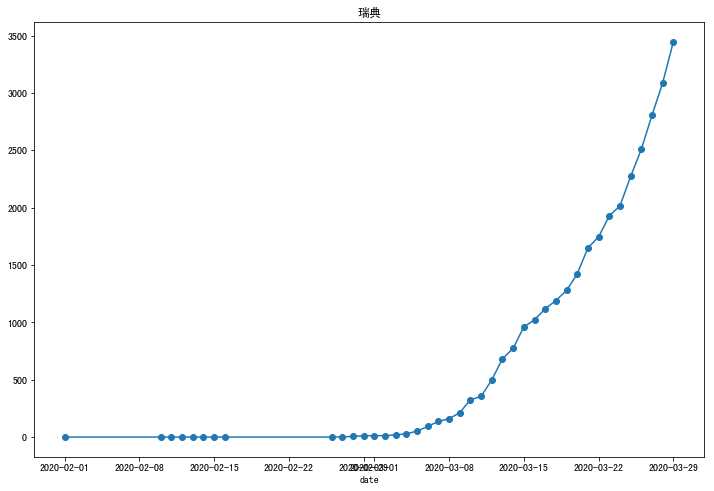

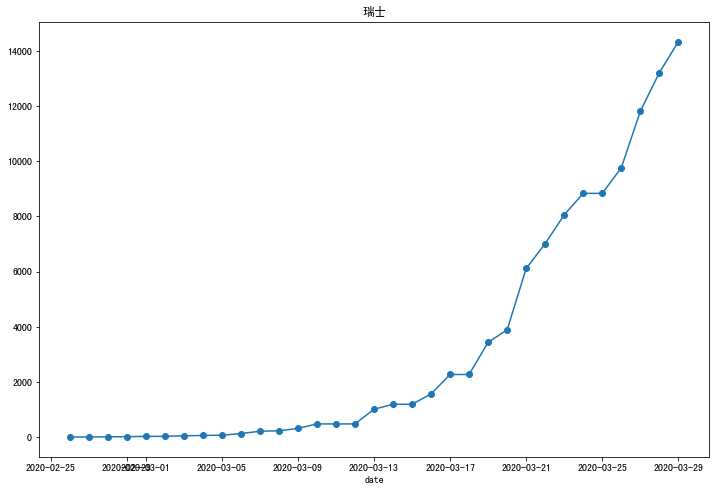

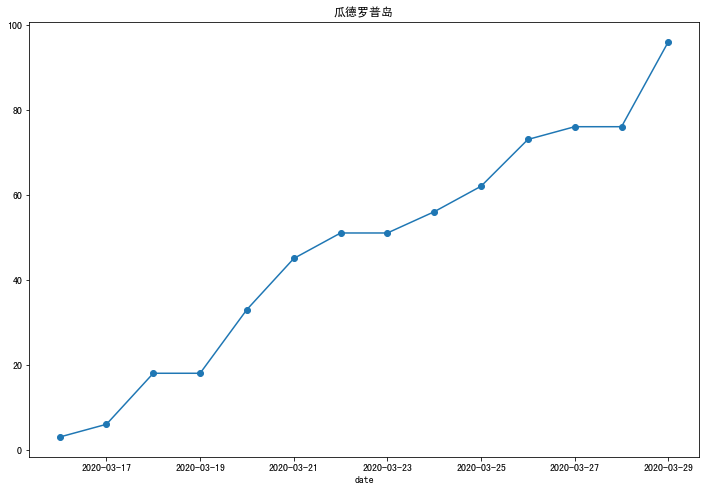

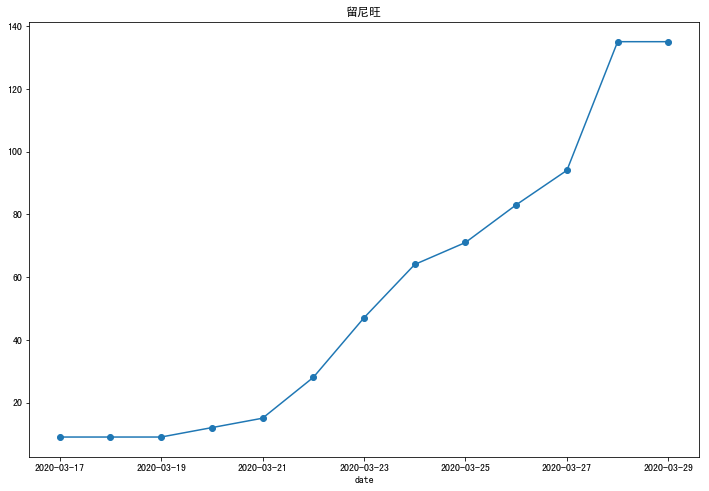

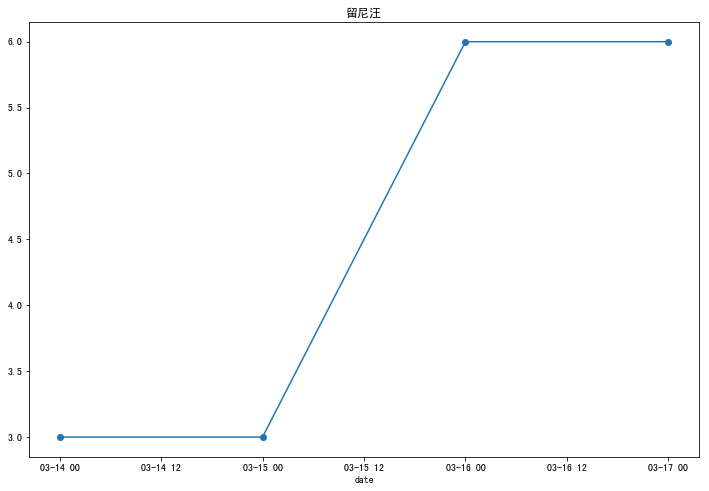

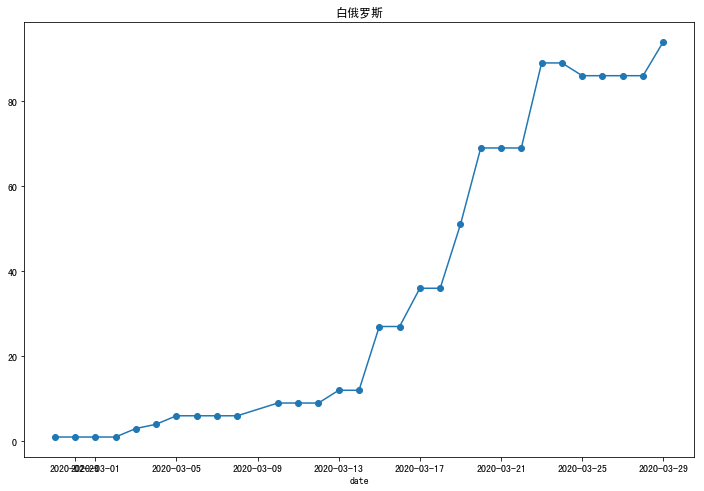

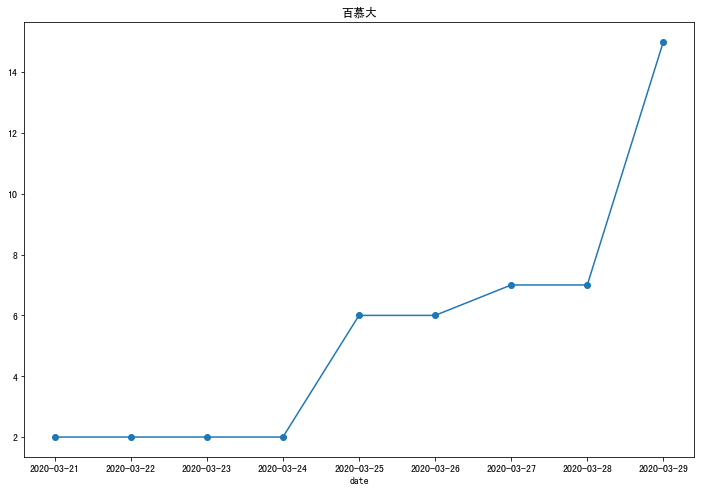

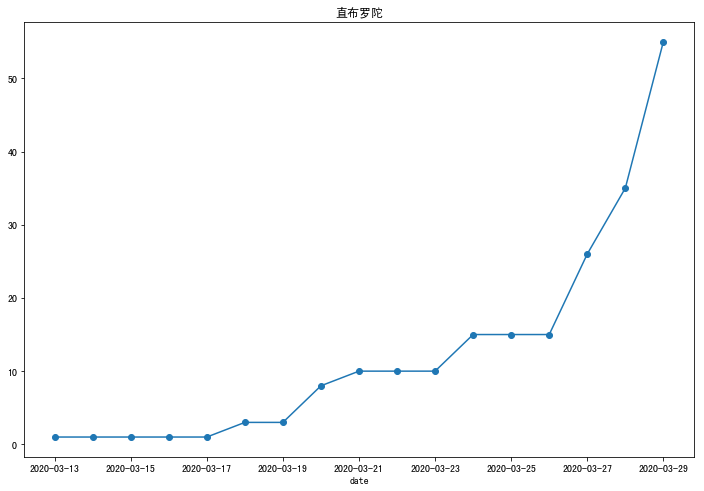

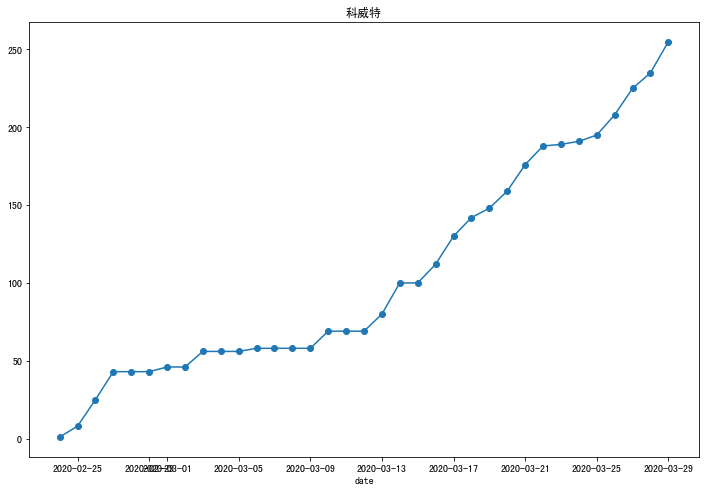

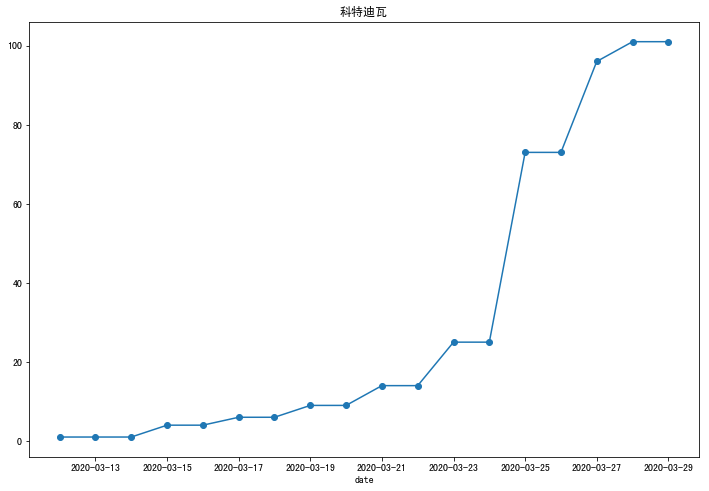

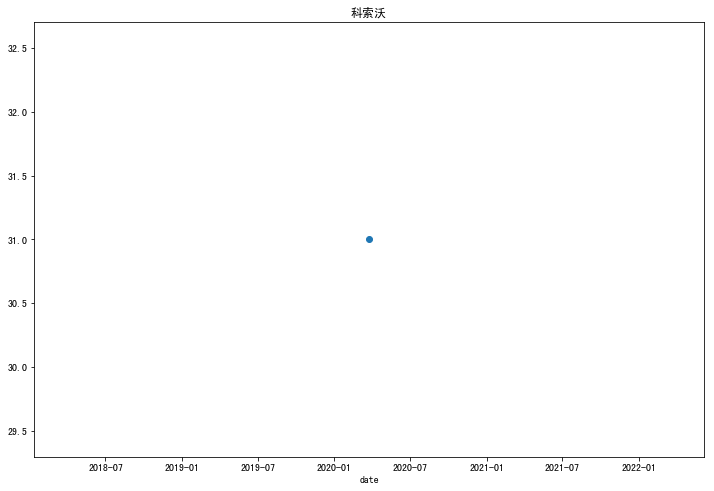

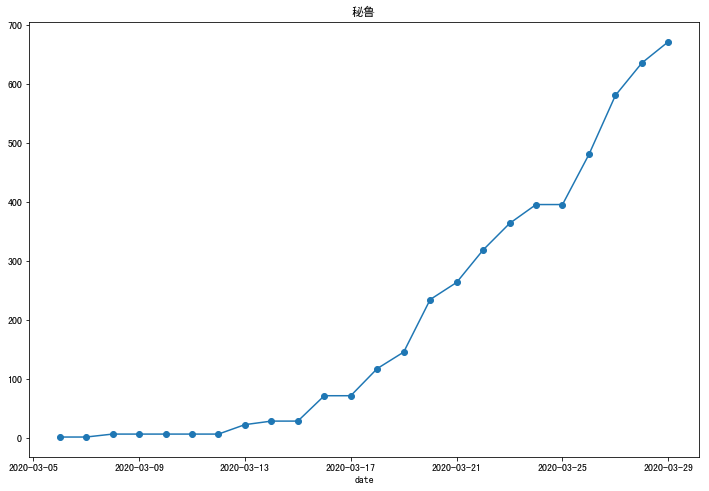

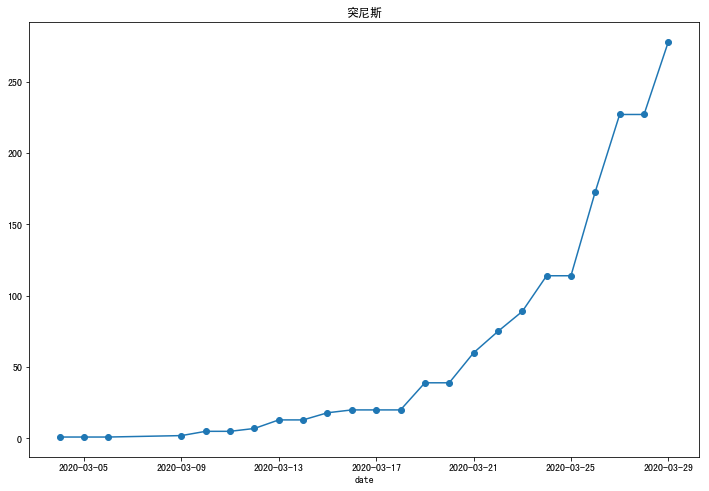

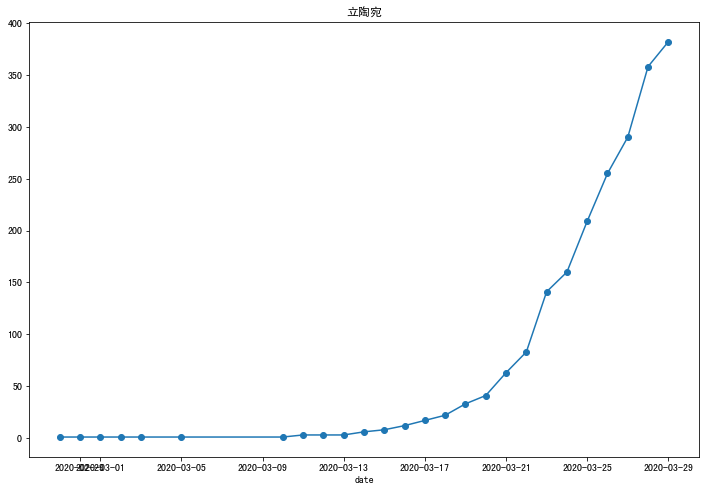

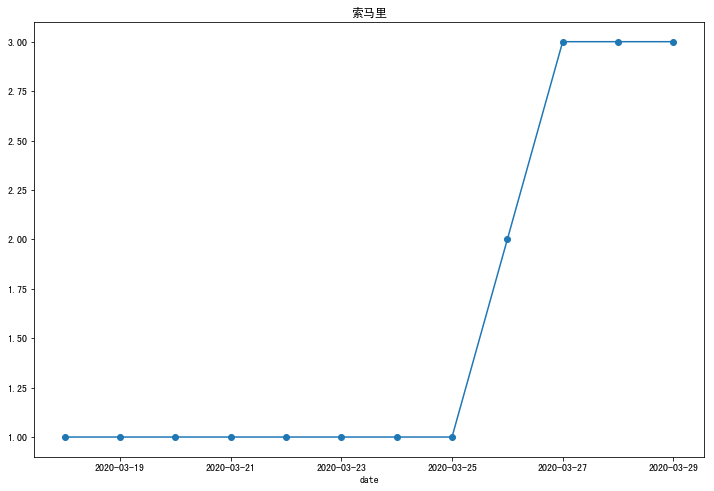

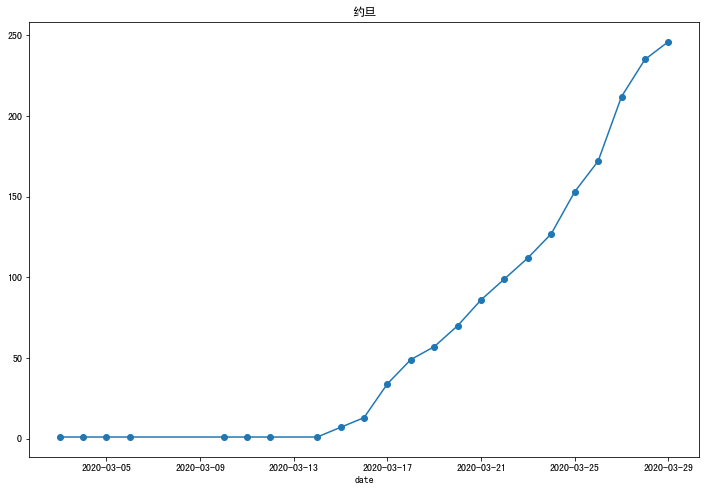

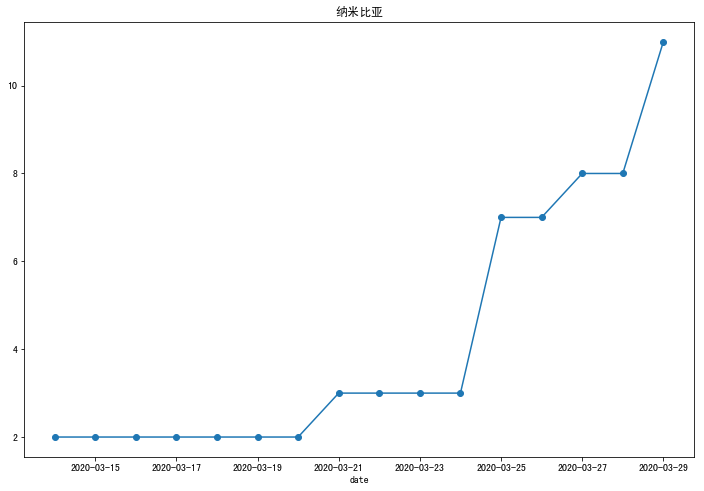

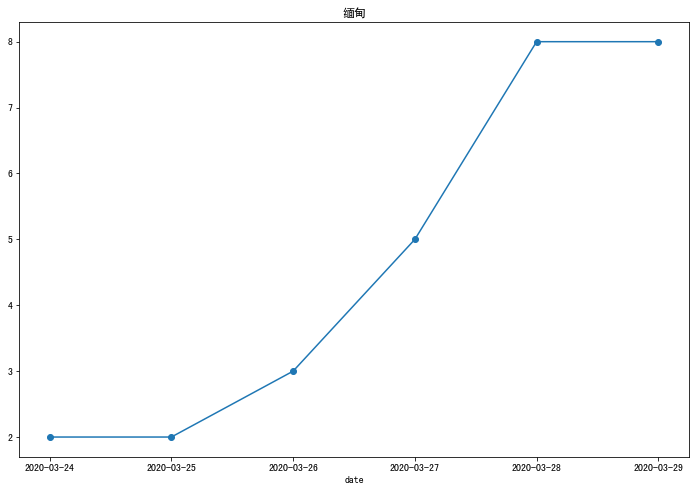

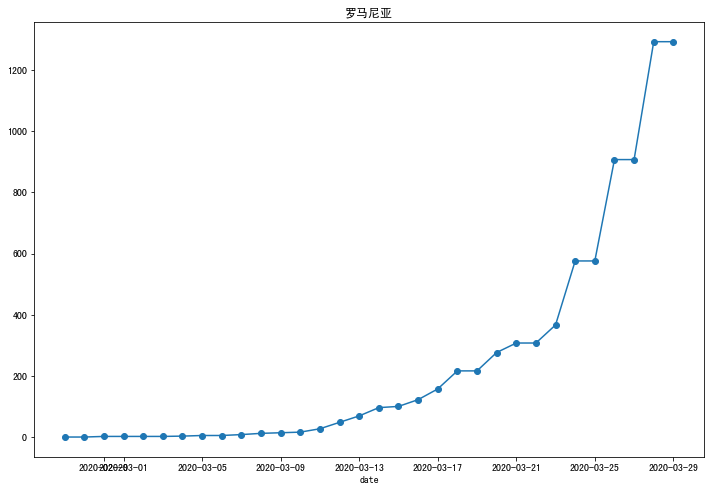

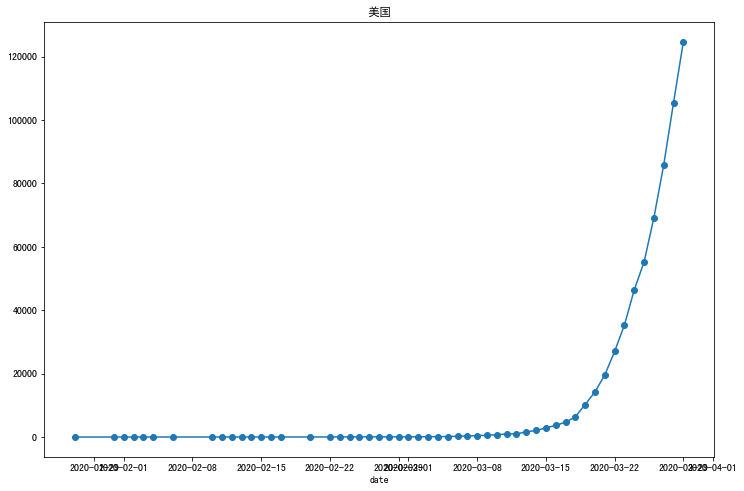

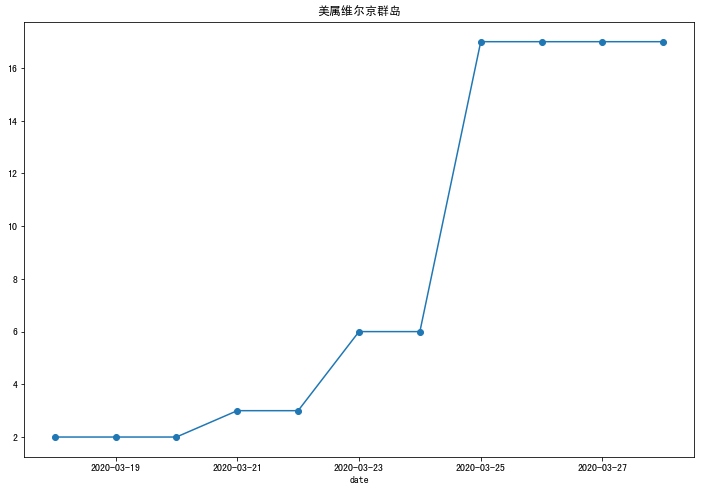

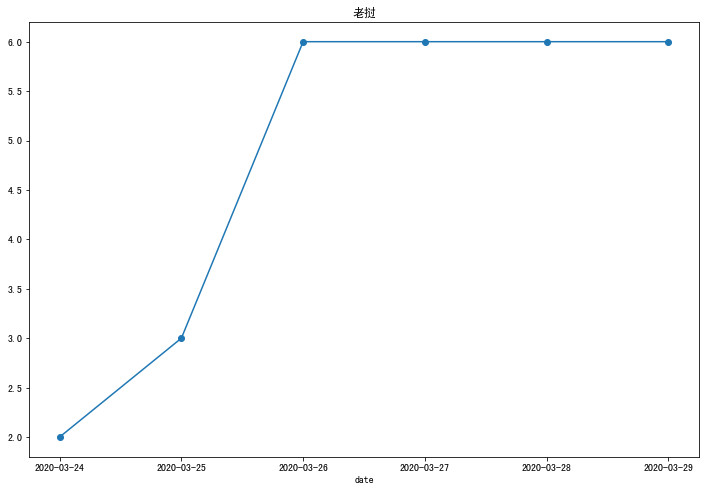

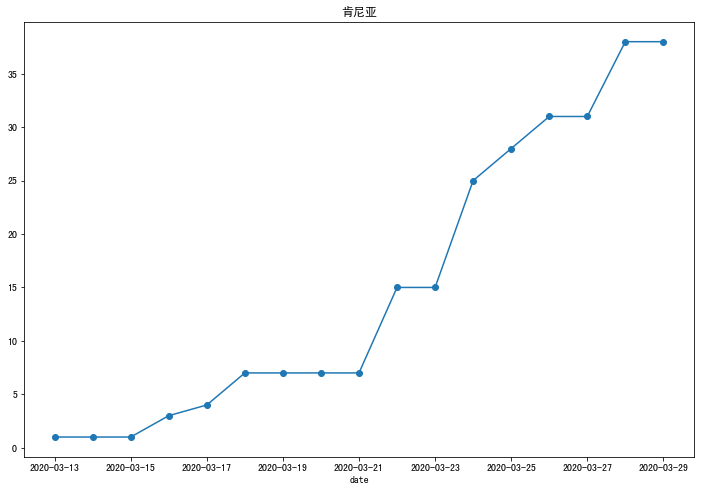

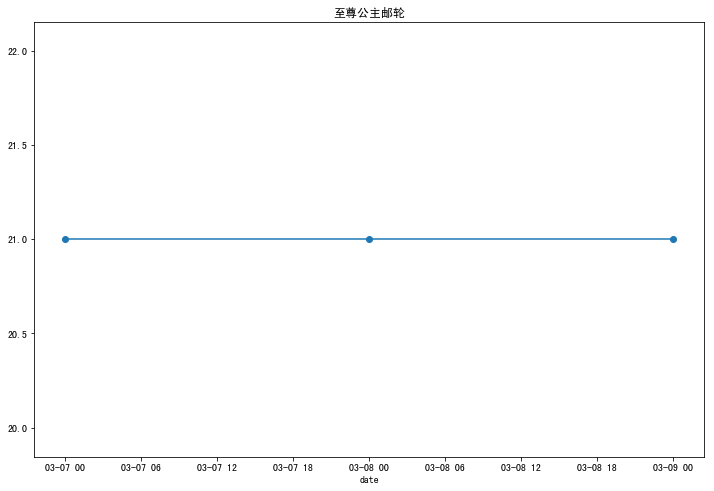

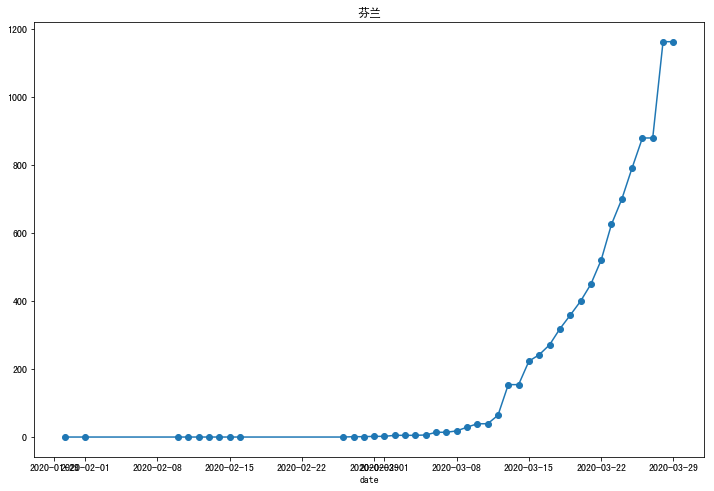

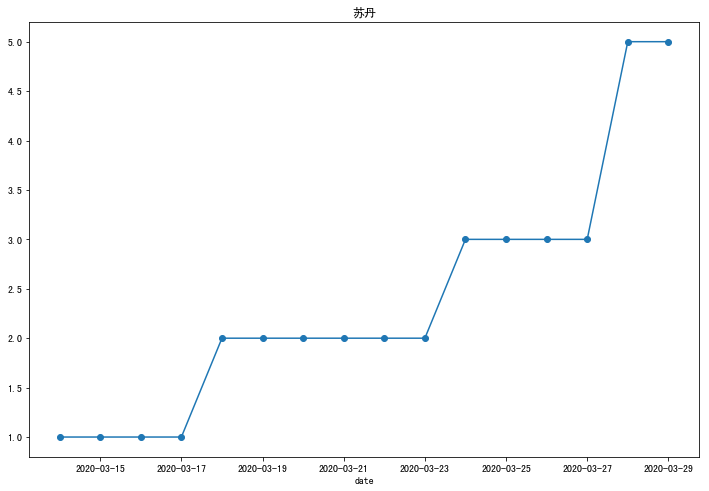

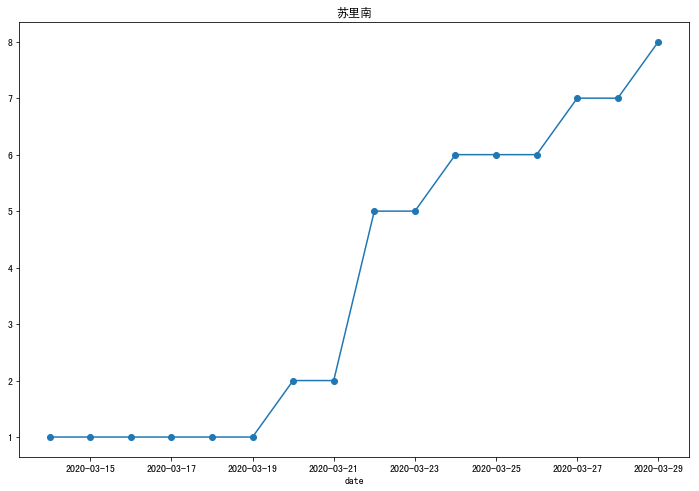

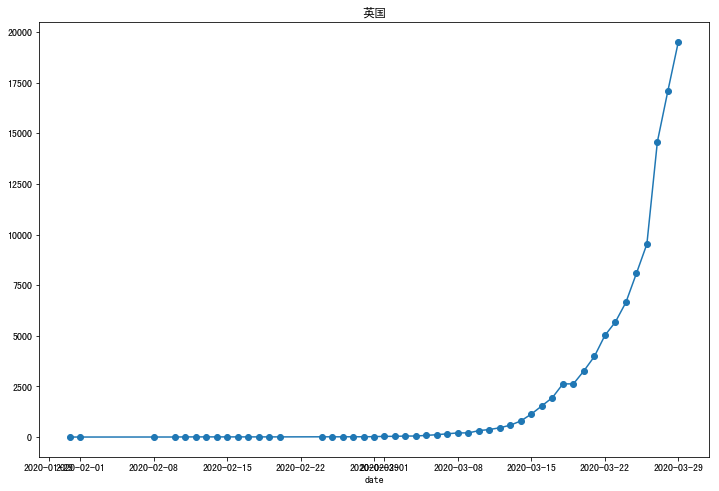

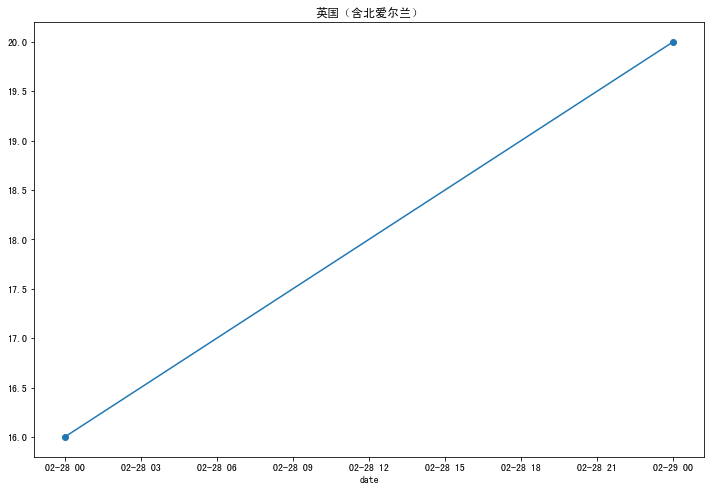

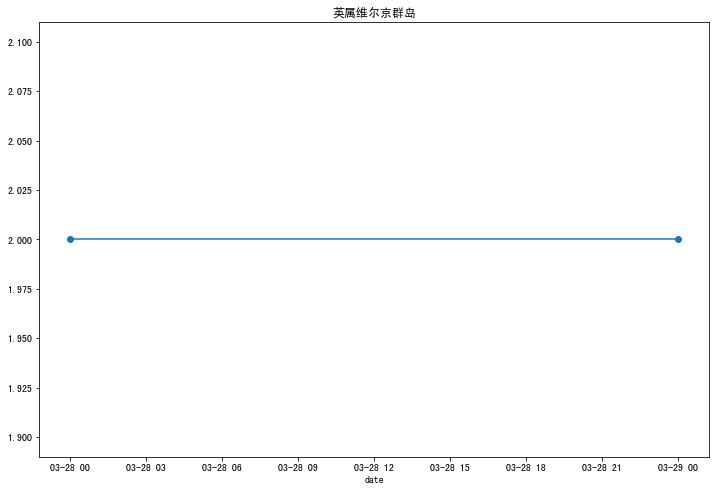

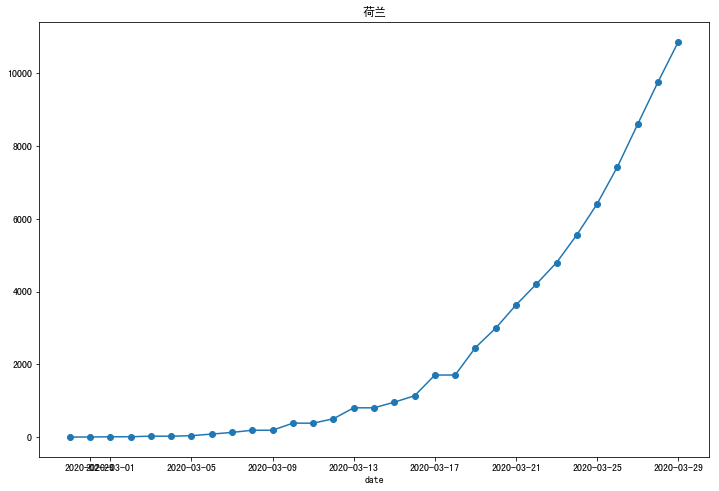

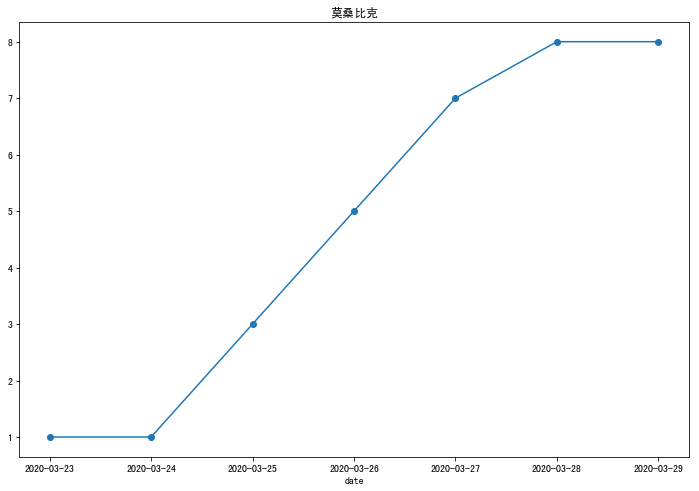

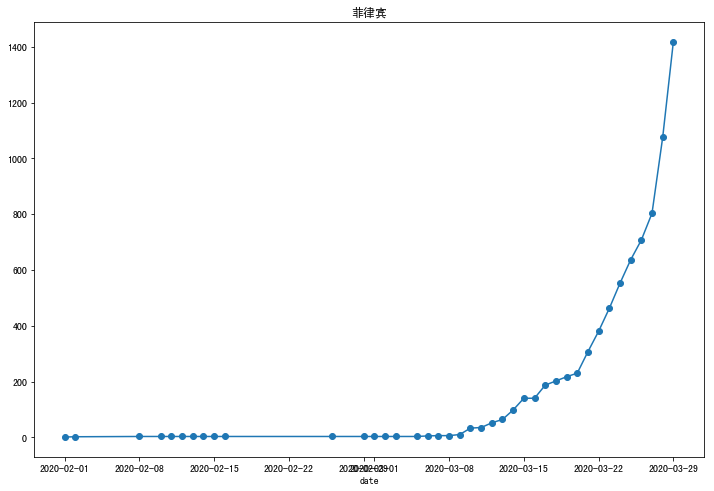

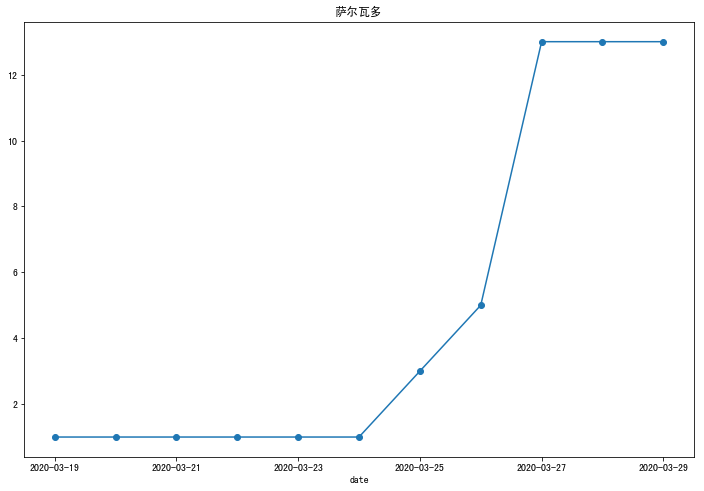

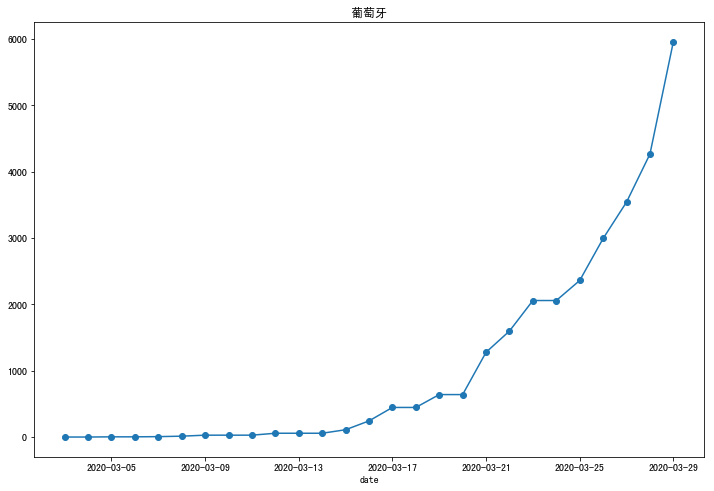

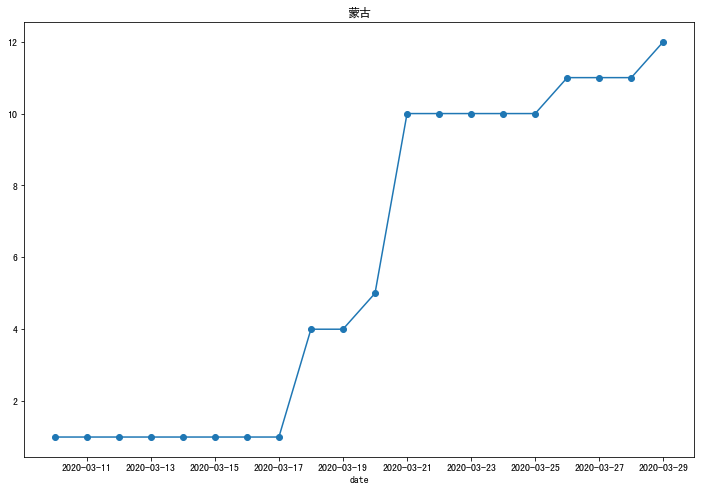

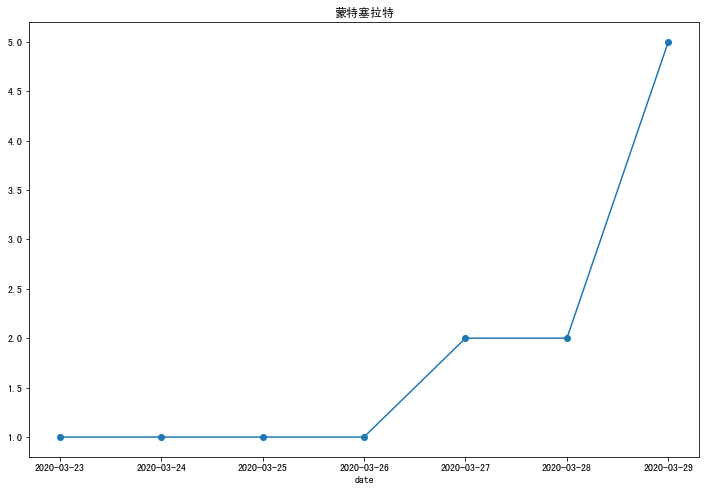

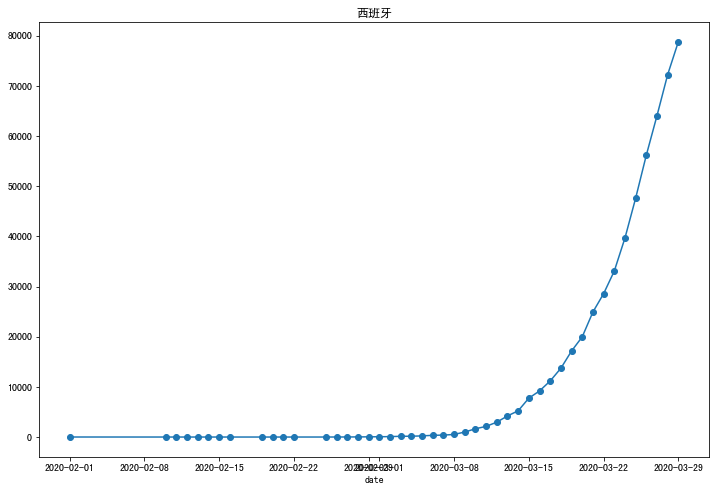

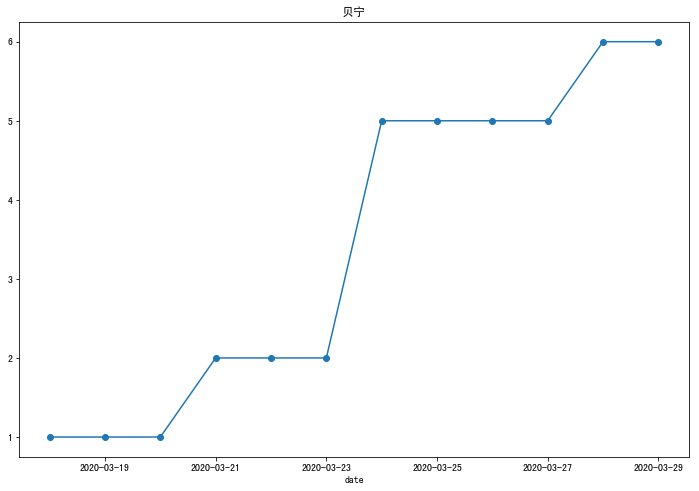

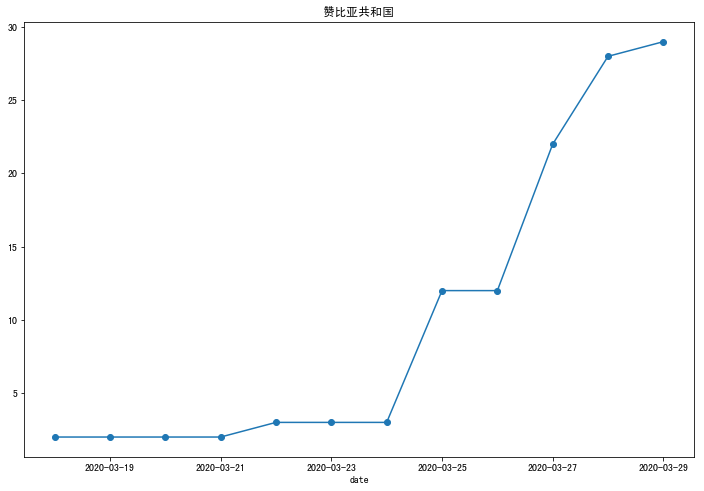

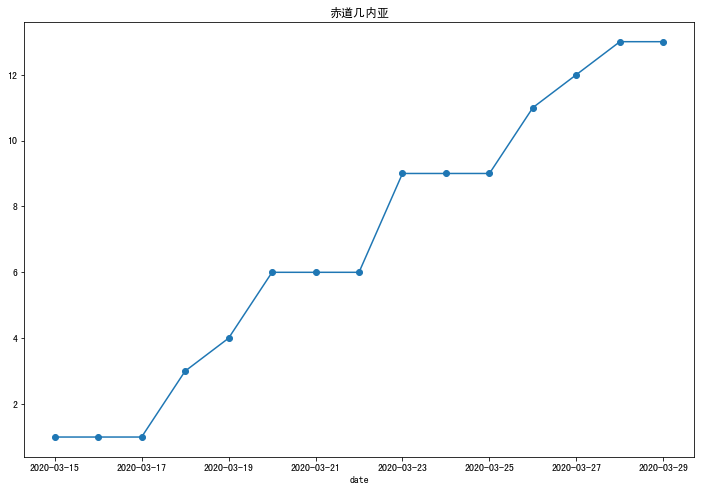

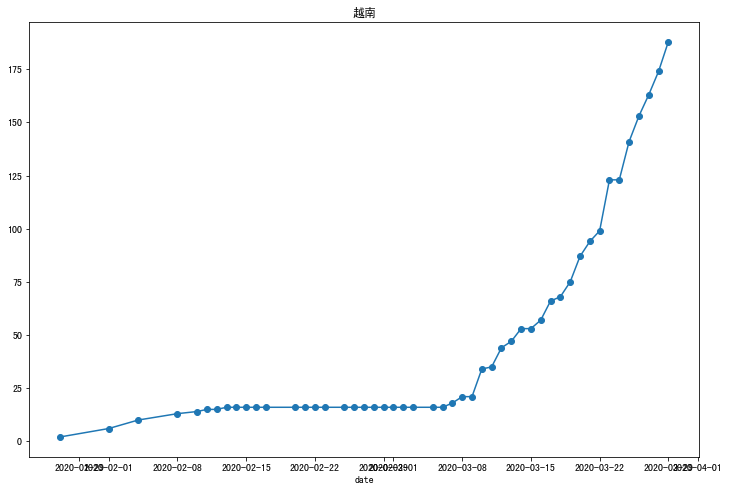

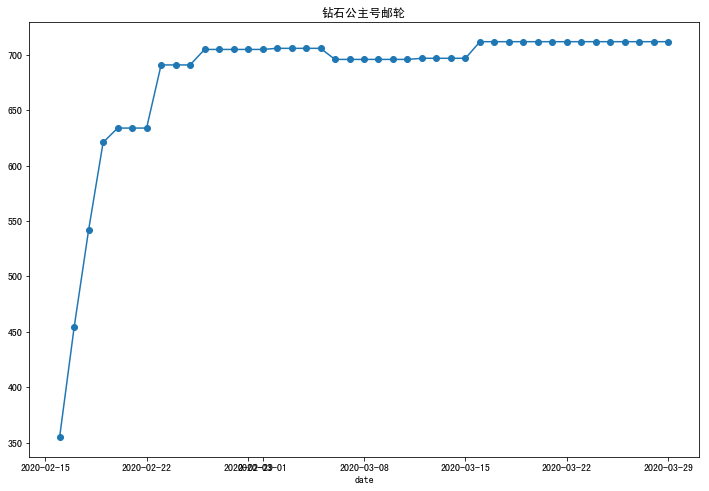

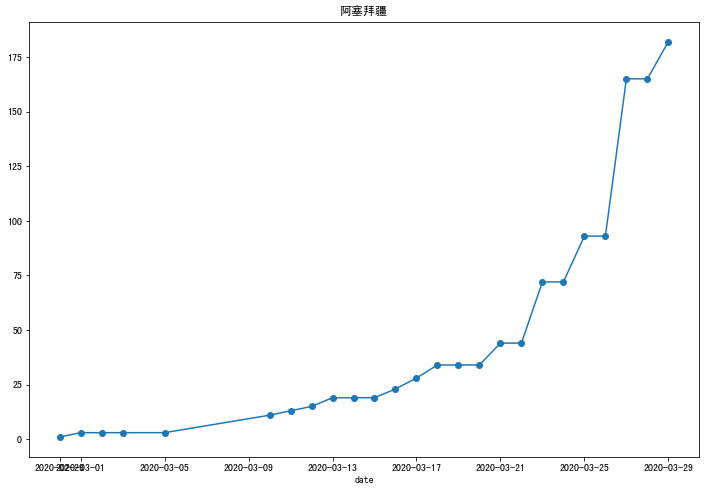

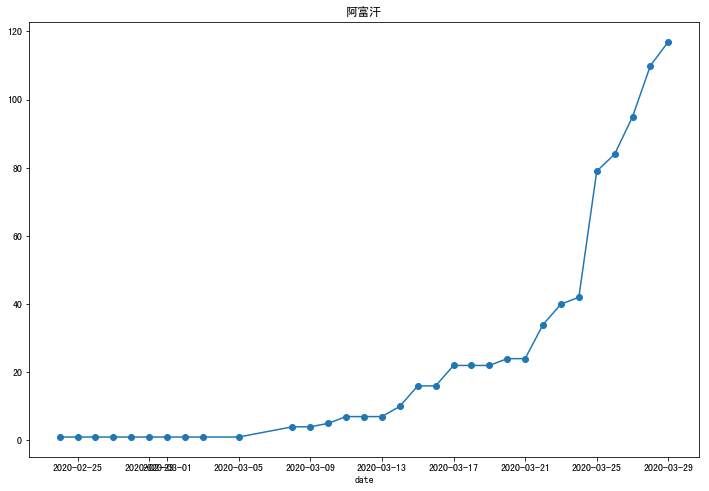

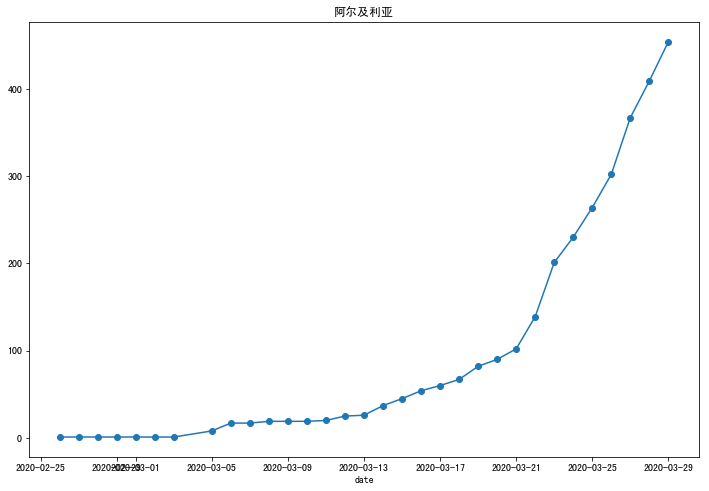

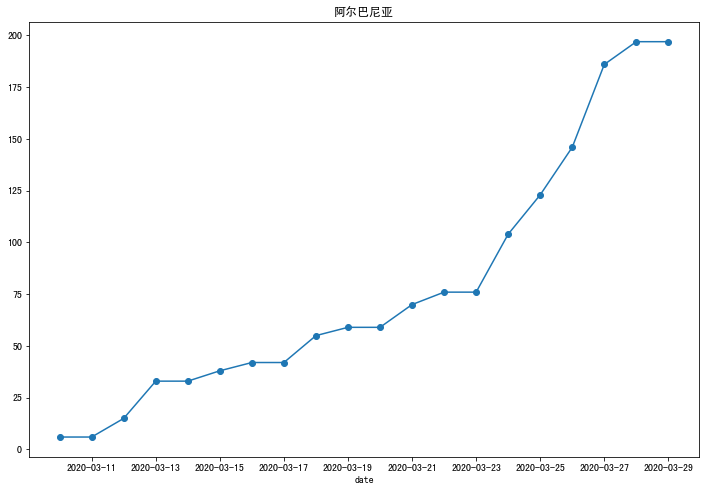

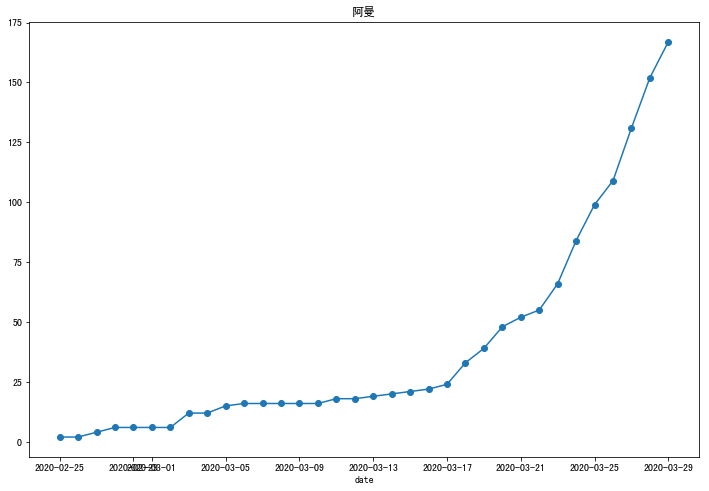

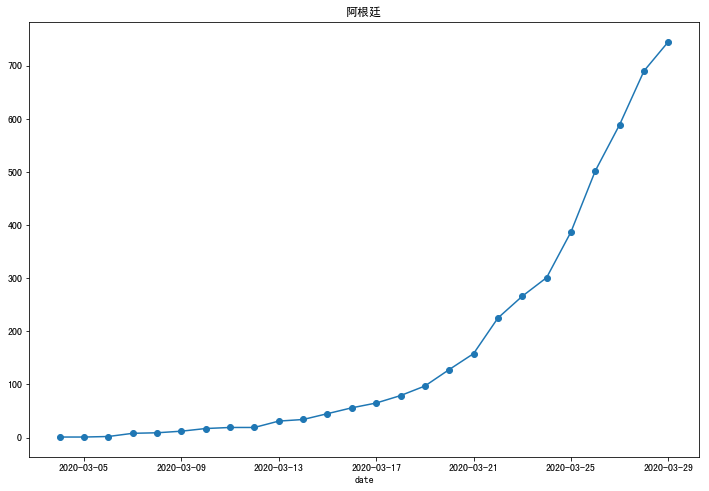

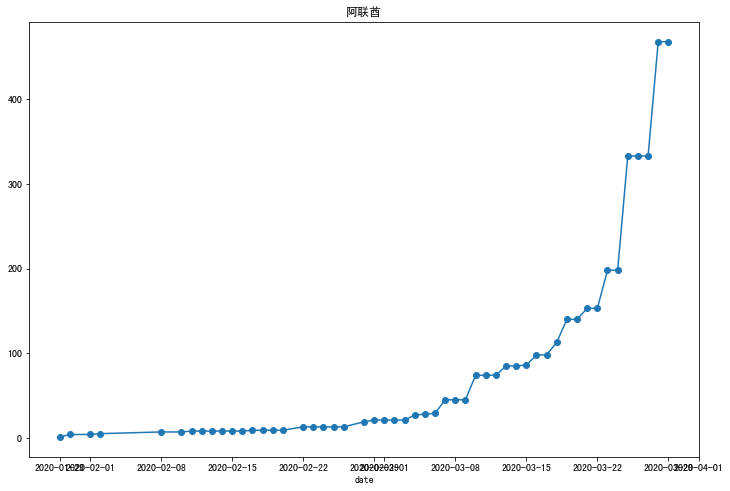

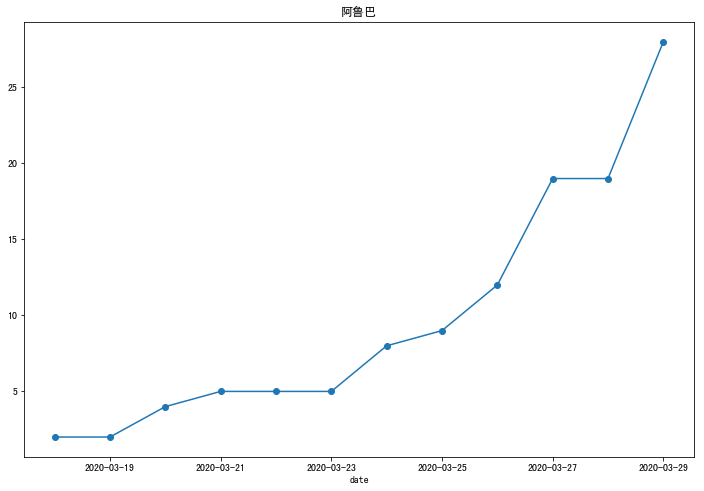

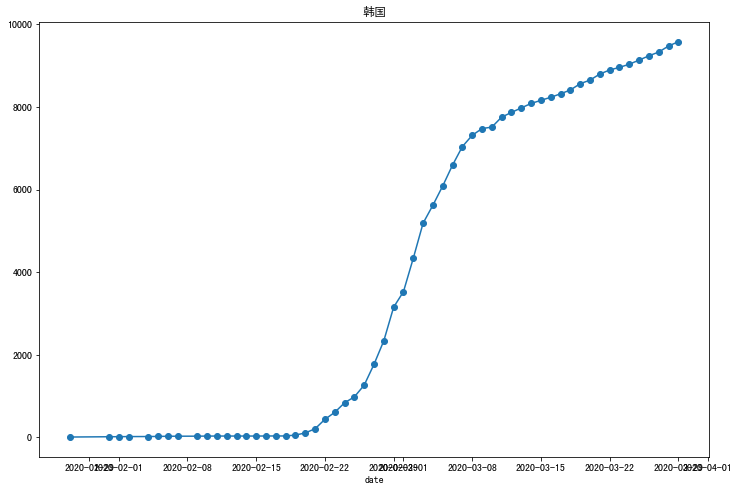

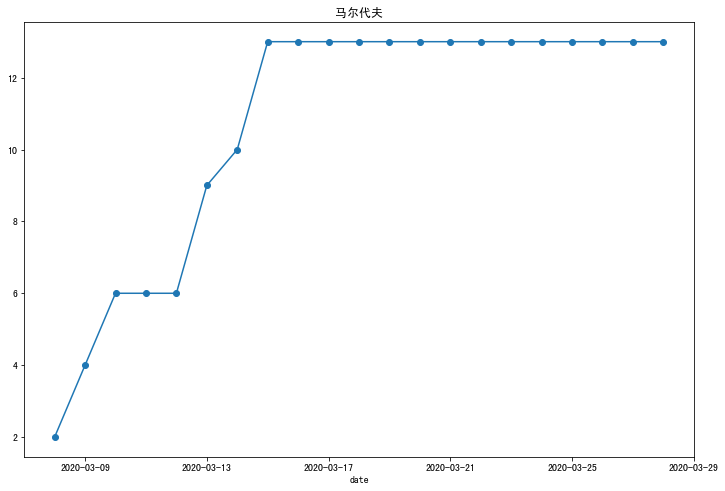

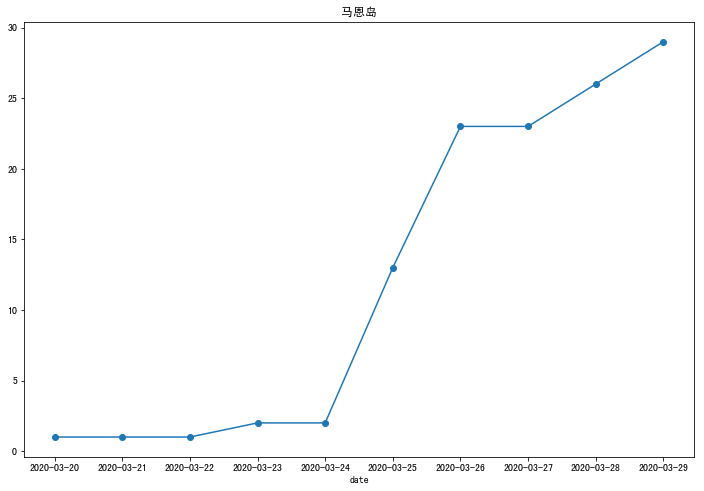

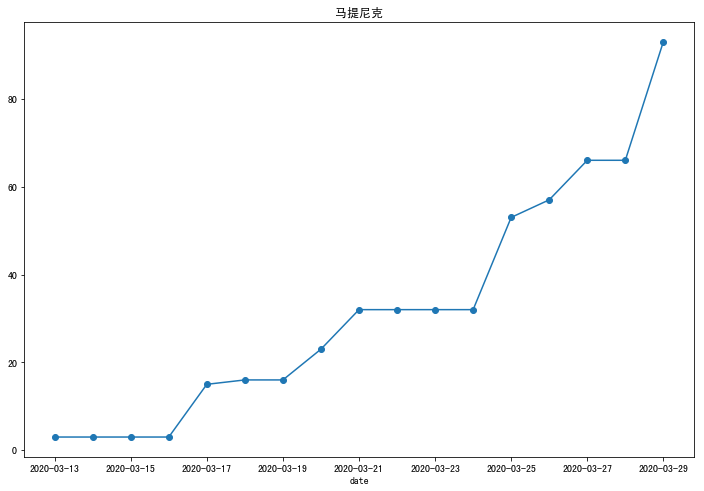

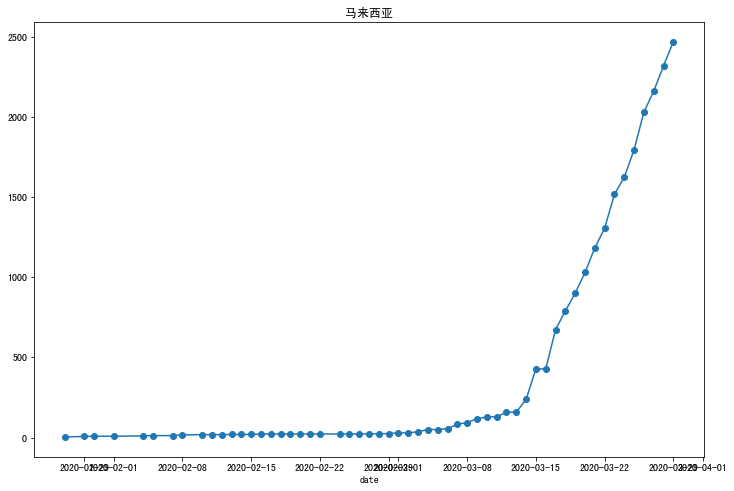

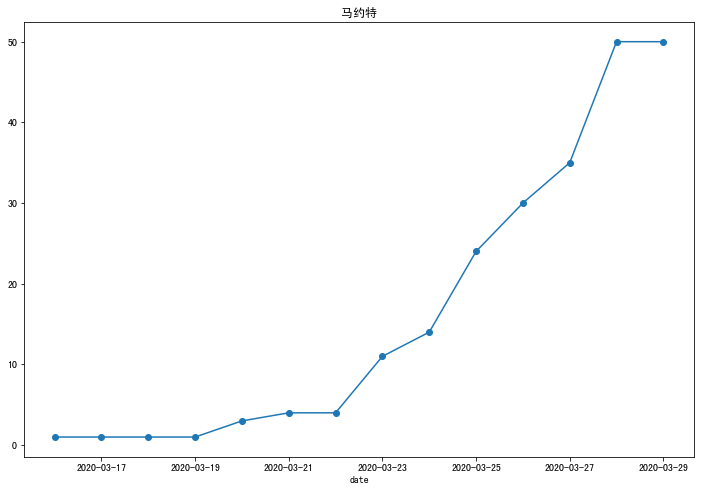

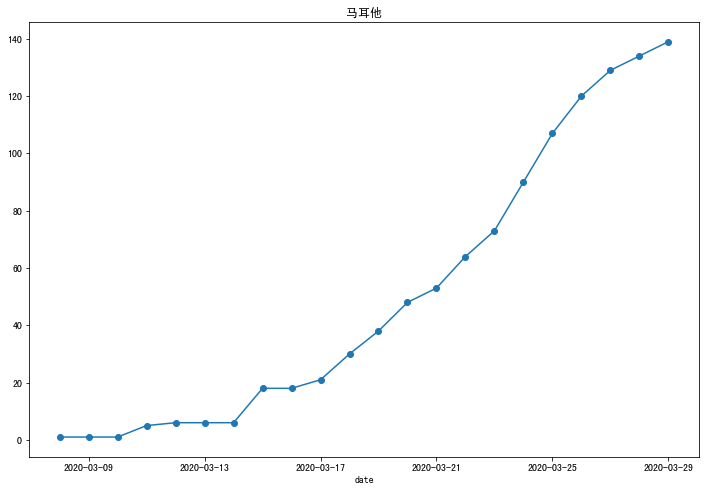

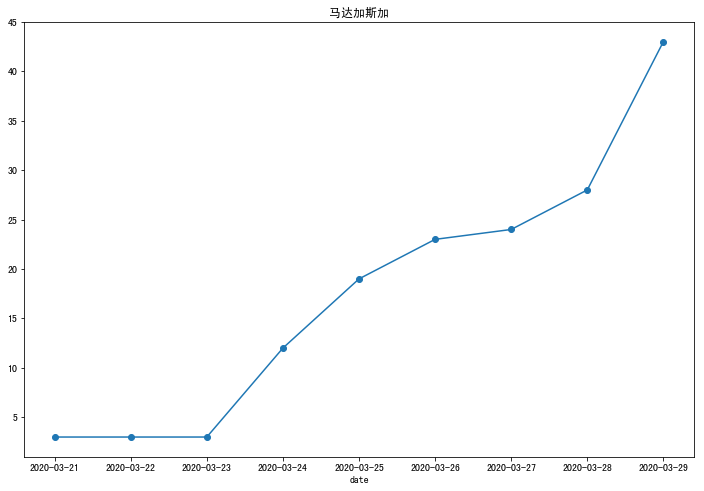

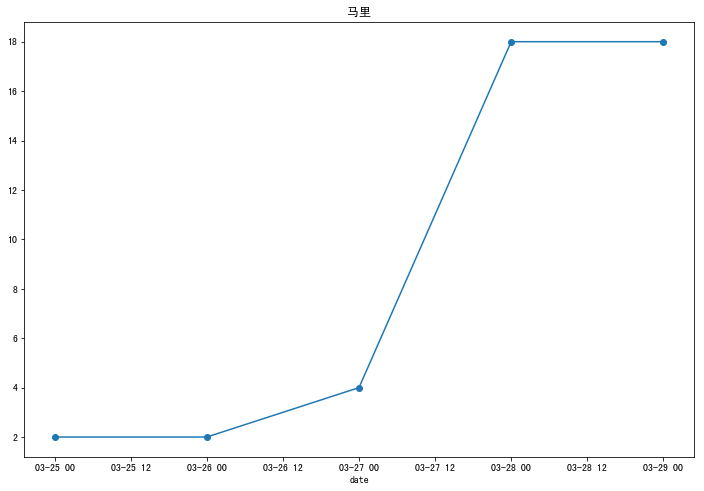

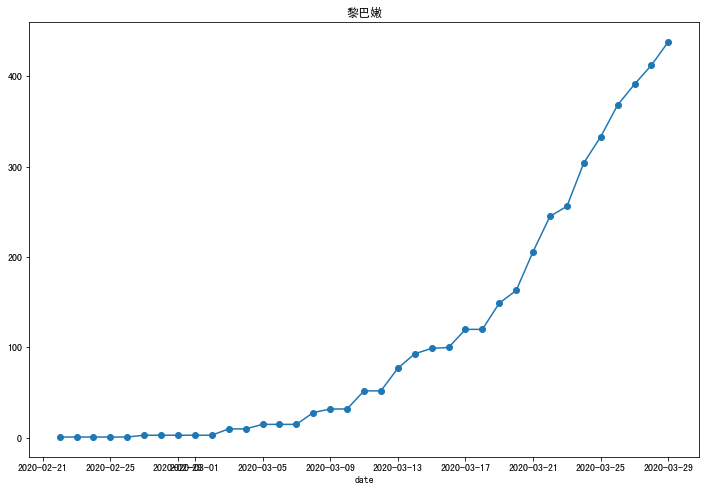

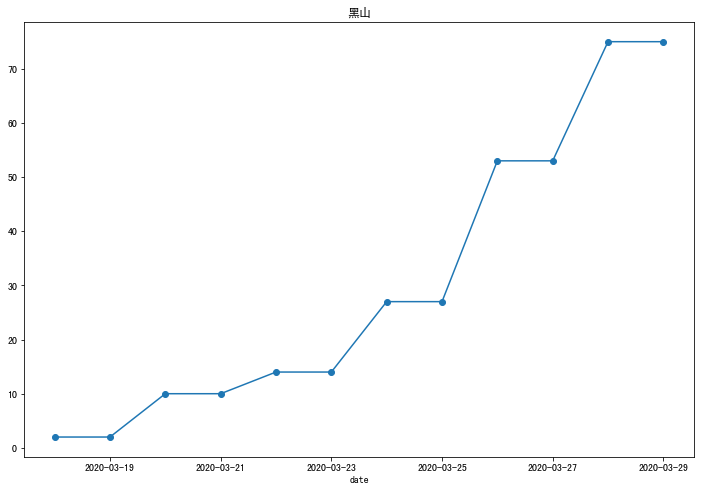

In [41]:
for country in countriesListCN:
    plt.figure()
    dfAreaGroup.xs(country, level = 1).sum(level = 1)['province_confirmedCount'].plot(title = country, figsize = (12, 8),
                                                                                     style = 'o-')

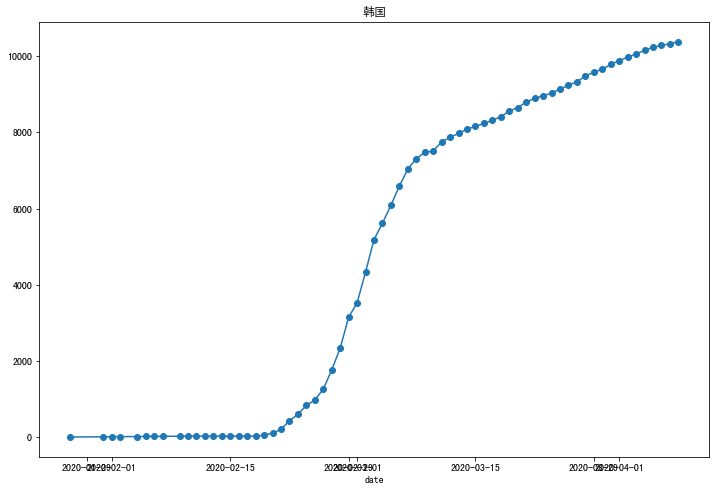

In [110]:
dfAreaGroup.xs('韩国', level = 1).sum(level = 1)['province_confirmedCount'].plot(title = '韩国', figsize = (12, 8),
                                                                               style = 'o-')

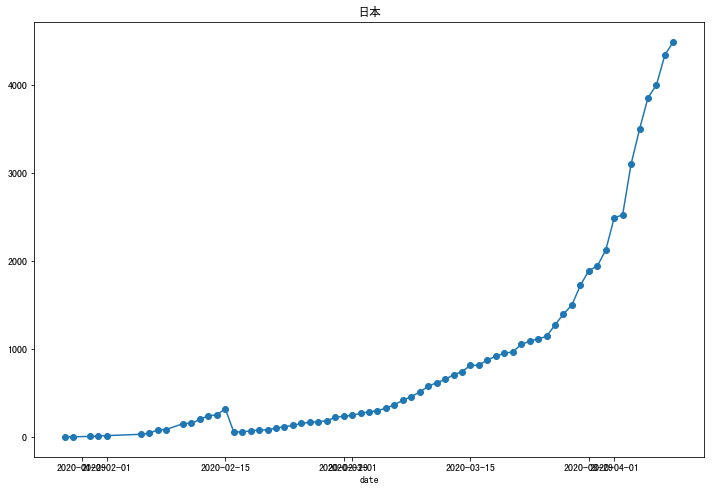

In [111]:
dfAreaGroup.xs('日本', level = 1).sum(level = 1)['province_confirmedCount'].plot(title = '日本', figsize = (12, 8), 
                                                                              style = 'o-')

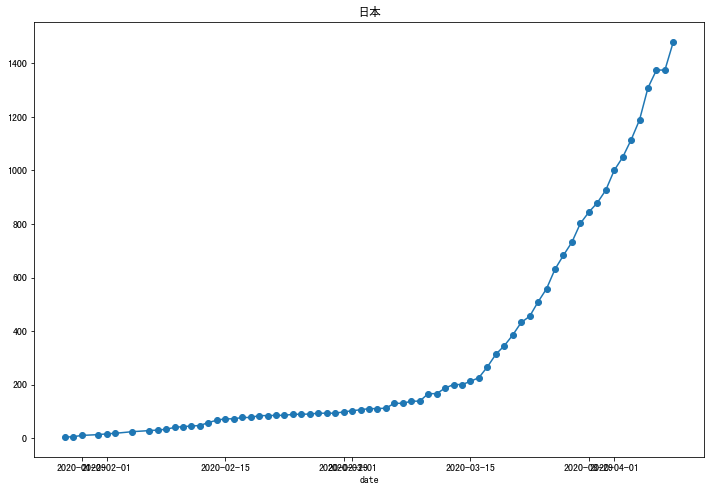

In [112]:
dfAreaGroup.xs('新加坡', level = 1).sum(level = 1)['province_confirmedCount'].plot(title = '日本', figsize = (12, 8),
                                                                               style = 'o-')

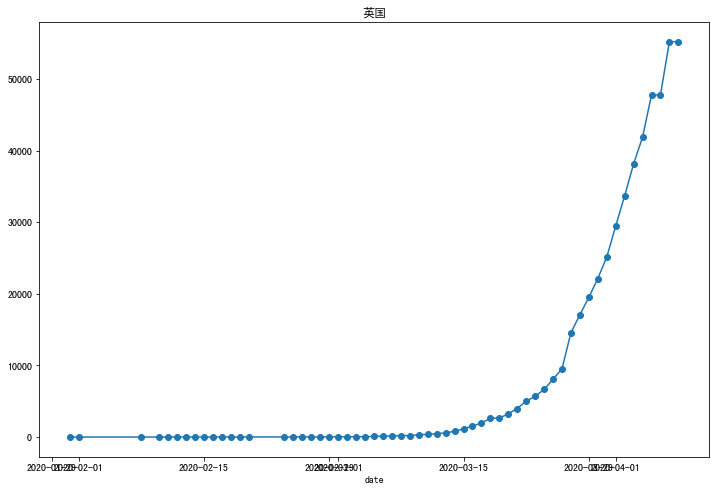

In [113]:
dfAreaGroup.xs('英国', level = 1).sum(level = 1)['province_confirmedCount'].plot(title = '英国', figsize = (12, 8),
                                                                               style = 'o-')

## 2.2 曲线拟合 - 中国: 省份整合的3月至今的数据有些不稳定，因此用中国标签的数据替代，同时去掉数量减少的点 （2020年3月7日-3月14日）

In [27]:
dfChinaSum = dfChinaByProvince.sum(level = 1)[['province_confirmedCount', 'province_suspectedCount', 
                                               'province_curedCount', 'province_deadCount']]

In [28]:
ctryName = '中国'
dfChinaSum.loc[dt.date(2020, 3, 15):] = dfAreaGroup.xs(ctryName, level = 1).sum(level = 1)[features]

In [29]:
dfChinaSum.loc[dt.date(2020, 3, 7):dt.date(2020, 3, 14), 'province_confirmedCount'] = np.nan

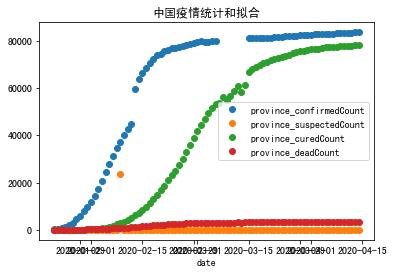

In [30]:
dfChinaSum[features].plot(style = 'o', title = '中国疫情统计和拟合')

In [31]:
import scipy.optimize as optimize

class ConfirmedCasesFitter:
    def __init__(self, df):
        self.df = df
        self.fit_func = lambda x, r, k, c : k*np.exp(r*x)/(1 + c*np.exp(r*x))
        self.truncate_time = None
        
    def fit_curve(self, fit_func = None, truncate_time = None):
        self.truncate_time = truncate_time
        self.fit_func = fit_func if fit_func is not None else self.fit_func
        df_fit = self.df.loc[:truncate_time] if truncate_time is not None else self.df
        self.y = df_fit['province_confirmedCount'].values
        self.x = np.array([(x - df_fit.index[0]).days for x in df_fit.index])
        self.x_all =  np.array([(x - self.df.index[0]).days for x in self.df.index])
        self.fitted_params, self.fitted_params_var = optimize.curve_fit(self.fit_func, self.x, self.y, method = 'trf')
        
        self.fitted_y = self.fit_func(self.x_all, *self.fitted_params)
        self.df['predicted_confirmedCount'] = self.fitted_y
        self.fitted_func = lambda x:self.fit_func(x, *self.fitted_params)
        
    
    def plot_fitted_curve(self, title = None, x = None):
        title = '' if title is None else title
        confCases = self.df['province_confirmedCount']
        df_out_sample = None
        if self.truncate_time is not None:
            next_day = self.truncate_time + dt.timedelta(days = 1) 
            df_in_sample = confCases.loc[:self.truncate_time]
            df_out_sample = confCases.loc[next_day:] if next_day in confCases.index.get_level_values(0) else None
        else:
            df_in_sample = self.df['province_confirmedCount']
            
        df_in_sample.plot(figsize = (20, 10), style = 'o', fontsize = 15)
        
        plt.title(title, fontsize = 20)
        plt.grid(True, linestyle=':')
        
        legend = ['Confirmed Cases - In Sample',
                  'Fitted Curve', 
                  'Predicted Confirmed Cases']
        if x is not None:
            fitted = self.fitted_func(np.array(x))

            indexes = np.array([self.df.index[0] + dt.timedelta(days = t) for t in x])
            plt.plot(indexes, fitted, 'x--')
            
            legend.insert(2, 'Confirmed Cases - Out of Sample')
            
            if df_out_sample is not None: 
                df_out_sample.plot(figsize = (20, 10), style = 'rv', fontsize = 15)
                
            plt.grid(True, linestyle=':')
            plt.legend(legend, loc = 'upper left', fontsize = 15)
    

In [32]:
def sigmoid(x, r, k, c):
    return k*np.exp(r*x)/(1 + c*np.exp(r*x))

def arctan(x, a, b, c, d):
    return c * np.arctan(a*x + b) + d

def arc_sigmoid(x, a, b, c, d, e, f, g, h, i):
    return h*arctan(x, a, b, c, d) + i*sigmoid(x, e, f, g)

In [33]:
import time

In [47]:
%%time

fitFunctions = {'sigmoid': sigmoid,
                'arctan': arctan,
                'arctan + sigmoid': arc_sigmoid}
fitFuncNames = ['arctan + sigmoid', 'sigmoid', 'arctan']

asOfDate = (dt.datetime.today() - dt.timedelta(days = 2)).date()

path_saveFig = './Fitted_Curve/AsOf_{}'.format(asOfDate)

import os
try:
    os.makedirs(path_saveFig)
except Exception as e:
    logging.error('Error: {}'.format(e))
    
for country in countryEnglishNameMap.index.difference(['中国']):
    dfCountry = dfAreaGroup.xs(country, level = 1).sum(level = 1)
    fitCountry = ConfirmedCasesFitter(dfCountry)
    cEng = countryEnglishNameMap.loc[country][0]
    for fitFunc in fitFuncNames:
        try:
            fitFunction = fitFunctions[fitFunc]
            title_plot = 'NCOVID-19 confirmed cases curve fit in {}, fit function is {}'.format(cEng, fitFunc)
            fitCountry.fit_curve(fit_func = fitFunction, truncate_time = asOfDate)
            fitCountry.plot_fitted_curve(title = title_plot, x = range(120))
            plt.savefig(path_saveFig + '/{}_{}.png'.format(country, fitFunc), dpi = 300, bbox_inches = 'tight')
            plt.close()
            logger.info('Succeeded {}, {}'.format(country, fitFunc))
            break
        except Exception as e:
            logger.error('Error occurred in {}, {}: {}'.format(country, fitFunc, e))

ERROR:root:Error: [Errno 17] File exists: './Fitted_Curve/AsOf_2020-04-12'
INFO:test:Succeeded 不丹, arctan + sigmoid
ERROR:test:Error occurred in 东帝汶, arctan + sigmoid: Optimal parameters not found: The maximum number of function evaluations is exceeded.
ERROR:test:Error occurred in 东帝汶, sigmoid: Optimal parameters not found: The maximum number of function evaluations is exceeded.
ERROR:test:Error occurred in 东帝汶, arctan: Optimal parameters not found: The maximum number of function evaluations is exceeded.
INFO:test:Succeeded 中非共和国, arctan + sigmoid
INFO:test:Succeeded 丹麦, arctan + sigmoid
INFO:test:Succeeded 乌克兰, arctan + sigmoid
INFO:test:Succeeded 乌兹别克斯坦, arctan + sigmoid
ERROR:test:Error occurred in 乌干达, arctan + sigmoid: Optimal parameters not found: The maximum number of function evaluations is exceeded.
INFO:test:Succeeded 乌干达, sigmoid
INFO:test:Succeeded 乌拉圭, arctan + sigmoid
INFO:test:Succeeded 乍得, arctan + sigmoid
/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.p

INFO:test:Succeeded 新西兰, arctan + sigmoid
INFO:test:Succeeded 日本, arctan + sigmoid
INFO:test:Succeeded 智利, arctan + sigmoid
INFO:test:Succeeded 柬埔寨, arctan + sigmoid
INFO:test:Succeeded 根西岛, arctan + sigmoid
INFO:test:Succeeded 格林那达, arctan + sigmoid
INFO:test:Succeeded 格陵兰, arctan + sigmoid
INFO:test:Succeeded 格鲁吉亚, arctan + sigmoid
INFO:test:Succeeded 梵蒂冈, arctan + sigmoid
INFO:test:Succeeded 比利时, arctan + sigmoid
ERROR:test:Error occurred in 毛里塔尼亚, arctan + sigmoid: Optimal parameters not found: The maximum number of function evaluations is exceeded.
INFO:test:Succeeded 毛里塔尼亚, sigmoid
ERROR:test:Error occurred in 毛里求斯, arctan + sigmoid: Optimal parameters not found: The maximum number of function evaluations is exceeded.
INFO:test:Succeeded 毛里求斯, sigmoid
INFO:test:Succeeded 沙特阿拉伯, arctan + sigmoid
INFO:test:Succeeded 法国, arctan + sigmoid
ERROR:test:Error occurred in 法属圭亚那, arctan + sigmoid: Optimal parameters not found: The maximum number of function evaluations is exceeded.
INFO:te

CPU times: user 21min 38s, sys: 25.5 s, total: 22min 4s
Wall time: 20min 50s


In [35]:
outliersChina = pd.date_range(dt.date(2020, 2, 7), dt.date(2020, 2, 12))

dfChinaForFit = dfChinaSum.dropna(subset = ['province_confirmedCount']).drop(outliersChina)

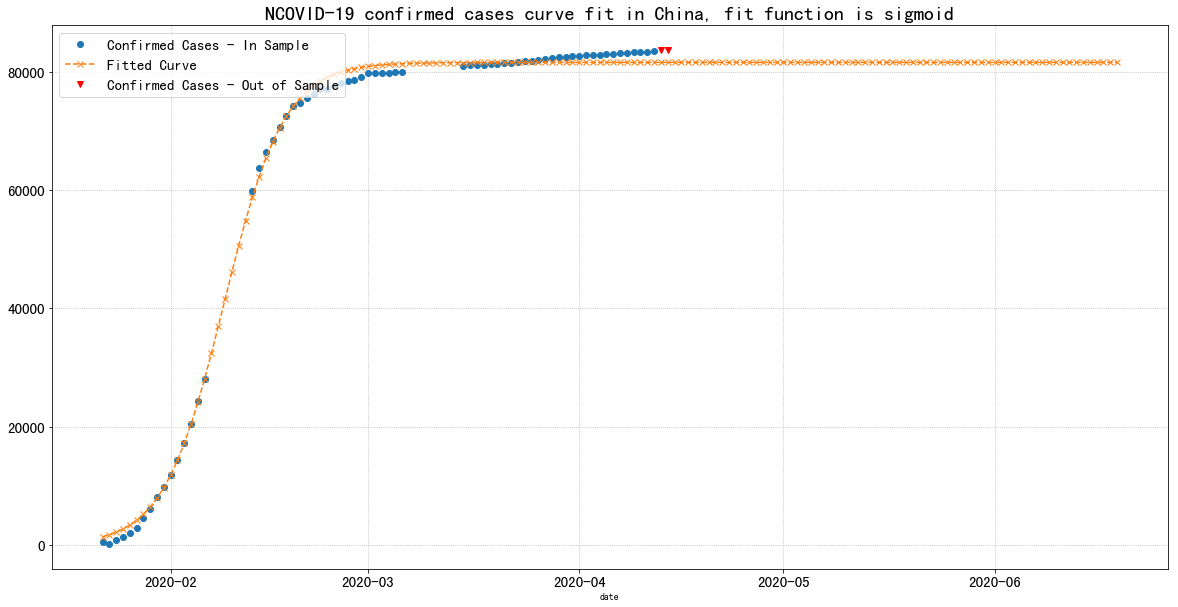

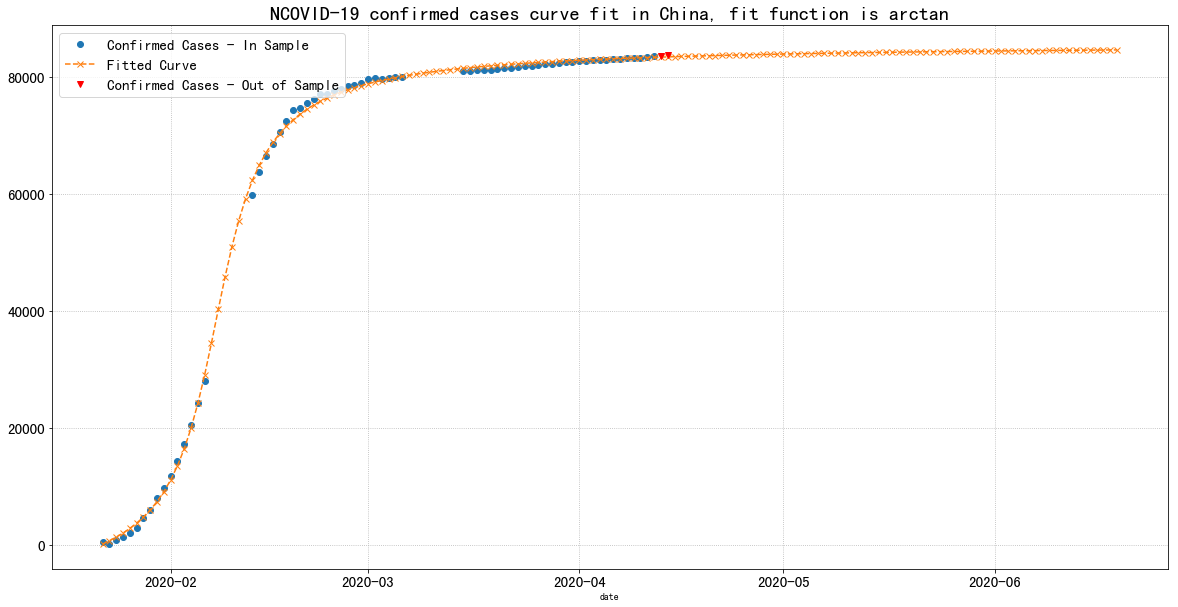

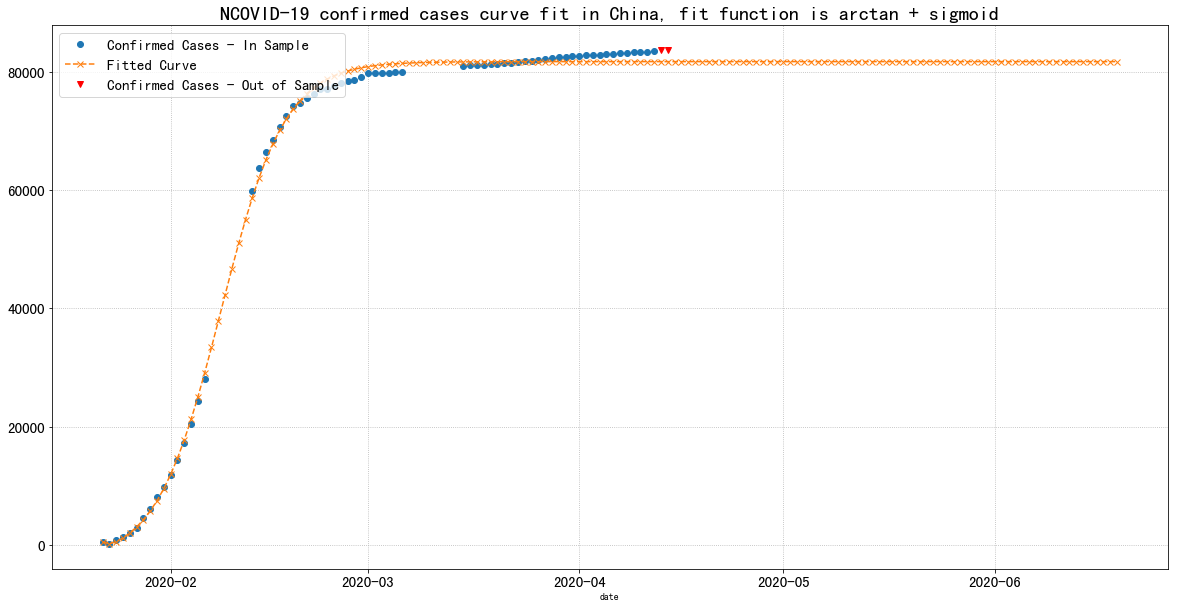

<Figure size 432x288 with 0 Axes>

In [37]:
fitChina = ConfirmedCasesFitter(dfChinaForFit)
cEng = 'China'


fitFunc = 'arctan + sigmoid'
for fitFunc in fitFunctions:
    fitFunction = fitFunctions[fitFunc]
    title_plot = 'NCOVID-19 confirmed cases curve fit in {}, fit function is {}'.format(cEng, fitFunc)
    fitChina.fit_curve(fit_func = fitFunction, truncate_time = asOfDate)
    fitChina.plot_fitted_curve(title = title_plot, x = range(150))

    plt.savefig(path_saveFig + '/{}_{}.png'.format('中国', fitFunc), dpi = 300, bbox_inches = 'tight')
    #plt.close()
    logger.info('Succeeded {}, {}'.format('中国', fitFunc))
    plt.figure()

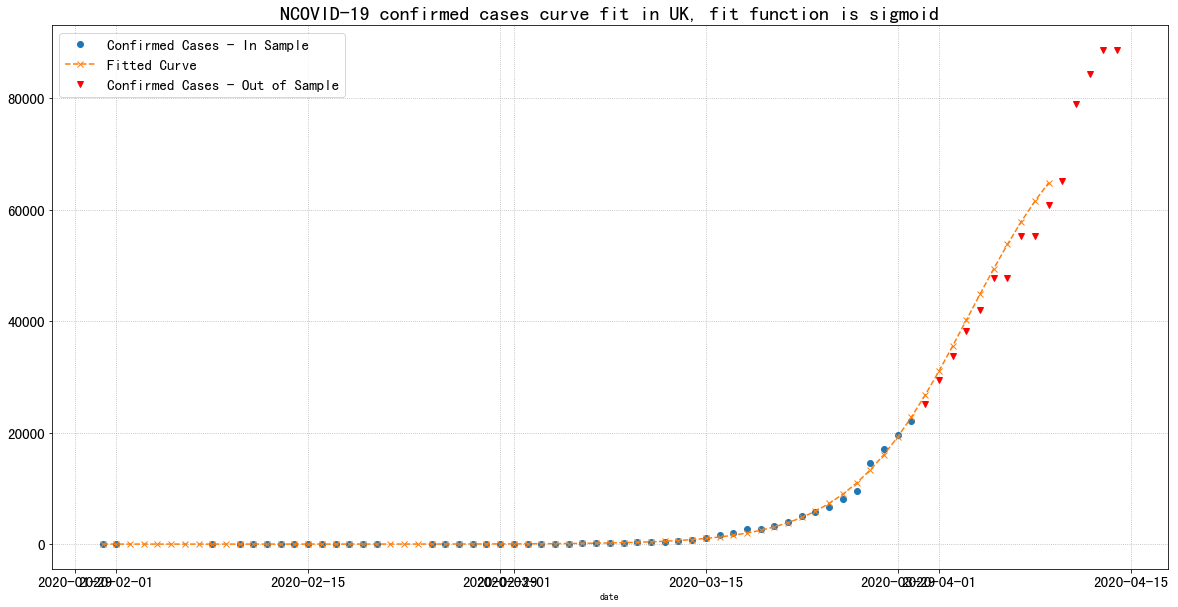

In [38]:
dfUK = dfAreaGroup.xs('英国', level = 1).sum(level = 1)#.loc[dt.date(2020, 3, 17):]
fitUK = ConfirmedCasesFitter(dfUK)
country = 'UK'
title_plot = 'NCOVID-19 confirmed cases curve fit in {}, fit function is sigmoid'.format(country)
fitUK.fit_curve(fit_func = sigmoid, truncate_time = dt.date(2020, 3, 30))
fitUK.plot_fitted_curve(title = title_plot, x = range(70))

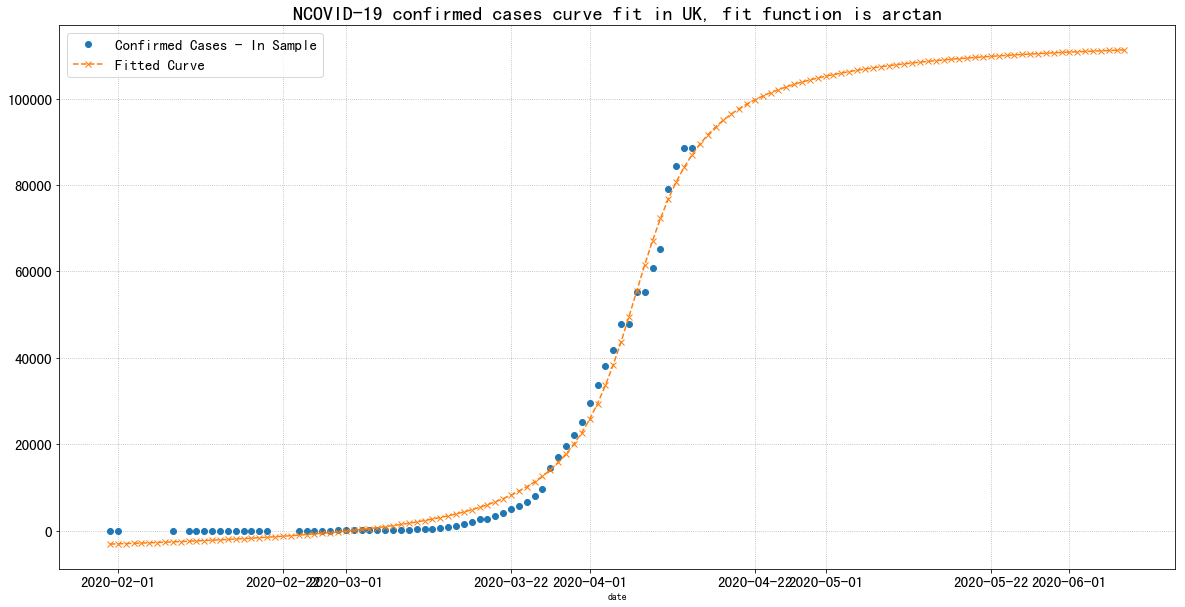

In [41]:
dfUK = dfAreaGroup.xs('英国', level = 1).sum(level = 1)#.loc[dt.date(2020, 3, 17):]
fitUK = ConfirmedCasesFitter(dfUK)
country = 'UK'
title_plot = 'NCOVID-19 confirmed cases curve fit in {}, fit function is arctan'.format(country)
fitUK.fit_curve(fit_func = arctan)
fitUK.plot_fitted_curve(title = title_plot, x = range(130))

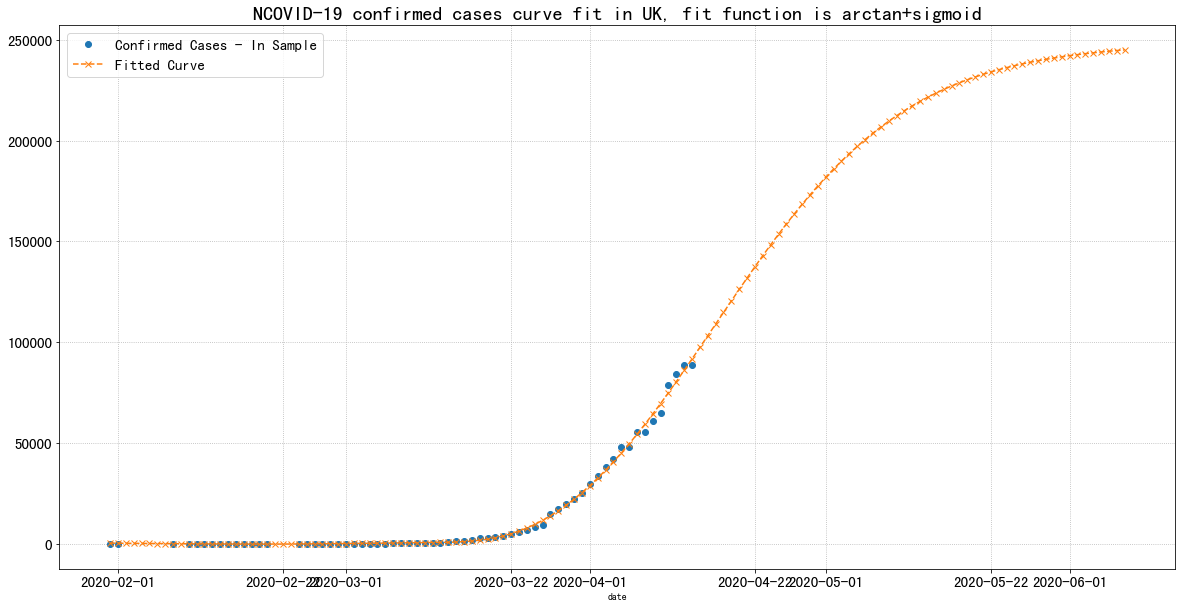

In [43]:
dfUK = dfAreaGroup.xs('英国', level = 1).sum(level = 1)#.loc[dt.date(2020, 3, 17):]
fitUK = ConfirmedCasesFitter(dfUK)
country = 'UK'
title_plot = 'NCOVID-19 confirmed cases curve fit in {}, fit function is arctan+sigmoid'.format(country)
fitUK.fit_curve(fit_func = arc_sigmoid)
fitUK.plot_fitted_curve(title = title_plot, x = range(130))

In [44]:
dfFrance = dfAreaGroup.xs('法国', level = 1).sum(level = 1)

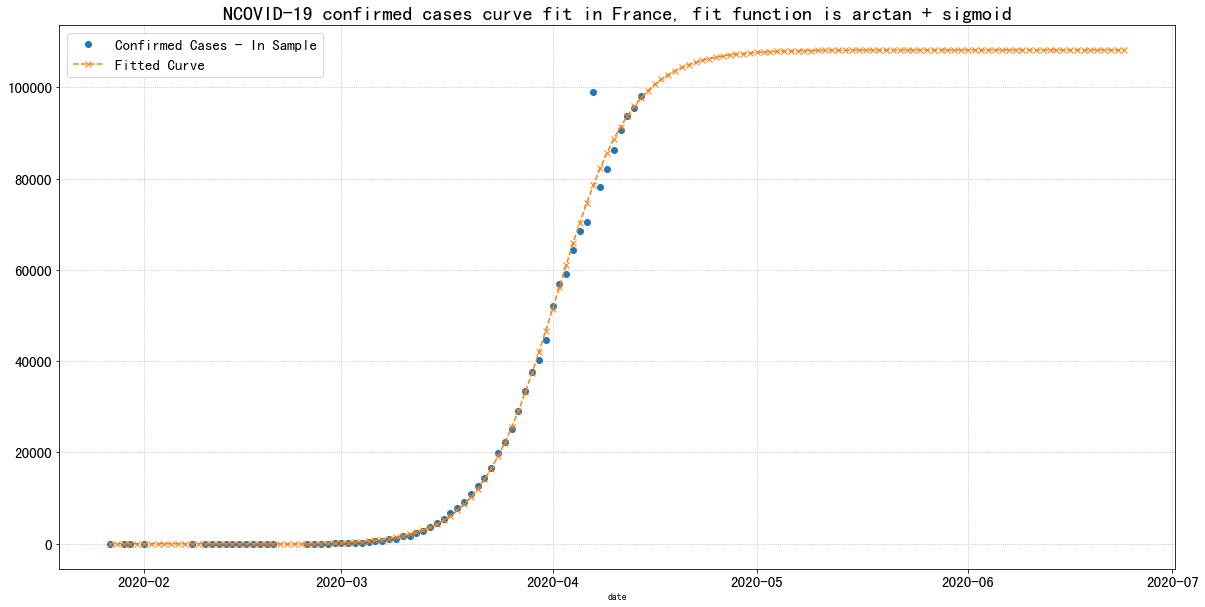

In [45]:
fitFrance = ConfirmedCasesFitter(dfFrance)
country = 'France'
title_plot = 'NCOVID-19 confirmed cases curve fit in {}, fit function is arctan + sigmoid'.format(country)
fitFrance.fit_curve(fit_func = arc_sigmoid, truncate_time = None)
fitFrance.plot_fitted_curve(title = title_plot, x = range(150))

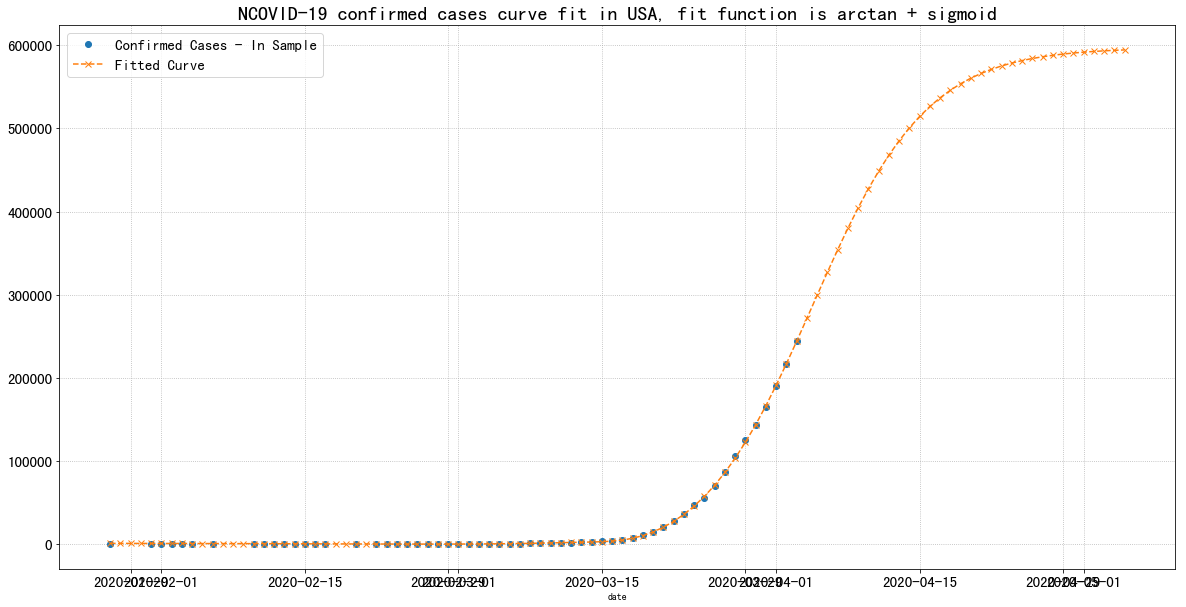

In [33]:
dfUSA = dfAreaGroup.xs('美国', level = 1).sum(level = 1)
fitUSA = ConfirmedCasesFitter(dfUSA)
country = 'USA'
title_plot = 'NCOVID-19 confirmed cases curve fit in {}, fit function is arctan + sigmoid'.format(country)
fitUSA.fit_curve(fit_func = arc_sigmoid, truncate_time = None)
fitUSA.plot_fitted_curve(title = title_plot, x = range(100))

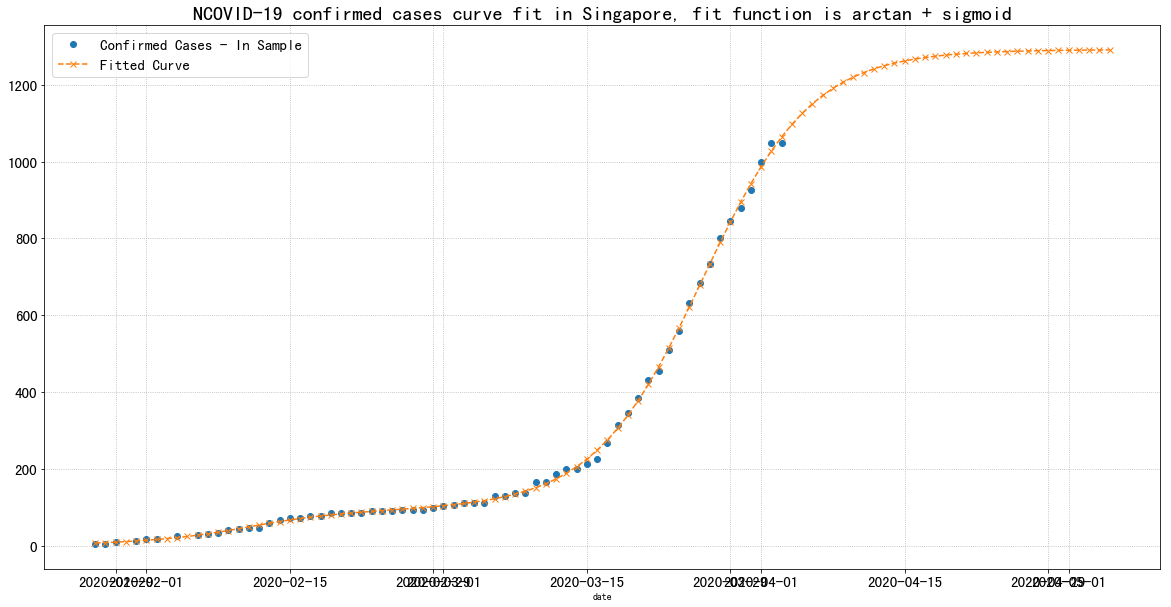

In [56]:
dfSin = dfAreaGroup.xs('新加坡', level = 1).sum(level = 1)
fitSin = ConfirmedCasesFitter(dfSin)
country = 'Singapore'
title_plot = 'NCOVID-19 confirmed cases curve fit in {}, fit function is arctan + sigmoid'.format(country)
fitSin.fit_curve(fit_func = arc_sigmoid, truncate_time = None)
fitSin.plot_fitted_curve(title = title_plot, x = range(100))

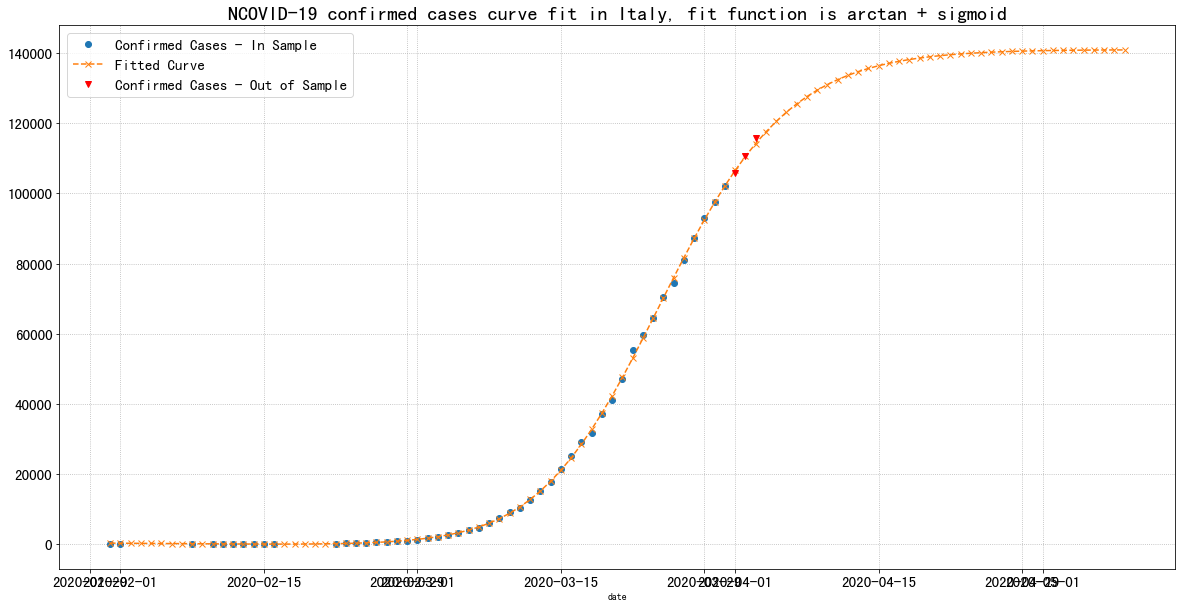

In [57]:
dfSin = dfAreaGroup.xs('意大利', level = 1).sum(level = 1)
fitSin = ConfirmedCasesFitter(dfSin)
country = 'Italy'
title_plot = 'NCOVID-19 confirmed cases curve fit in {}, fit function is arctan + sigmoid'.format(country)
fitSin.fit_curve(fit_func = arc_sigmoid, truncate_time = dt.date(2020, 3, 31))
fitSin.plot_fitted_curve(title = title_plot, x = range(100))

dfAreaGroup.sum(level = -1).sort_index()